Our own DEG analysis for Chen et al., (2020).  From their text they had several adhoc steps and refused to publish or share code.  Relevant publication: [Law, Charity W., Kathleen Zeglinski, Xueyi Dong, Monther Alhamdoosh, Gordon K. Smyth, and Matthew E. Ritchie. "A guide to creating design matrices for gene expression experiments." F1000Research 9 (2020).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7873980/) also see the [Limma User Guide](https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf).  Section 9.5 in particular has an explanation of making contrasts for interaction terms which could be usefull.  The text for the voom transformation is informative for the more technical details of the analysis: http://www.statsci.org/smyth/pubs/VoomPreprint.pdf
<br>
This publication maybe interesting as well: https://www.nature.com/articles/s41467-021-25960-2  
<br>
This may also be useful: https://github.com/hbc/knowledgebase/blob/master/scrnaseq/pseudobulkDE_edgeR.md

In [1]:
library(randomForest)
library(rfUtilities)
library(stringr)
library(sampler)
library(caTools)
library(pROC)
library(ggplot2)
library(stats)
library(Dict)
library(pheatmap)
library(caret)
library(data.table)
library(dplyr)
library(lme4)
library(edgeR)
library(tictoc)
library(factoextra)
library(FactoMineR)
library(compositions)
library(scrime)
library(nebula)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var



Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: limma

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attachin

In [2]:
#paths

In [3]:
# Functions

# normalization functions
pseudocount_log2p1_transform <- function(x, scale_factor = 10^6, UMI.provided = NULL){
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x)/counts
  x <- x*scale_factor
  return(log2(x+1))
}

pavlab.normalize <- function(df, UMI = NULL){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
#
   df[] <- Map(pseudocount_log2p1_transform, df, UMI.provided = UMI)
  
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}


# to write pheatmap images to file as a .png
save_pheatmap <- function(x, filename, width=480, height=960) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename,width = width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

In [4]:
# file paths 

chencounts.path <- '~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/GSE152632_GEO_mberkchen_TRAP2_counts.csv.gz'
chenmeta.path <- '~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/SraRunTable.txt'
chenclsutermarkers.formeta.path <- "~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/Chen2020_ClusterMarkers.csv"
humanmouseorthologtable.path <- "/home/acampbell/PavLabEngrams/EngramCellClassifier/hg_mm_1to1_ortho_genes_DIOPT-v8.tsv"

In [5]:
# genes from the origianl publication listed in figure 3c as differentially expressed accoridng to their
# DEG discovery method

chen_remotememory_markers <- c("Hid1", "Kctd10", "Pdha1", "Pigq", "Skiv2l2", "Abcf3", "Miga2", "Mmd", "Sar1a", "Eif2ak1", "Acsf3", 
                               "Cdc42se2", "Fam134a", "Vamp2", "Gsk3b", "Hnrnph2", "Pja2", "Sdha", "Gdi2", "Rab15", "Fam131a", "Gfra2",
                               "Pip4k2c", "Ncdn", "Usp5", "Nell2", "Tmem151a", "Dmtn", "Rtn3", "Pcsk2", "Pfkm", "Trim32", "Mfsd14b",
                               "Rab5a", "Tdg", "Emc1", "Gpm6a", "Elmod1", "Cycs", "Sarnp", "Rab24", "Erp29", "Ghitm", "Zfp706", "Sult4a1",
                               "App", "Cck", "Emc4", "Psmb6", "Atp6v0b", "Hint1", "Guk1", "Rtn1", "Clpp", "Crip2", "Mpc1", "Atp6v0c",
                               "Atp5g3", "Tmem50a", "Plekhb2", "Syt13", "Garnl3", "Dpysl4", "Aplp1", "Hnrnpk", "Nsf", "Mfsd14a", 
                               "Mir124-2hg", "Nck2", "Stx1b", "Pak1", "Slc25a46", "Itfg1", "Lmbrd1", "Tmx1", "Dner", "Atad1", 
                               "Ankrd45", "Timm29", "Vopp1", "Pls3", "Hmg20a", "Ctbp1", "Strip1", "Cdv3", "Inpp5f", "Prkar1b",
                               "Slc30a9", "Alg2", "Trim35", "Hacd3", "Serinc1", "Serinc3", "Ptp4a1")

upreg_rem_markers <- c("Hid1", "Kctd10", "Pdha1", "Pigq", "Skiv2l2", "Abcf3", "Miga2", "Mmd", "Sar1a", "Eif2ak1", "Acsf3",
                       "Cdc42se2", "Fam134a", "Vamp2", "Gsk3b", "Hnrnph2", "Pja2", "Sdha", "Gdi2", "Rab15", "Fam131a", 
                       "Gfra2", "Pip4k2c", "Ncdn", "Usp5", "Nell2", "Tmem151a", "Dmtn", "Rtn3", "Pcsk2", "Pfkm", "Trim32",
                       "Mfsd14b", "Rab5a", "Tdg", "Emc1", "Gpm6a", "Ghitm", "Zfp706", "Sult4a1", "App", "Atp6v0c", "Atp5g3",
                       "Plekhb2", "Syt13", "Garnl3", "Dpysl4", "Aplp1", "Hnrnpk", "Nsf", "Mfsd14a", "Mir124-2hg", "Nck2", "Stx1b",
                       "Pak1", "Slc25a46", "Itfg1", "Lmbrd1", "Tmx1", "Dner", "Atad1", "Ankrd45", "Timm29", "Vopp1", "Pls3", "Hmg20a",
                       "Ctbp1", "Strip1", "Cdv3", "Inpp5f", "Prkar1b", "Slc30a9", "Alg2", "Trim35", "Hacd3", "Serinc1", "Serinc3", "Ptp4a1")



dkkl1_rem_markers <- c("Vamp2", "Gsk3b", "Hnrnph2", "Pja2", "Sdha", "Gdi2", "Rab15", "Fam131a", 
                       "Gfra2", "Pip4k2c", "Ncdn", "Usp5", "Nell2", "Tmem151a", "Dmtn", "Rtn3",
                       "Pcsk2", "Pfkm", "Trim32", "Mfsd14b", "Rab5a", "Tdg", "Emc1", "Gpm6a","Cck",
                       "Emc4","Nsf","Hacd3", "Serinc1", "Serinc3", "Ptp4a1")

dkkl1_rem_markers.upregulated <- c("Vamp2", "Gsk3b", "Hnrnph2", "Pja2", "Sdha", "Gdi2", "Rab15", "Fam131a", "Gfra2",
                                   "Pip4k2c", "Ncdn", "Usp5", "Nell2", "Tmem151a", "Dmtn", "Rtn3", "Pcsk2", "Pfkm", 
                                   "Trim32", "Mfsd14b", "Rab5a", "Tdg", "Emc1", "Gpm6a","Nsf","Hacd3", "Serinc1", 
                                   "Serinc3", "Ptp4a1")

In [6]:
#Chen
chen2020_counts <- read.csv(chencounts.path, header = TRUE)
rownames(chen2020_counts) <- chen2020_counts$X
chen2020_counts <- chen2020_counts[,2:3531]
chen2020_meta <- read.csv( chenmeta.path , header = TRUE)

#add engram label
chen2020_meta$engram_label <-  as.factor(sapply(as.character(colnames(chen2020_counts)), function(y) if (grepl("_pos_", y, fixed=TRUE)) "tdT+" else "tdT-"))

#create the condition label
condition_label <- chen2020_meta$source_name %>%
  sapply( function(y) if (grepl("Homecage", y, fixed=TRUE)) "Homecage")

condition_label <- chen2020_meta$source_name
condition_label[str_detect(condition_label, "Homecage")] = "Homecage"
condition_label[str_detect(condition_label, "Context-Only")] = "Context-Only"
condition_label[str_detect(condition_label, "Fear-Only")] = "Fear-Only"
condition_label[str_detect(condition_label, "Fear-Recall")] = "Fear-Recall"
chen2020_meta$condition_label <- condition_label

#adding cell bacrcodes from coutn data to rows of metadata for seurat
rownames(chen2020_meta) <- colnames(chen2020_counts)


chen2020_meta <- cbind(chen2020_meta, read.csv(chenclsutermarkers.formeta.path) )
         
###

In [7]:
# gene filtering
# Filter out rows with less than 10 columns with values greater than 1
chen.genefilter <- rowSums(chen2020_counts > 0) >= 10 # removes about 3k genes, use it later (not at cell level)
chen.cellfilter <- (colSums(chen2020_counts) > 50000) | (colSums(chen2020_counts > 0) >= 100) # doesn't change anything I think they only reported cells that passed this filter

In [8]:
# we are only interested in genes with human orthologs anyway
# we also only want protien coding genes so this may help
hg_to_mm <- read.table(humanmouseorthologtable.path , sep = '\t', header = TRUE)

# try to get protien coding list

In [9]:
# to preserve the original data
chen_og <- chen2020_counts
#chen2020_counts <- chen_og
# now we filter
#chen2020_counts <- chen2020_counts[chen.genefilter,chen.cellfilter ] # do this later after we pseudobulk to do cor() on samples
chen2020_counts <- chen2020_counts[,chen.cellfilter ]
chen2020_meta <- chen2020_meta[chen.cellfilter ,]

In [10]:
# could make this a nested apply, or aggreggate


# Create a list to store the masks
masks <- list()

# Iterate through each unique combination of source_name, broad_cell_types, and engram_label
for (i in unique(chen2020_meta$source_name)) {
  for (j in unique(chen2020_meta$BroadCellTypes)) {
    for (k in unique(chen2020_meta$engram_label)) {
      # Create a boolean mask for each unique combination
      mask <- chen2020_meta$source_name == i & chen2020_meta$BroadCellTypes == j & chen2020_meta$engram_label == k
      print(sum(mask))
      # Name the mask after the unique combination
      name <- paste(i, j, k, sep = "_")
      print(name)
      # Store the mask in the list
      masks[[name]] <- mask
      # Print the name of the mask
    }
  }
}


[1] 32
[1] "m5_Homecage_Excitatory_tdT-"
[1] 65
[1] "m5_Homecage_Excitatory_tdT+"
[1] 9
[1] "m5_Homecage_Inhibitory_tdT-"
[1] 28
[1] "m5_Homecage_Inhibitory_tdT+"
[1] 55
[1] "m5_Context-Only_Excitatory_tdT-"
[1] 39
[1] "m5_Context-Only_Excitatory_tdT+"
[1] 10
[1] "m5_Context-Only_Inhibitory_tdT-"
[1] 1
[1] "m5_Context-Only_Inhibitory_tdT+"
[1] 61
[1] "m2_Context-Only_Excitatory_tdT-"
[1] 101
[1] "m2_Context-Only_Excitatory_tdT+"
[1] 16
[1] "m2_Context-Only_Inhibitory_tdT-"
[1] 35
[1] "m2_Context-Only_Inhibitory_tdT+"
[1] 113
[1] "m2_Fear-Only_Excitatory_tdT-"
[1] 94
[1] "m2_Fear-Only_Excitatory_tdT+"
[1] 33
[1] "m2_Fear-Only_Inhibitory_tdT-"
[1] 6
[1] "m2_Fear-Only_Inhibitory_tdT+"
[1] 31
[1] "m1_Fear-Recall_Excitatory_tdT-"
[1] 43
[1] "m1_Fear-Recall_Excitatory_tdT+"
[1] 26
[1] "m1_Fear-Recall_Inhibitory_tdT-"
[1] 75
[1] "m1_Fear-Recall_Inhibitory_tdT+"
[1] 8
[1] "m1_Fear-Only_Excitatory_tdT-"
[1] 11
[1] "m1_Fear-Only_Excitatory_tdT+"
[1] 4
[1] "m1_Fear-Only_Inhibitory_tdT-"
[1] 13
[1

In [11]:
#we need to reorder these masks for later down the line for plotting purposes

reorder_str_vector <- function(string_vec, order_by_these_substrings){
    # string vec is a list of strings
    # order_by_these_substrings is the lsit of substrings to search for in the 
    # string_vec and to group together 
    # returns a new string vector grouped and ordered with any character strings not containing the substrings of interest removed
    # so in a list of reddog, redcat,bluedog,purplecat, greeparrot, yellowdog if you provide the substrings c('cat','dog')
    # you search would return  c('redcat','purplecat','reddog','bluedog','yellowdog')
    
    modified_string_vec <- c()
    
    for (substring in order_by_these_substrings){
        modified_string_vec <- c(modified_string_vec, string_vec[grepl(substring,string_vec, fixed = T)])
        }
    return(modified_string_vec)
    }

condition_order <- c('Fear-Recall','Fear-Only','Context-Only','Homecage')

reorderdnames <- c( reorder_str_vector(names(masks)[grepl('tdT+',names(masks), fixed = T)], condition_order),
                    reorder_str_vector(names(masks)[grepl('tdT-',names(masks), fixed = T)], condition_order) )

masks <- masks[reorderdnames]

In [12]:
genes <- rownames(chen2020_counts)

# create matrix to fill
pseudobulk <- matrix(0, nrow = length(genes), ncol = length(masks))
pseudobulk <- as.data.frame(pseudobulk)
rownames(pseudobulk) <- genes
colnames(pseudobulk) <- names(masks)

In [13]:
# markers from chen
chen_remotememory_markers <- c("Hid1", "Kctd10", "Pdha1", "Pigq", "Skiv2l2", "Abcf3", "Miga2", "Mmd", "Sar1a",
                               "Eif2ak1", "Acsf3", "Cdc42se2", "Fam134a", "Vamp2", "Gsk3b", "Hnrnph2", "Pja2",
                               "Sdha", "Gdi2", "Rab15", "Fam131a", "Gfra2", "Pip4k2c", "Ncdn", "Usp5", "Nell2",
                               "Tmem151a", "Dmtn", "Rtn3", "Pcsk2", "Pfkm", "Trim32", "Mfsd14b", "Rab5a", "Tdg",
                               "Emc1", "Gpm6a", "Elmod1", "Cycs", "Sarnp", "Rab24", "Erp29", "Ghitm", "Zfp706",
                               "Sult4a1", "App", "Cck", "Emc4", "Psmb6", "Atp6v0b", "Hint1", "Guk1", "Rtn1", "Clpp", 
                               "Crip2", "Mpc1", "Atp6v0c", "Atp5g3", "Tmem50a", "Plekhb2", "Syt13", "Garnl3", "Dpysl4",
                               "Aplp1", "Hnrnpk", "Nsf", "Mfsd14a", "Mir124-2hg", "Nck2", "Stx1b", "Pak1", "Slc25a46",
                               "Itfg1", "Lmbrd1", "Tmx1", "Dner", "Atad1", "Ankrd45", "Timm29", "Vopp1", "Pls3", "Hmg20a",
                               "Ctbp1", "Strip1", "Cdv3", "Inpp5f", "Prkar1b", "Slc30a9", "Alg2", "Trim35", "Hacd3", "Serinc1",
                               "Serinc3", "Ptp4a1")

upreg_rem_markers <- c("Hid1", "Kctd10", "Pdha1", "Pigq", "Skiv2l2", "Abcf3", "Miga2", "Mmd", "Sar1a",
                       "Eif2ak1", "Acsf3", "Cdc42se2", "Fam134a", "Vamp2", "Gsk3b", "Hnrnph2", "Pja2",
                       "Sdha", "Gdi2", "Rab15", "Fam131a", "Gfra2", "Pip4k2c", "Ncdn", "Usp5", "Nell2",
                       "Tmem151a", "Dmtn", "Rtn3", "Pcsk2", "Pfkm", "Trim32", "Mfsd14b", "Rab5a", "Tdg",
                       "Emc1", "Gpm6a", "Ghitm", "Zfp706", "Sult4a1", "App", "Atp6v0c", "Atp5g3", 
                       "Plekhb2", "Syt13", "Garnl3", "Dpysl4", "Aplp1", "Hnrnpk", "Nsf", "Mfsd14a",
                       "Mir124-2hg", "Nck2", "Stx1b", "Pak1", "Slc25a46", "Itfg1", "Lmbrd1", "Tmx1", "Dner", 
                       "Atad1", "Ankrd45", "Timm29", "Vopp1", "Pls3", "Hmg20a", "Ctbp1", "Strip1", "Cdv3",
                       "Inpp5f", "Prkar1b", "Slc30a9", "Alg2", "Trim35", "Hacd3", "Serinc1", "Serinc3", "Ptp4a1")

In [14]:
# pseudobulk our samples
for (sample in names(masks)) {

    #get mask to filter counts matrix cell-wise (col wise) by
    these_cols <- masks[[sample]]
    
    # we need to handle exceptions otherwise rowSums throws errors
    # it needs a 2d array which can't happen in a no cell case or a 1 cell case
    # we should consider removing these cases enttirely
    # we 
    if(sum(these_cols)==0){
        # do nothing in this case, but convert column to integer to avoid errors later
        pseudobulk[,sample] <- as.integer(pseudobulk[,sample])
        }else if(sum(these_cols)==1){
        # 
        pseudobulk[,sample] <- as.integer(chen2020_counts[, these_cols])
    }else{
    pseudobulk[,sample] <- as.integer( rowSums(chen2020_counts[, these_cols]) ) }
}

pseudobulk.librarysizes <- colSums(pseudobulk)

In [15]:
multi.sub <- function(findthis, replacewith, x.vec){
    # replaces an entry containing a string matching an entry in findthis in x.vec with a corresponding entry in replacewith
    
    # seq_along returns enumerates integers from 1 to length of input list
    # loops over list of things to find
    for(i in seq_along(findthis)){
    #masks vector where 
    x.vec[grepl(findthis[i], x.vec)] <- replacewith[i]}
    return(x.vec)
    }

# since we are finding a pattern in the pseudobulk_meta titles and replacing each entry wiht that pattern we would have to enter the vector twice
# now we make a function so we only have to enter each list once making our code a little more legible
fun <- function(my_list, dfcol){
    factors.list <- unique(dfcol)
    return( multi.sub(factors.list, factors.list, my_list) )
    }

In [16]:
pseudobulk_meta <-  data.frame(celltype =  as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$BroadCellTypes) ) ) ),
                               condition = as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$condition_label) ) ) ),
                               TRAPed = as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$engram_label) ) ) ),
                               replicate = as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$source_name) ) ) )
                               )

levels(pseudobulk_meta$TRAPed) <- c('positive', 'negative') # the labelled neurons get levels named 1 and 2 so this makes the dataframe more interpretable

In [17]:
n_cells <- list()
for(i in seq_along( names(masks) )){n_cells <- append(n_cells, sum(masks[[i]]))}
pseudobulk_meta$n_cells <- as.integer(n_cells) # adding cell counts to dataframe
rm(n_cells) # deleting unneeded variable

In [18]:
mean(pseudobulk_meta$n_cells[pseudobulk_meta$celltype=='Inhibitory'])

[1] 25.7

In [19]:
mean(pseudobulk_meta$n_cells[pseudobulk_meta$celltype=='Excitatory'])

[1] 62.55

In [20]:
# now we need to add the factrs we will use for prediction, fear, recal, environment exposure
# the effects we will be itnerested in will be in the fear*recall*environment*TRAPed interaction

pseudobulk_meta$environment_exposure <- as.factor(pseudobulk_meta$condition != 'Homecage')
pseudobulk_meta$fear <- as.factor(grepl('Fear', pseudobulk_meta$condition) )
pseudobulk_meta$recall <- as.factor( grepl('Context-Only', pseudobulk_meta$condition) | grepl('Fear-Recall', pseudobulk_meta$condition) )

In [21]:
# check our data is looking good, what the shape is
print(dim(pseudobulk_meta))
head(pseudobulk_meta, 5)

[1] 80  8


,celltype,condition,TRAPed,replicate,n_cells,environment_exposure,fear,recall
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
m1_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m1_Fear-Recall,43,TRUE,TRUE,TRUE
m1_Fear-Recall_Inhibitory_tdT+,Inhibitory,Fear-Recall,positive,m1_Fear-Recall,75,TRUE,TRUE,TRUE
m3_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m3_Fear-Recall,222,TRUE,TRUE,TRUE
m3_Fear-Recall_Inhibitory_tdT+,Inhibitory,Fear-Recall,positive,m3_Fear-Recall,83,TRUE,TRUE,TRUE
m2_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m2_Fear-Recall,279,TRUE,TRUE,TRUE


In [22]:
excitatory_pseudobulk.idx <- pseudobulk_meta$celltype == 'Excitatory' & pseudobulk_meta$n_cells>=1
# predictors_cols <- c('TRAPed','replicate', 'environment_exposure','fear','recall')

In [23]:
# check we have enough samples, first print avegage cells in each sample min and max and then the
# table of the 

# nume+ber of replicates per conditon by labelling state
table(pseudobulk_meta$condition[excitatory_pseudobulk.idx], pseudobulk_meta$TRAPed[excitatory_pseudobulk.idx])

              
               positive negative
  Context-Only        5        5
  Fear-Only           5        5
  Fear-Recall         5        5
  Homecage            4        4

In [24]:
#predictors_bulk_glut <- pseudobulk_meta[excitatory_pseudobulk.idx ,predictors_cols]
predictors_bulk_glut <- pseudobulk_meta[excitatory_pseudobulk.idx ,]

In [25]:
table( predictors_bulk_glut$condition,  predictors_bulk_glut$n_cells, predictors_bulk_glut$TRAPed )

, ,  = positive

              
               3 5 8 9 11 13 15 24 28 31 32 34 38 39 43 44 50 55 61 62 65 66 69
  Context-Only 0 0 0 0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  1  0
  Fear-Only    0 1 0 0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  Fear-Recall  0 0 0 0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  1
  Homecage     1 0 0 1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0
              
               74 91 94 101 102 113 115 132 166 222 279
  Context-Only  0  1  0   1   0   0   0   0   0   0   0
  Fear-Only     1  0  1   0   0   0   0   0   0   0   0
  Fear-Recall   0  0  0   0   0   0   0   0   0   1   1
  Homecage      0  0  0   0   0   0   0   0   0   0   0

, ,  = negative

              
               3 5 8 9 11 13 15 24 28 31 32 34 38 39 43 44 50 55 61 62 65 66 69
  Context-Only 0 0 0 0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0
  Fear-Only    0 0 1 0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0


In [26]:
predictors_bulk_glut[predictors_bulk_glut$replicate=='m2_Homecage'|predictors_bulk_glut$replicate=='m3_Homecage',]

,celltype,condition,TRAPed,replicate,n_cells,environment_exposure,fear,recall
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
m2_Homecage_Excitatory_tdT+,Excitatory,Homecage,positive,m2_Homecage,38,FALSE,FALSE,FALSE
m3_Homecage_Excitatory_tdT+,Excitatory,Homecage,positive,m3_Homecage,9,FALSE,FALSE,FALSE
m2_Homecage_Excitatory_tdT-,Excitatory,Homecage,negative,m2_Homecage,102,FALSE,FALSE,FALSE
m3_Homecage_Excitatory_tdT-,Excitatory,Homecage,negative,m3_Homecage,44,FALSE,FALSE,FALSE


In [27]:
predictors_bulk_glut[predictors_bulk_glut$replicate=='m5_Fear-Only',]

,celltype,condition,TRAPed,replicate,n_cells,environment_exposure,fear,recall
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
m5_Fear-Only_Excitatory_tdT+,Excitatory,Fear-Only,positive,m5_Fear-Only,13,TRUE,TRUE,FALSE
m5_Fear-Only_Excitatory_tdT-,Excitatory,Fear-Only,negative,m5_Fear-Only,50,TRUE,TRUE,FALSE


In [28]:
# produce correlation matrix before creating the DGE list
test <- cor(pseudobulk[,excitatory_pseudobulk.idx ])

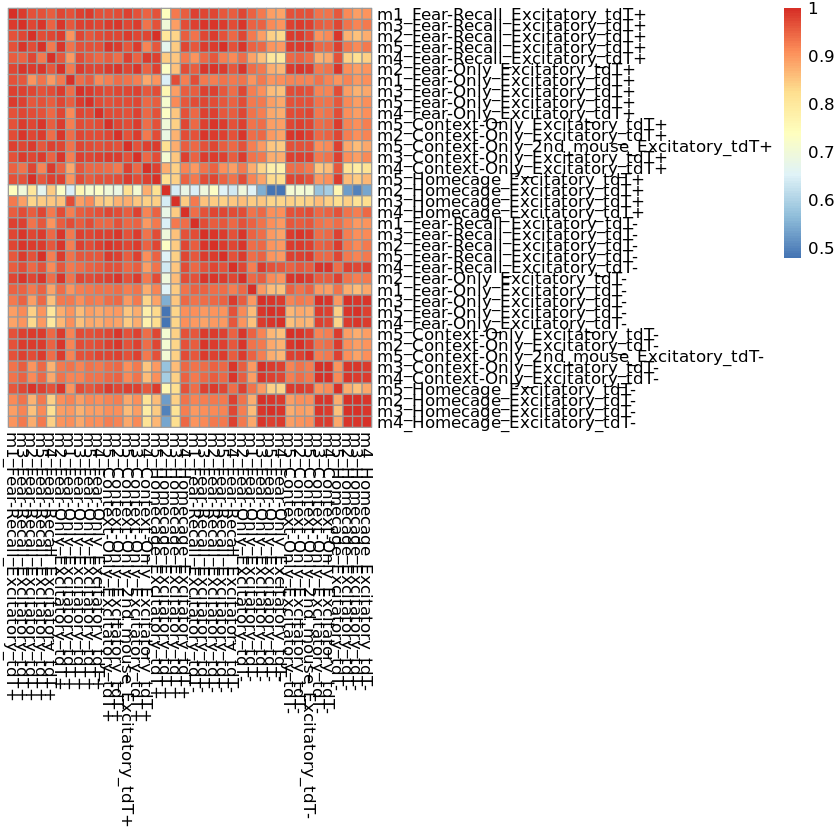

In [29]:
cortest <- pheatmap(test, cluster_cols = FALSE, cluster_rows = FALSE)

In [30]:
save_pheatmap(cortest, filename='ExcitatorySampleCorrelation.png', width = 1500, height=1500)

png 
  2

<br>
Now we filter to get rid of lowly expressed genes.
<br>

In [31]:
# look at Limma Users page 71-72 (pdf) 70-71 (document)
bulk_glut <- DGEList(counts = pseudobulk[, excitatory_pseudobulk.idx])
bulk_glut <- bulk_glut[chen.genefilter,] # filter out the genes expressed in less than 10 cells but after loading the data
# this preserves the library size which we need for calculating normfactors : https://support.bioconductor.org/p/116351/

In [32]:
# creating a variable for plotting
group <- interaction(predictors_bulk_glut$condition, predictors_bulk_glut$TRAPed)
#group <- as.character(group)
group <- gsub(pattern = '-', replacement = '', x = group)
#group <- gsub(pattern = '.', replacement = '', x = group)
group <- as.factor(group)

In [33]:
table(group)

group
ContextOnly.negative ContextOnly.positive    FearOnly.negative 
                   5                    5                    5 
   FearOnly.positive  FearRecall.negative  FearRecall.positive 
                   5                    5                    5 
   Homecage.negative    Homecage.positive 
                   4                    4 

In [34]:
predictors_bulk_glut$group <- group 

In [35]:
# Create a table of the sum of n_cells for each group
group_sum <- predictors_bulk_glut %>%
  group_by(group) %>%
  summarise(n_cells_sum = sum(n_cells))

# Create a table of the sum of the unique replicates for each group
group_unique_sum <- predictors_bulk_glut %>%
  group_by(group) %>%
  summarise(unique_replicates_sum = n_distinct(replicate))

# Combine the two tables
group_sum_unique_sum <- left_join(group_sum, group_unique_sum, by = "group")

#write.csv(group_sum_unique_sum, 'table_ofsamplesandreplicates_in_glutamatergic_cells.csv')

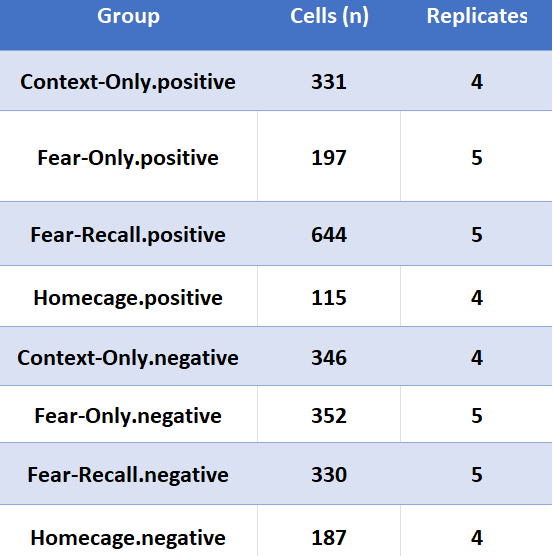

In [36]:
# now we normalize, we will try both using logCPM wth a pseudocount and the voom transformation
bulk_glut <- calcNormFactors(bulk_glut)

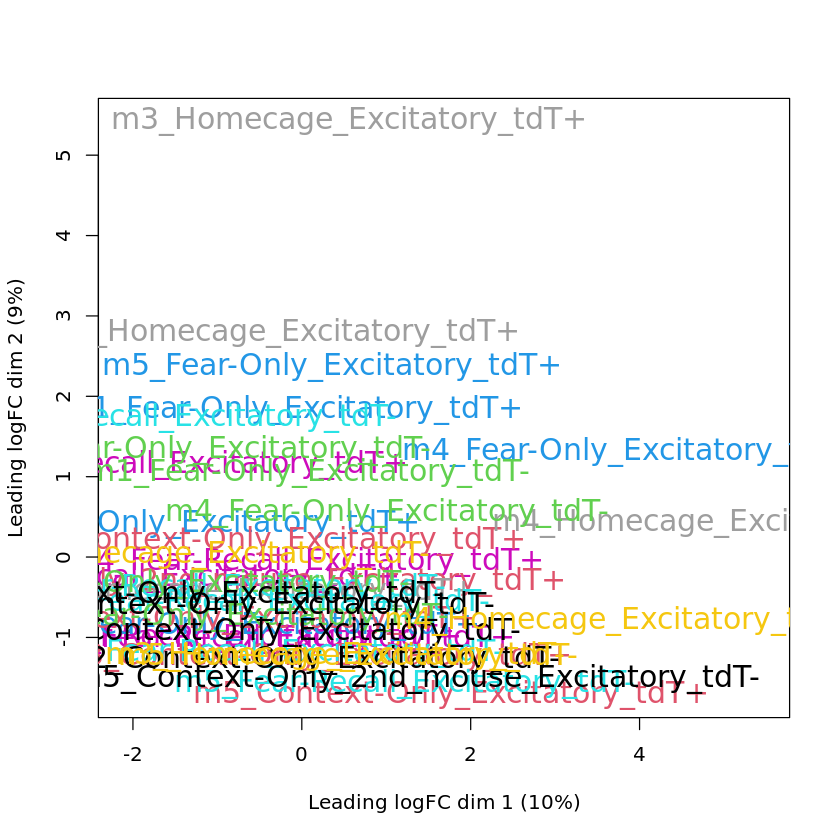

In [37]:
#logCPM trnasform before using it
plotMDS(cpm(bulk_glut, log=TRUE, prior.count=3), 
        col = as.numeric(group),
        cex = 1.5)

In [38]:
pca.raw.bulk_glut <- log2(bulk_glut$counts+0.5)
pca.bulk_glut <- PCA(t(pca.raw.bulk_glut),graph = F)

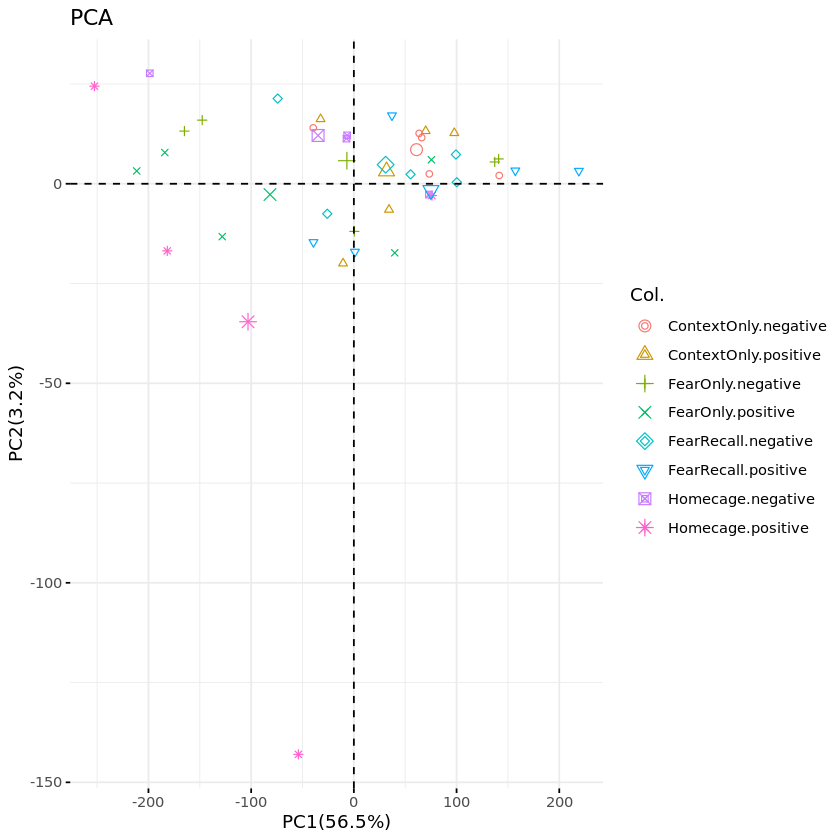

In [39]:
fviz_pca_ind(pca.bulk_glut, col.ind = group, geom ='point') +
  labs(title ="PCA", x = "PC1(56.5%)", y = "PC2(3.2%)") 

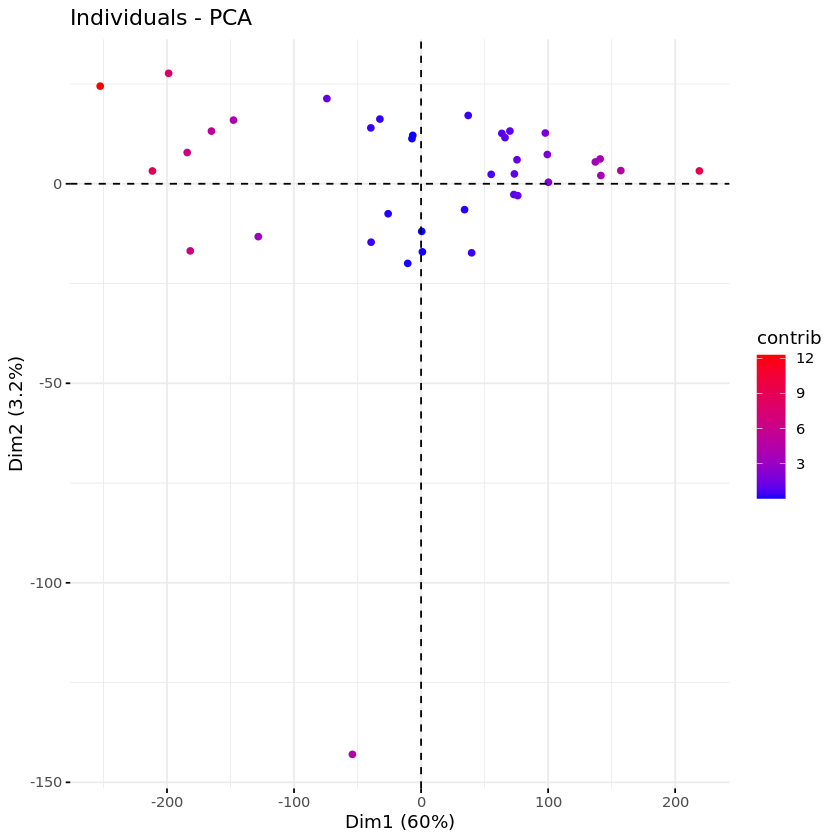

In [40]:
fviz_pca_ind(pca.bulk_glut, col.ind="contrib", geom = 'point') +
      scale_color_gradient2(low="white", mid="blue",
      high="red")

Again we see this m3_homecage as an outlier, personally I am also seeing no obvious deliniation between any of the contexts.  

Now we make the facotrs for our models, I tried using replicate and the exact conditions (like fear, exposure etc etc) but that model was overparameterized and would not fit.  The unused factors (predictors) are at the end of this document in case I find use for them.

In [41]:
# look at Limma Users page 71-72 (pdf) 70-71 (document)
bulk_glut <- DGEList(counts = pseudobulk[, excitatory_pseudobulk.idx])
bulk_glut <- bulk_glut[chen.genefilter,]

In [42]:
dim(bulk_glut)

[1] 21815    38

In [43]:
# potentially ruin this first
bulk_glut <- bulk_glut[rownames(bulk_glut) %in% hg_to_mm$Symbol_mm,] 

# filter out lowly expressed genes again
cutoff <- 100
drop <- which(apply(cpm(bulk_glut), 1, max) < cutoff)

In [44]:
bulk_glut <- bulk_glut[-drop,] 
dim(bulk_glut) # number of genes left

[1] 3815   38

In [45]:
# removeing the outlier

drop_thesesamples.idx <- !(colnames(pseudobulk[,excitatory_pseudobulk.idx]) %in% c('m3_Homecage_Excitatory_tdT+', 'm2_Homecage_Excitatory_tdT+') )

# use this line instead if you want to include the the pseudobulked samples
#drop_thesesamples.idx <- !(colnames(pseudobulk[,excitatory_pseudobulk.idx]) %in% c('derp') ) # for running with outliers included
bulk_glut_allsamps <- bulk_glut # save these for later
predictors_bulk_glut_allsamps <- predictors_bulk_glut

sum(drop_thesesamples.idx )

[1] 36

In [46]:
bulk_glut <- bulk_glut[,drop_thesesamples.idx ]
predictors_bulk_glut <- predictors_bulk_glut[drop_thesesamples.idx ,]

In [47]:
dim(predictors_bulk_glut)

[1] 36  9

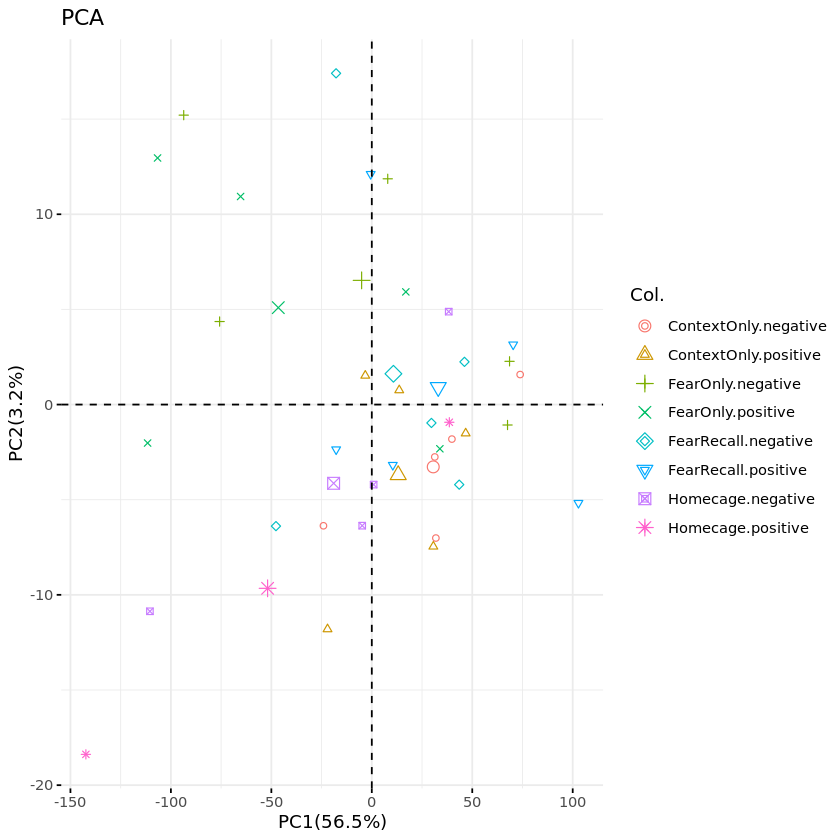

In [48]:
pca.raw.bulk_glut <- log2(bulk_glut$counts+0.5)
pca.bulk_glut <- PCA(t(pca.raw.bulk_glut),graph = F)
fviz_pca_ind(pca.bulk_glut, col.ind = predictors_bulk_glut$group, geom ='point') +
  labs(title ="PCA", x = "PC1(56.5%)", y = "PC2(3.2%)")

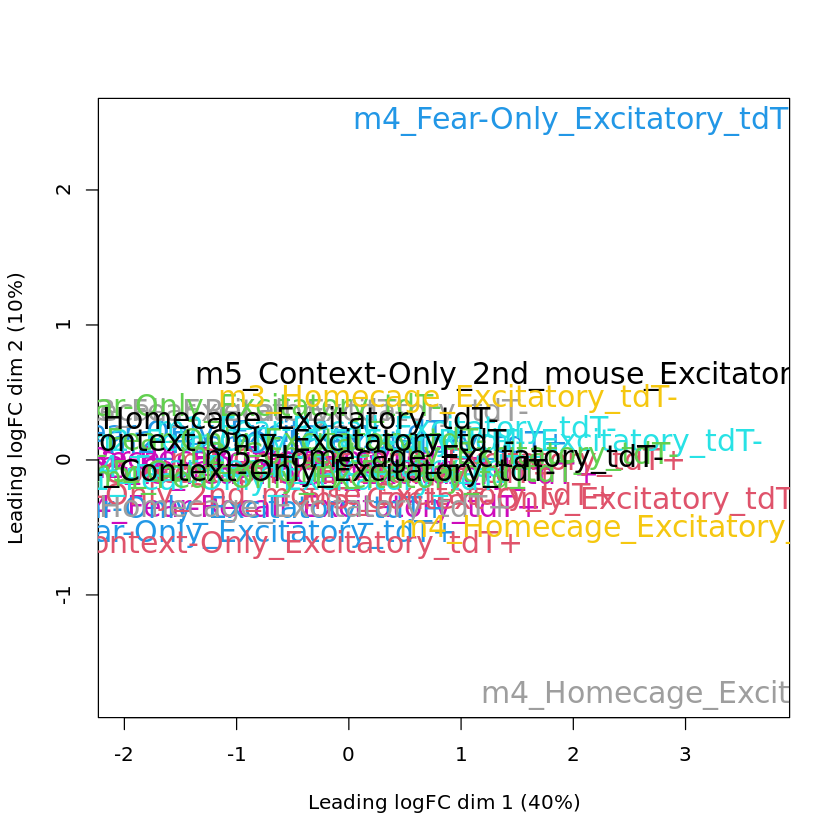

In [49]:
#logCPM trnasform before using it
plotMDS(cpm(bulk_glut, log=TRUE, prior.count=3), 
        col = as.numeric(group),
        cex = 1.5)

In [50]:
# we recalcuate normalization factors
bulk_glut <- calcNormFactors(bulk_glut)

In [51]:
length(predictors_bulk_glut$TRAPed)

[1] 36

In [52]:
predictors_bulk_glut

,celltype,condition,TRAPed,replicate,n_cells,environment_exposure,fear,recall,group
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>
m1_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m1_Fear-Recall,43,TRUE,TRUE,TRUE,FearRecall.positive
m3_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m3_Fear-Recall,222,TRUE,TRUE,TRUE,FearRecall.positive
m2_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m2_Fear-Recall,279,TRUE,TRUE,TRUE,FearRecall.positive
m5_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m5_Fear-Recall,69,TRUE,TRUE,TRUE,FearRecall.positive
m4_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m4_Fear-Recall,31,TRUE,TRUE,TRUE,FearRecall.positive
m2_Fear-Only_Excitatory_tdT+,Excitatory,Fear-Only,positive,m2_Fear-Only,94,TRUE,TRUE,FALSE,FearOnly.positive
m1_Fear-Only_Excitatory_tdT+,Excitatory,Fear-Only,positive,m1_Fear-Only,11,TRUE,TRUE,FALSE,FearOnly.positive
m3_Fear-Only_Excitatory_tdT+,Excitatory,Fear-Only,positive,m3_Fear-Only,74,TRUE,TRUE,FALSE,FearOnly.positive
m5_Fear-Only_Excitatory_tdT+,Excitatory,Fear-Only,positive,m5_Fear-Only,13,TRUE,TRUE,FALSE,FearOnly.positive


In [53]:
# prepareing factors
condition <- predictors_bulk_glut$condition
condition <- gsub(pattern = '-', replacement = '', x = condition)
condition <- as.factor(condition)
TRAPed <- predictors_bulk_glut$TRAPed
TRAPed <- gsub(pattern = '-', replacement = '', x = TRAPed)
TRAPed <- as.factor(TRAPed)

In [54]:
# This model is based on section 9.5.3 of the Limma Users Guide 
# from page 47 of the pdf, 46 of the document 
# URL here: https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf

mm_noreps.interactions <- model.matrix(~condition*TRAPed)

In [55]:
mm_noreps.interactions

,(Intercept),conditionFearOnly,conditionFearRecall,conditionHomecage,TRAPedpositive,conditionFearOnly:TRAPedpositive,conditionFearRecall:TRAPedpositive,conditionHomecage:TRAPedpositive
1,1,0,1,0,1,0,1,0
2,1,0,1,0,1,0,1,0
3,1,0,1,0,1,0,1,0
4,1,0,1,0,1,0,1,0
5,1,0,1,0,1,0,1,0
6,1,1,0,0,1,1,0,0
7,1,1,0,0,1,1,0,0
8,1,1,0,0,1,1,0,0
9,1,1,0,0,1,1,0,0
10,1,1,0,0,1,1,0,0


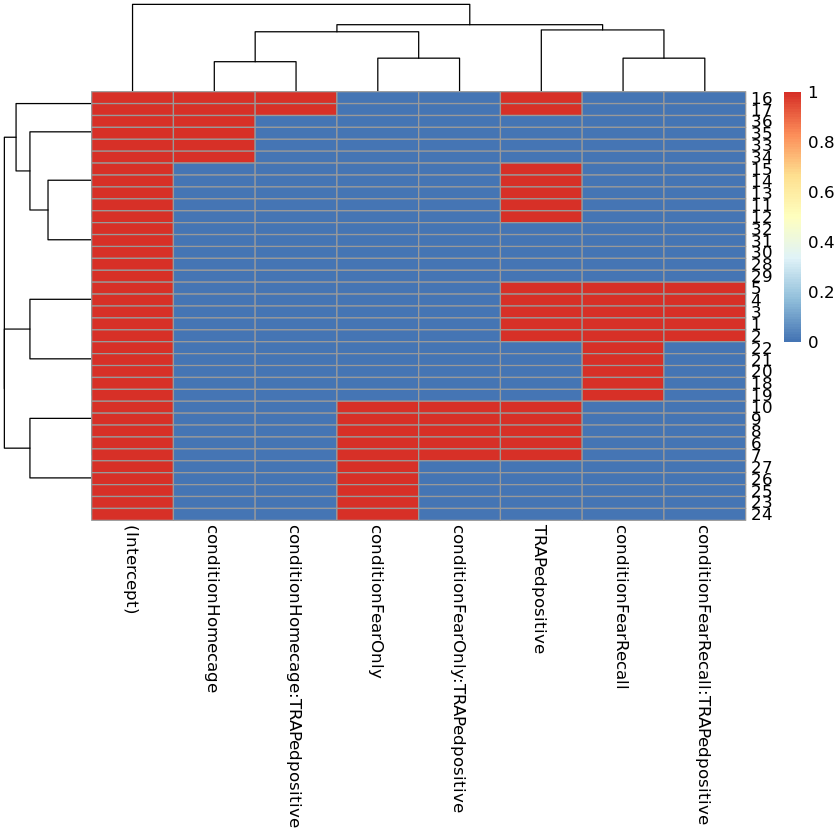

In [56]:
pheatmap(mm_noreps.interactions)

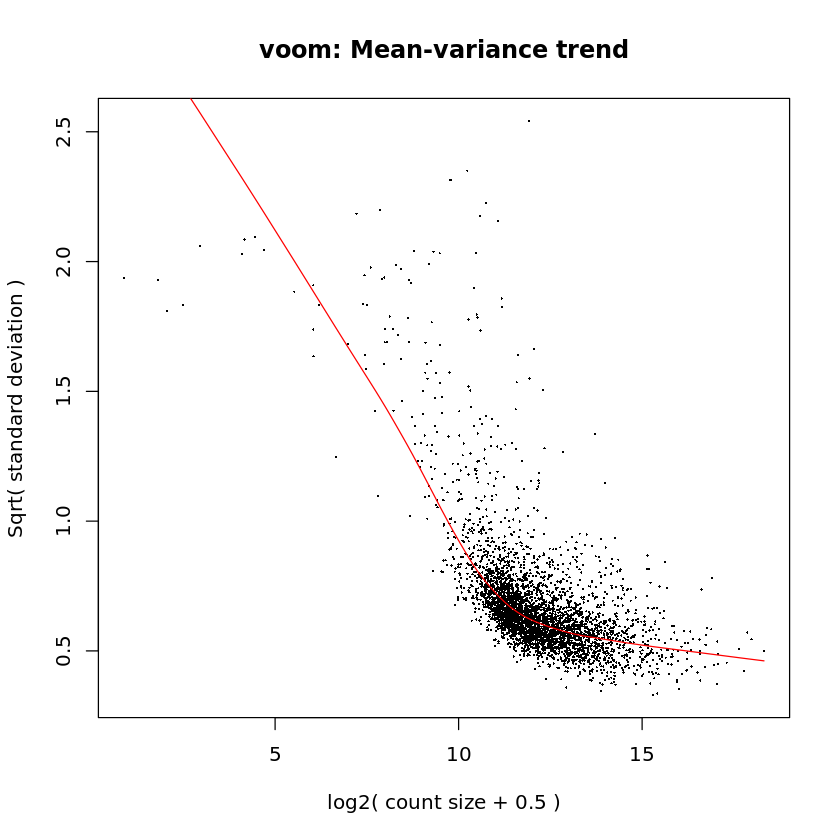

In [57]:
# make the mean varience plot (use voom)
voom.y.bulk_glut <- voom(bulk_glut, mm_noreps.interactions, plot = T)

png 
  2

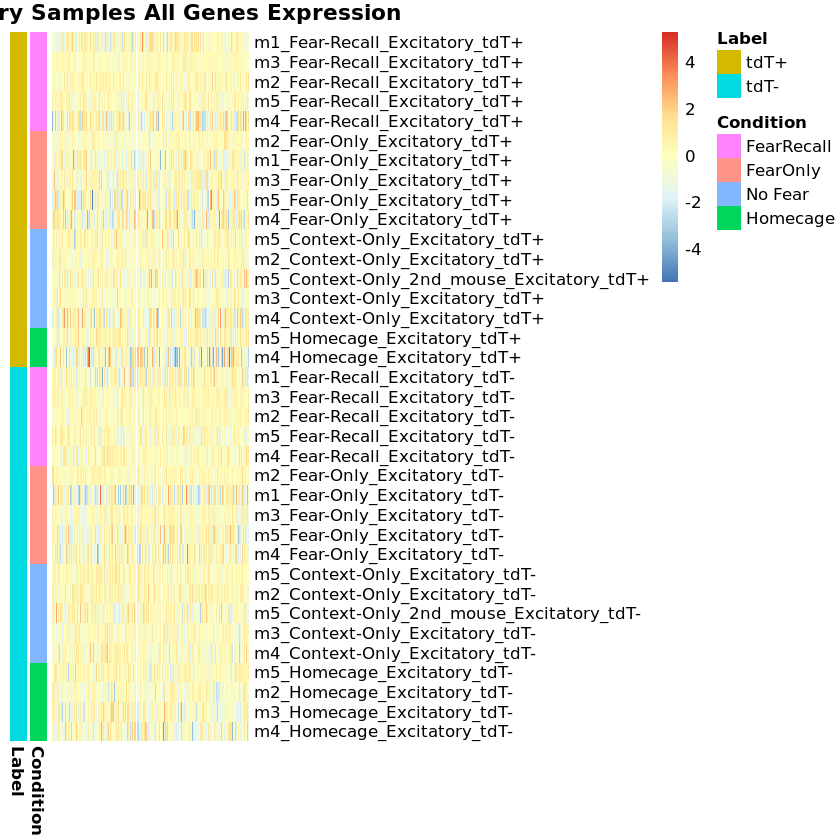

In [282]:
# one last sanity check, just looking at heatmap of expression to make sure the algorithm isn't doing somethign weird

# keep genes we used in the bulk analysis
filt <- rownames(pseudobulk) %in% rownames(bulk_glut)

# Sample Filters: 
filtered.pseudobulk <- pseudobulk[filt, excitatory_pseudobulk.idx] # remove lowly expressed genes and non excitatory samples
filtered.pseudobulk <- filtered.pseudobulk[rownames(filtered.pseudobulk) %in% hg_to_mm$Symbol_mm,] # filter to protien coding hg to mm 1 to 1 orthologs
filtered.pseudobulk <- filtered.pseudobulk[, drop_thesesamples.idx] # remove HC outliers
excitatory.libsize <- pseudobulk.librarysizes[excitatory_pseudobulk.idx] # remove nonexcitatoy for normalization library sizes (UMI count)
excitatory.libsize <- excitatory.libsize[drop_thesesamples.idx] # remove HC outliers for normalization library sizes (UMI count)

normed.filtered.pseudobulk <- pavlab.normalize(filtered.pseudobulk, UMI = excitatory.libsize ) # normalized

dat <- scale(t(normed.filtered.pseudobulk))

# this needs to be a DF even if you only have one column other pheatmap throws a fit
my_sample_row <- data.frame(Condition = condition,
                           Label = TRAPed)
my_sample_row$Label <- factor(my_sample_row$Label, levels = c('positive', 'negative'))
levels(my_sample_row$Label) <- sub("^positive$", "tdT+", levels(my_sample_row$Label))
levels(my_sample_row$Label) <- sub("^negative$", "tdT-", levels(my_sample_row$Label))
my_sample_row$Condition <- factor(my_sample_row$Condition, levels = c('FearRecall', 'FearOnly', 'ContextOnly', 'Homecage'))
levels(my_sample_row$Condition) <- sub("^ContextOnly$", "No Fear", levels(my_sample_row$Condition))
row.names(my_sample_row) <- rownames(dat)

# make a heatmap
colnames(dat) <- NULL
#rownames(dat) <- NULL

temp_hm <-pheatmap(dat, cluster_rows = FALSE, cluster_cols = FALSE, main = "Excitatory Samples All Genes Expression",
        annotation_row = my_sample_row)

save_pheatmap(temp_hm, filename='ExcitatorySamplesAllGenesExpression.png', width = 1200, height=600)

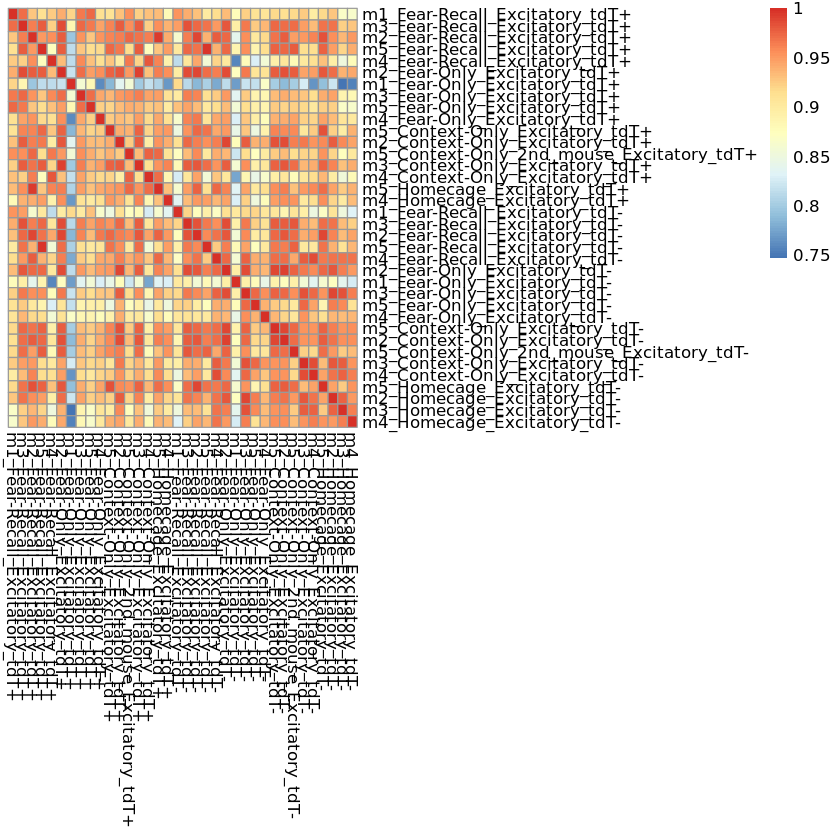

In [59]:
# produce correlation matrix before creating the DGE list
test2 <- cor(filtered.pseudobulk)
#test2 <- cor(normed.filtered.pseudobulk)

cortest2 <- pheatmap(test2, cluster_cols = FALSE, cluster_rows = FALSE)

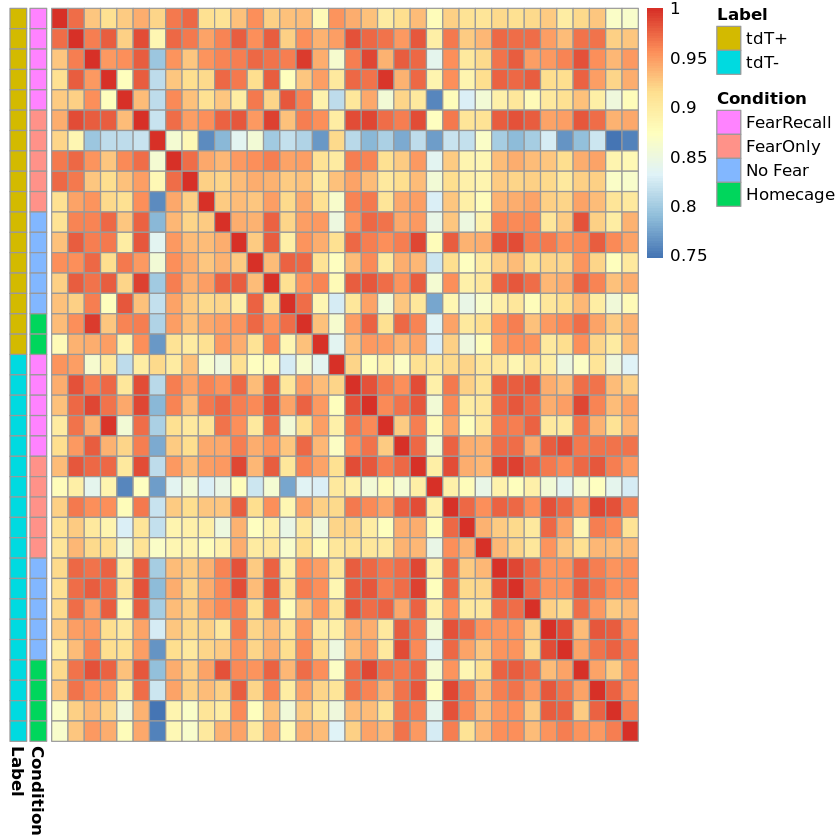

In [287]:
cortest2 <- pheatmap(test2, cluster_cols = FALSE, cluster_rows = FALSE,
                     show_colnames = FALSE, show_rownames = FALSE,
                    annotation_row = my_sample_row,
                     width = 10, height = 10, cex.col = 2,
                    legend_width = 10, legend_height = 10)

In [290]:
save_pheatmap(cortest2, filename='ExcitatorySampleCorrelation.png', width = 500, height=500)

png 
  2

keep <- filterByExpr(bulk_glut, mm_noreps.interactions) # getting rid of lowly expressed genes
bulk_glut  <- bulk_glut[keep,,keep.lib.sizes=FALSE]
bulk_glut  <- calcNormFactors(bulk_glut, method="TMM") # normalize for composition bias,

## Doing the DEG analysis.

In [61]:
#Analysis thresholds

fdr_thresh <- 0.1

### First with LogCPM.

In [62]:
# edgeR normalization is covered on page 15 of the EdgR Users Guide pdf (same document number)
# https://bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf



# this was also used https://ucdavis-bioinformatics-training.github.io/2018-June-RNA-Seq-Workshop/thursday/DE.html
#logCPM <- cpm(bulk_glut, log=TRUE, normalized.lib.sizes = TRUE, prior.count=100)
logCPM <- cpm(bulk_glut, log=TRUE,  prior.count=1) # prseudocount setting doesn't matter much, the gene filtering is much more important

In [63]:
# This model is based on section 9.5.3 of the Limma Users Guide 
# from page 47 of the pdf, 46 of the document 
# URL here: https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf

mm_noreps.interactions <- model.matrix(~condition*TRAPed)

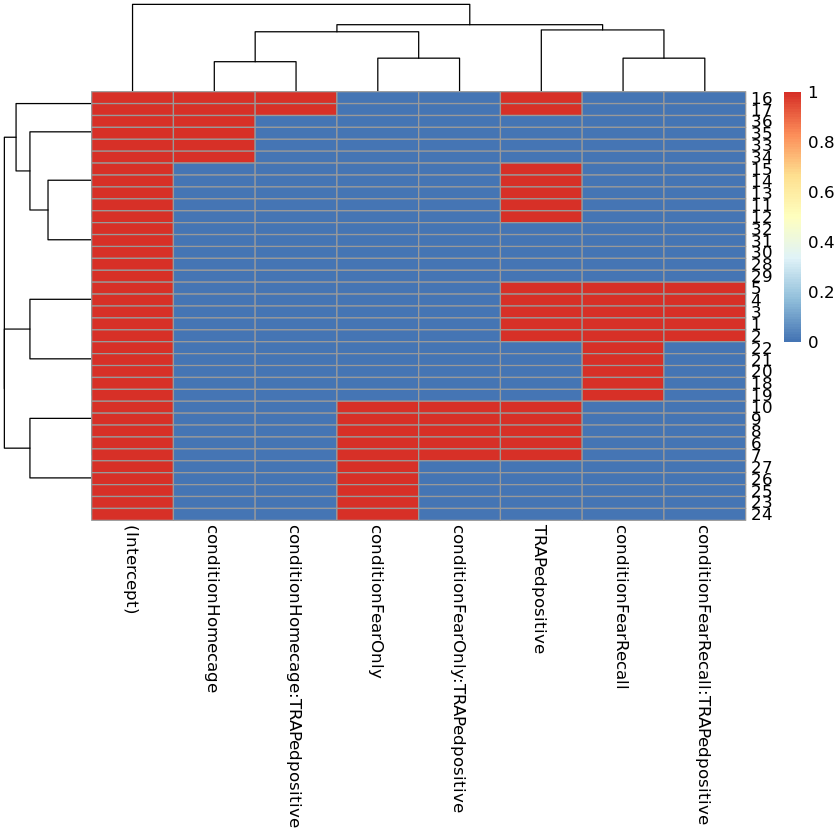

In [64]:
pheatmap(mm_noreps.interactions)

In [65]:
dim(mm_noreps.interactions)

[1] 36  8

In [66]:
fit.cpm <- lmFit(logCPM, mm_noreps.interactions)
#fit.cpm <- eBayes(fit.cpm, trend=TRUE)
#topTable(fit.cpm, coef=ncol(design))

In [67]:
fit.cpm.posothervsposFR <- contrasts.fit(fit.cpm, c(0,0,-1/3,0,-1/3,-1/3,0,1))
top.cpm.posothervsposFR <- topTable(eBayes(fit.cpm.posothervsposFR), adjust.method="BH", number = 12000)

In [68]:
dim(top.cpm.posothervsposFR)

[1] 3815    6

In [69]:
c('Serinc1', 'Serinc3', 'Ptp4a1') %in% rownames(top.cpm.posothervsposFR[top.cpm.posothervsposFR$logFC>0,])

[1]  TRUE FALSE FALSE

In [70]:
dim(top.cpm.posothervsposFR[top.cpm.posothervsposFR$adj.P.Val<fdr_thresh,])

[1] 0 6

In [71]:
print(dim(top.cpm.posothervsposFR[top.cpm.posothervsposFR$adj.P.Val<fdr_thresh,]))
head(top.cpm.posothervsposFR[top.cpm.posothervsposFR$adj.P.Val<fdr_thresh,])

[1] 0 6


logFC,AveExpr,t,P.Value,adj.P.Val,B
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


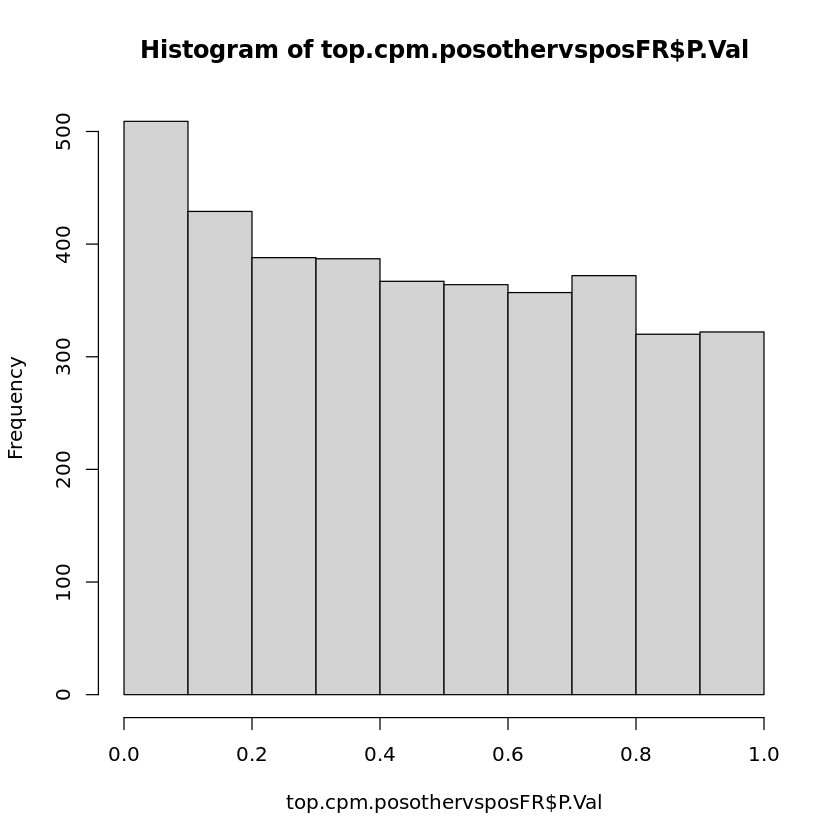

In [72]:
# 
hist(top.cpm.posothervsposFR$P.Val)

In [73]:
fit.cpm.negvspos <- contrasts.fit(fit.cpm, c(-1/4,-1/4,1/4,-1/4,1/4,1/4,-1/4,1/4))
top.cpm.negvspos <- topTable(eBayes(fit.cpm.negvspos), adjust.method="BH", number = 11000)

In [74]:
sum(top.cpm.negvspos$adj.P.Val<fdr_thresh)

[1] 3694

In [75]:
print(dim(top.cpm.negvspos[top.cpm.negvspos$adj.P.Val<fdr_thresh,]))
head(top.cpm.negvspos[top.cpm.negvspos$adj.P.Val<fdr_thresh,],10)

[1] 3694    6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cdc42,-2.606018,9.913968,-37.42178,3.411029e-27,7.081146e-24,51.85778
Rab3a,-2.749499,10.620805,-36.75533,5.855617e-27,7.081146e-24,51.34615
Syt11,-2.582775,10.034605,-36.57521,6.787322e-27,7.081146e-24,51.20610
Snrpn,-2.894665,11.662601,-36.46617,7.424531e-27,7.081146e-24,51.12093
Atp5b,-2.779084,11.203210,-33.54712,9.066576e-26,6.917798e-23,48.73076
Ttc3,-2.606268,10.569383,-31.89260,4.111653e-25,2.614326e-22,47.27359
Tpi1,-2.627167,10.577705,-31.44599,6.262673e-25,3.413157e-22,46.86641
Rab11b,-2.242367,8.502364,-30.90882,1.046712e-24,4.991506e-22,46.36847
Aldoa,-2.839173,12.390394,-30.31016,1.873951e-24,7.166988e-22,45.80269


In [76]:
sum(top.cpm.negvspos$logFC>0)

[1] 13

In [77]:
print(dim(top.cpm.negvspos[top.cpm.negvspos$adj.P.Val<fdr_thresh&top.cpm.negvspos$logFC>0,]))
head(top.cpm.negvspos[top.cpm.negvspos$adj.P.Val<fdr_thresh&top.cpm.negvspos$logFC>0,])

[1] 0 6


logFC,AveExpr,t,P.Value,adj.P.Val,B
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


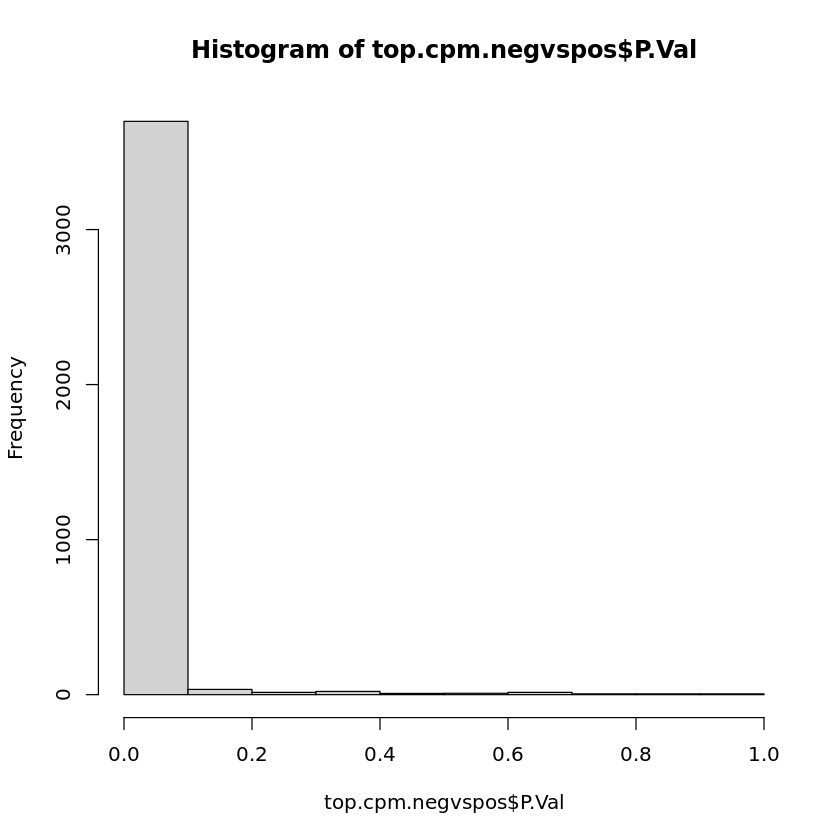

In [78]:
hist(top.cpm.negvspos$P.Val)

In [79]:
fit.cpm.FRvsALL <- contrasts.fit(fit.cpm, c(-1/7,-1/7,-1/7,-1/7,-1/7,-1/7,-1/7,1))
top.cpm.FRvsALL <- topTable(eBayes(fit.cpm.FRvsALL), adjust.method="BH", number = 11000)

In [80]:
print(dim(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh,]))
print(dim(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,]))
head(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,],10)

[1] 2249    6
[1] 6 6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Slitrk3,2.311843,4.209960,2.977643,0.005624842,0.01641834,-2.678068
Map7,1.988344,4.681538,2.655789,0.012428011,0.03051021,-3.405432
Crtac1,2.207313,5.736012,2.588369,0.014597841,0.03416894,-3.551416
Ice1,1.782203,4.471881,2.230033,0.033191651,0.06382366,-4.285178
Ablim2,1.455634,5.699953,2.193427,0.035973050,0.06790558,-4.355841
Adcyap1r1,1.510398,4.901439,2.036583,0.050388997,0.08862795,-4.648836


In [81]:
cpm.remotememorymarkers <- rownames(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,])
cpm.remotememorymarkers

[1] "Slitrk3"   "Map7"      "Crtac1"    "Ice1"      "Ablim2"    "Adcyap1r1"

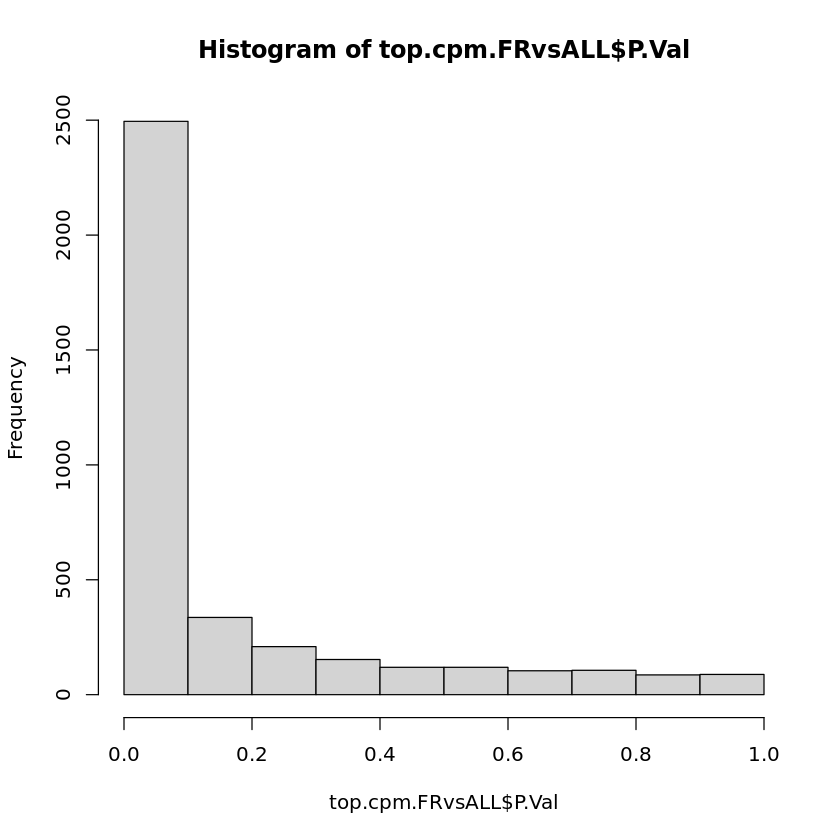

In [82]:
hist(top.cpm.FRvsALL$P.Val)

###  Now with the Voom transform.

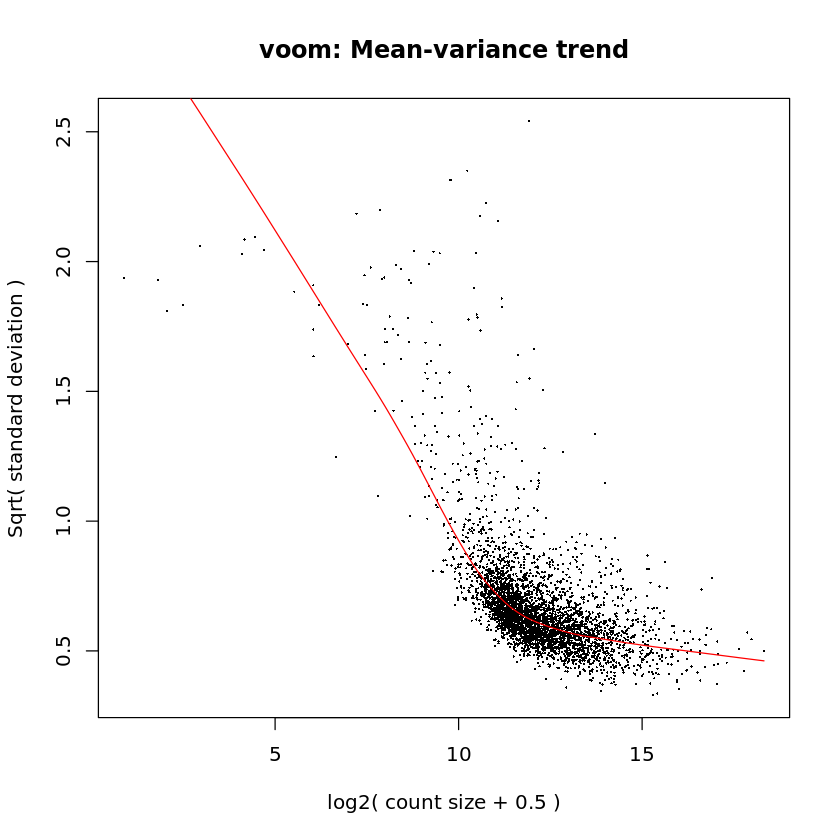

In [83]:
# Fro user guide on page 72 section 15: "When the library sizes are quite variable between samples,
# then the voom approach is theoretically more powerful than limma-trend."
# As single cell is notoriously variable (drop out etc) this seems appropriate
#voom.y.bulk_glut <- voom(bulk_glut, mm_noreps.interactions, plot = T) # this gives an error
voom.y.bulk_glut <- voom(bulk_glut, mm_noreps.interactions, plot = T) # this gives an error

I tried controlling for replicates but that seems to produce over parameterized models.  Paul asked me to do positives vs negatives as well as the.  This explanation of 2x4 design will help understand.

In [84]:
fit.voom <- lmFit(voom.y.bulk_glut, mm_noreps.interactions)
fit.voom.posothervsposFR <- contrasts.fit(fit.voom, c(0,0,-1/3,0,-1/3,-1/3,0,1))
top.voom.posothervsposFR <- topTable(eBayes(fit.voom.posothervsposFR), adjust.method="BH", number = 11000)

In [85]:
print(dim(top.voom.posothervsposFR[top.voom.posothervsposFR$adj.P.Val<fdr_thresh,]))
head(top.voom.posothervsposFR[top.voom.posothervsposFR$adj.P.Val<fdr_thresh,])

[1] 1 6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Slitrk3,2.993004,4.210995,4.874191,2.503118e-05,0.09549396,0.8429153


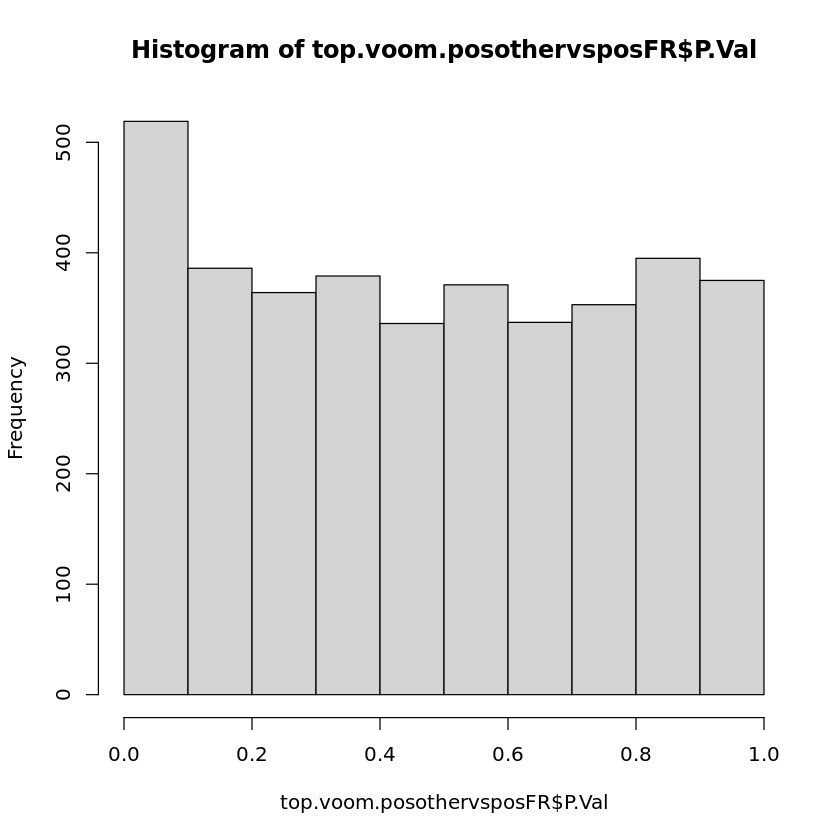

In [86]:
hist(top.voom.posothervsposFR$P.Val)

In [87]:
fit.voom.negvspos <- contrasts.fit(fit.voom, c(-1/4,-1/4,1/4,-1/4,1/4,1/4,-1/4,1/4))
top.voom.negvspos <- topTable(eBayes(fit.voom.negvspos), adjust.method="BH", number = 11000)

In [88]:
sum(top.voom.negvspos$adj.P.Val<fdr_thresh)

[1] 3700

In [89]:
print(dim(top.voom.negvspos[top.voom.negvspos$adj.P.Val<fdr_thresh,]))
head(top.voom.negvspos[top.voom.negvspos$adj.P.Val<fdr_thresh,],10)

[1] 3700    6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Snrpn,-2.887035,11.662606,-42.79060,3.857837e-31,1.471765e-27,61.11546
Syt11,-2.596003,10.034621,-41.48356,1.085715e-30,1.790478e-27,60.01370
Cdc42,-2.568091,9.913985,-40.98763,1.621062e-30,1.790478e-27,59.60634
Rab3a,-2.736422,10.620814,-40.80749,1.877304e-30,1.790478e-27,59.51589
Atp5b,-2.798824,11.203216,-38.02875,1.960846e-29,1.496125e-26,57.23494
Tpi1,-2.654683,10.577716,-36.27740,9.372719e-29,5.959487e-26,55.67338
Ttc3,-2.596141,10.569393,-35.43667,2.037921e-28,1.110667e-25,54.90632
Aldoa,-2.864490,12.390397,-34.53913,4.761961e-28,2.270860e-25,54.07781
Hsp90ab1,-3.194985,11.926669,-33.11652,1.909848e-27,7.510326e-25,52.69059


In [90]:
print(dim(top.voom.negvspos[top.voom.negvspos$adj.P.Val<fdr_thresh&top.voom.negvspos$logFC>0,]))
head(top.voom.negvspos[top.voom.negvspos$adj.P.Val<fdr_thresh&top.voom.negvspos$logFC>0,])

[1] 0 6


logFC,AveExpr,t,P.Value,adj.P.Val,B
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


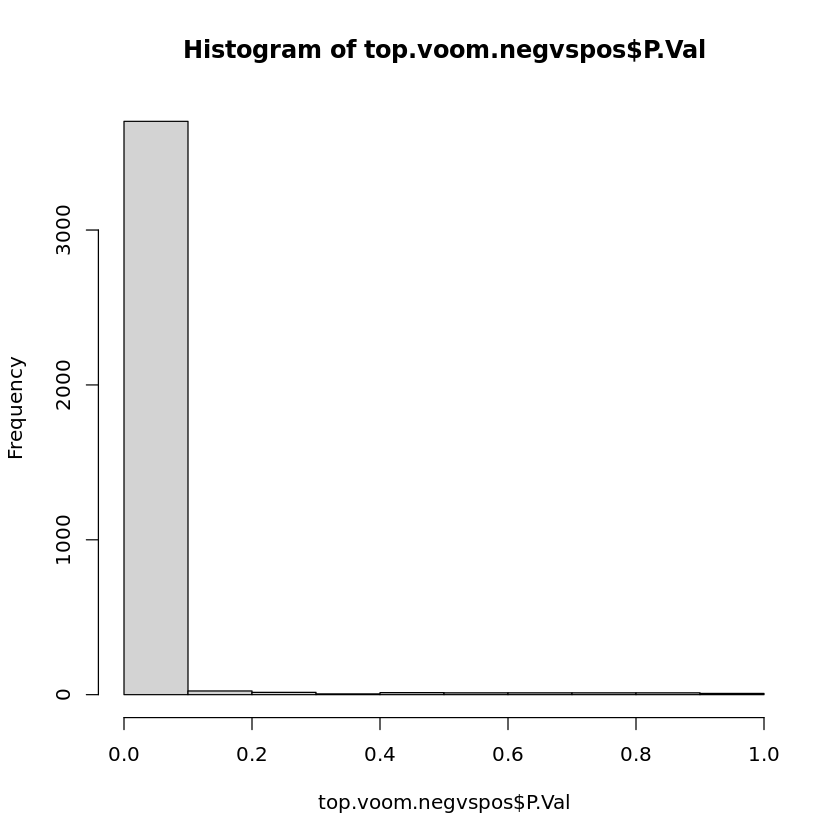

In [91]:
hist(top.voom.negvspos$P.Val)

In [92]:
fit.voom.FRvsALL <- contrasts.fit(fit.voom, c(-1/7,-1/7,-1/7,-1/7,-1/7,-1/7,-1/7,1))
top.voom.FRvsALL <- topTable(eBayes(fit.voom.FRvsALL), adjust.method="BH", number = 11000)

In [93]:
print(dim(top.voom.FRvsALL[top.voom.FRvsALL$adj.P.Val<fdr_thresh,]))
print(dim(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),]))
head(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),],16)

[1] 2416    6
[1] 16  6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Slitrk3,2.3396414,4.210995,3.832181,0.0005228169,0.002593174,-0.2078125
Tnnc1,4.3161189,4.889123,3.087974,0.0039984618,0.011815749,-1.9935615
Krt12,3.9055876,5.269743,2.925045,0.0060962471,0.016139613,-2.3773907
Ajap1,2.9604085,4.165779,2.772665,0.0089601190,0.021607367,-2.5620493
Slc16a2,2.1630765,4.197413,2.690383,0.0109870991,0.025403505,-2.7305794
Car4,1.4764988,4.607824,2.573351,0.0146093523,0.031994649,-3.1011447
Slc2a13,1.5827201,4.729929,2.513533,0.0168590650,0.035573746,-3.1202792
B9d1,1.4005853,4.614100,2.281327,0.0289178861,0.053841745,-3.5177812
Cpne7,1.9897544,5.275490,2.201088,0.0346237528,0.061988891,-3.7155372


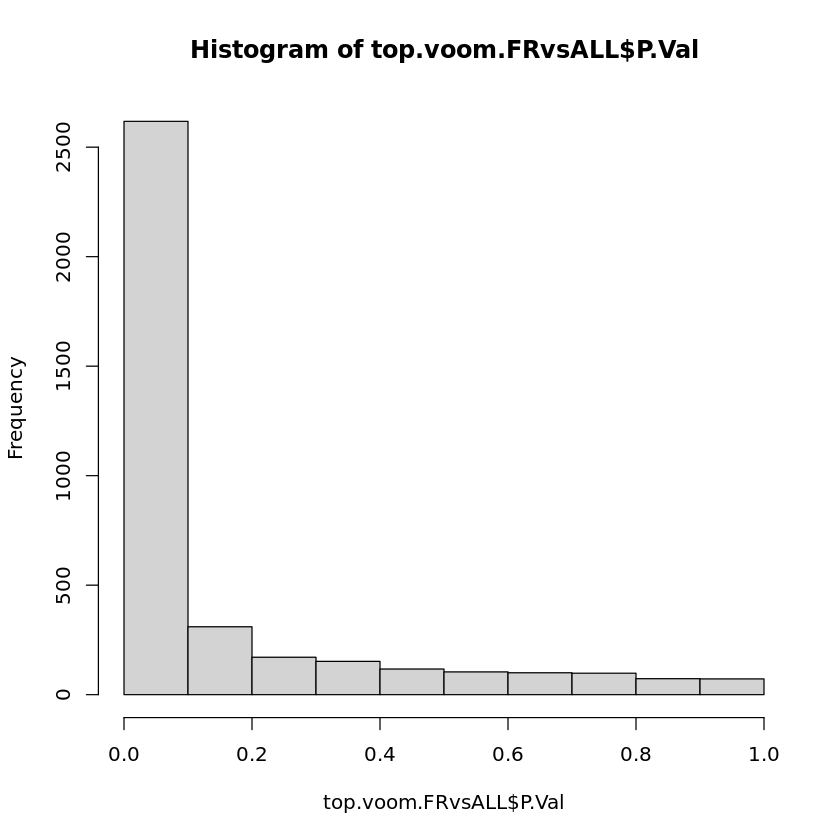

In [94]:
hist(top.voom.FRvsALL$P.Val)

In [95]:
voom.remotememorymarkers <- rownames(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),])
voom.remotememorymarkers

[1] "Slitrk3"   "Tnnc1"     "Krt12"     "Ajap1"     "Slc16a2"   "Car4"     
 [7] "Slc2a13"   "B9d1"      "Cpne7"     "Ddit4l"    "Adcyap1r1" "Tenm4"    
[13] "Cpne8"     "Kcnh1"     "Stum"      "Gpr83"

## Visualizing our DEGs

Do we really think there is this 2000 percent increase in gene expression that we are seeing in the logFC for these genes?  Lets, find out.  First we can do it at the sample level then move on to the cell level.

In [96]:
test <- DGEList(counts = pseudobulk[, excitatory_pseudobulk.idx])

In [97]:
# find the genes in the intersection of the two normalization procedures
excitatory.remotememorymarkers <- intersect(rownames(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),]),
          rownames(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,]) )

excitatory.remotememorymarkers

[1] "Slitrk3"   "Adcyap1r1"

In [98]:
excitatory.remotememorymarkers <- union(rownames(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),]),
          rownames(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,]) )


excitatory.remotememorymarkers

[1] "Slitrk3"   "Tnnc1"     "Krt12"     "Ajap1"     "Slc16a2"   "Car4"     
 [7] "Slc2a13"   "B9d1"      "Cpne7"     "Ddit4l"    "Adcyap1r1" "Tenm4"    
[13] "Cpne8"     "Kcnh1"     "Stum"      "Gpr83"     "Map7"      "Crtac1"   
[19] "Ice1"      "Ablim2"

In [99]:
test <- intersect(upreg_rem_markers,excitatory.remotememorymarkers)
print(test)

character(0)


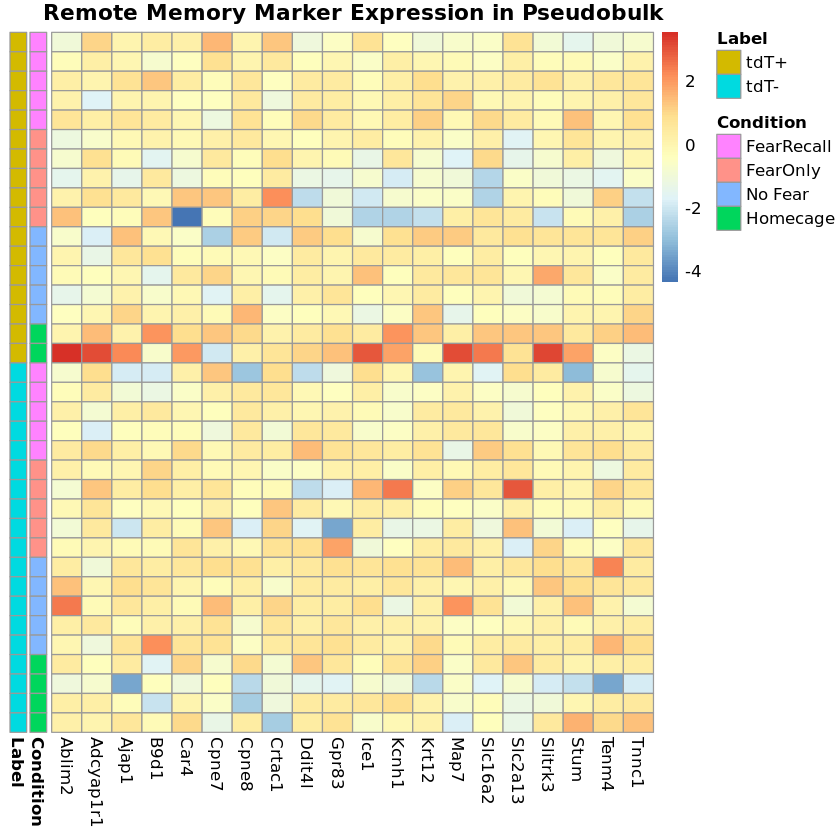

In [306]:
# one last sanity check, just looking at heatmap of expression to make sure the algorithm isn't doing somethign weird

#excitatory.remotememorymarkers <- 'Slitrk3'

# keep genes we used in the bulk analysis
filt <- rownames(pseudobulk) %in% rownames(bulk_glut)

# Sample Filters: 
filtered.pseudobulk <- pseudobulk[filt, excitatory_pseudobulk.idx] # remove lowly expressed genes and non excitatory samples
filtered.pseudobulk <- filtered.pseudobulk[rownames(filtered.pseudobulk) %in% hg_to_mm$Symbol_mm,] # filter to protien coding hg to mm 1 to 1 orthologs
filtered.pseudobulk <- filtered.pseudobulk[, drop_thesesamples.idx] # remove HC outliers
excitatory.libsize <- pseudobulk.librarysizes[excitatory_pseudobulk.idx] # remove nonexcitatoy for normalization library sizes (UMI count)
excitatory.libsize <- excitatory.libsize[drop_thesesamples.idx] # remove HC outliers for normalization library sizes (UMI count)

normed.filtered.pseudobulk <- pavlab.normalize(filtered.pseudobulk, UMI = excitatory.libsize ) # normalized

dat <- scale(t(normed.filtered.pseudobulk))
#dat <- t(normed.filtered.pseudobulk)

my_sample_row <- data.frame(Condition = condition,
                           Label = TRAPed)
my_sample_row$Label <- factor(my_sample_row$Label, levels = c('positive', 'negative'))
levels(my_sample_row$Label) <- sub("^positive$", "tdT+", levels(my_sample_row$Label))
levels(my_sample_row$Label) <- sub("^negative$", "tdT-", levels(my_sample_row$Label))
my_sample_row$Condition <- factor(my_sample_row$Condition, levels = c('FearRecall', 'FearOnly', 'ContextOnly', 'Homecage'))
levels(my_sample_row$Condition) <- sub("^ContextOnly$", "No Fear", levels(my_sample_row$Condition))
row.names(my_sample_row) <- rownames(dat)

# make a heatmap
dat <- dat[, colnames(dat) %in% excitatory.remotememorymarkers]

#rownames(dat) <- NULL

temp_hm <-pheatmap(dat, cluster_rows = FALSE, cluster_cols = FALSE, 
                   main = "Remote Memory Marker Expression in Pseudobulk",
                   show_rownames = FALSE, annotation_row = my_sample_row)

In [308]:
save_pheatmap(temp_hm, filename='RemoteMemoryMarkersExpressionSampleLevel.png', width = 600, height=600)

png 
  2

In [102]:
chen.markers <- c('Serinc1', 'Serinc3', 'Ptp4a1')
chen.markers[chen.markers%in% hg_to_mm$Symbol_mm]

[1] "Serinc1" "Serinc3" "Ptp4a1"

In [299]:
chen.markers <- c('Serinc1', 'Serinc3', 'Ptp4a1')

filt <- rownames(pseudobulk) %in% rownames(bulk_glut)

# Sample Filters: 
filtered.pseudobulk <- pseudobulk[, excitatory_pseudobulk.idx] # remove lowly expressed genes and non excitatory samples
filtered.pseudobulk <- filtered.pseudobulk[rownames(filtered.pseudobulk) %in% hg_to_mm$Symbol_mm,] # filter to protien coding hg to mm 1 to 1 orthologs
filtered.pseudobulk <- filtered.pseudobulk[, drop_thesesamples.idx] # remove HC outliers
excitatory.libsize <- pseudobulk.librarysizes[excitatory_pseudobulk.idx] # remove nonexcitatoy for normalization library sizes (UMI count)
excitatory.libsize <- excitatory.libsize[drop_thesesamples.idx] # remove HC outliers for normalization library sizes (UMI count)

normed.filtered.pseudobulk <- pavlab.normalize(filtered.pseudobulk, UMI = excitatory.libsize ) # normalized

dat <- scale(t(normed.filtered.pseudobulk))
#dat <- t(normed.filtered.pseudobulk)

my_sample_row <- data.frame(Condition = condition,
                           Label = TRAPed)
my_sample_row$Label <- factor(my_sample_row$Label, levels = c('positive', 'negative'))
levels(my_sample_row$Label) <- sub("^positive$", "tdT+", levels(my_sample_row$Label))
levels(my_sample_row$Label) <- sub("^negative$", "tdT-", levels(my_sample_row$Label))
my_sample_row$Condition <- factor(my_sample_row$Condition, levels = c('FearRecall', 'FearOnly', 'ContextOnly', 'Homecage'))
levels(my_sample_row$Condition) <- sub("^ContextOnly$", "No Fear", levels(my_sample_row$Condition))
row.names(my_sample_row) <- rownames(dat)

# make a heatmap
dat <- dat[, colnames(dat) %in% chen.markers ]

In [292]:
chen.markers[chen.markers %in% colnames(dat)]

[1] "Serinc1" "Serinc3" "Ptp4a1"

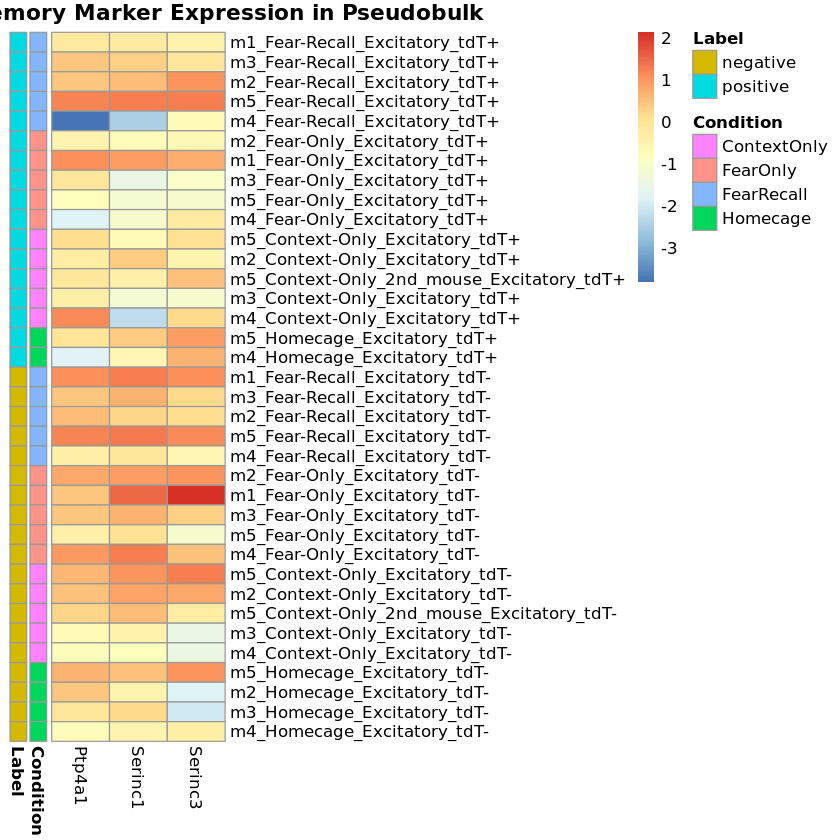

In [105]:
#rownames(dat) <- NULL



temp_hm <-pheatmap(dat, cluster_rows = FALSE, cluster_cols = FALSE, main = "Chen Remote Memory Marker Expression in Pseudobulk",
        annotation_row = my_sample_row)

In [106]:
save_pheatmap(temp_hm, filename='ChenMarkersPSeudobulkheatmap.png', width = 600, height=600)

png 
  2

In [303]:
# making heat map of only comparisson between 
samples.of.interest <- c('m1_Fear-Recall_Excitatory_tdT+','m2_Fear-Recall_Excitatory_tdT+',
                      'm3_Fear-Recall_Excitatory_tdT+','m4_Fear-Recall_Excitatory_tdT+',
                      'm5_Fear-Recall_Excitatory_tdT+','m1_Fear-Only_Excitatory_tdT-',
                      'm3_Fear-Only_Excitatory_tdT-','m5_Fear-Only_Excitatory_tdT-',
                      'm4_Fear-Only_Excitatory_tdT-','m5_Context-Only_Excitatory_tdT-')

FRposvsneg_dat <- dat[samples.of.interest,]
my_sample_row.FRposvsneg <- data.frame( 'Label' = my_sample_row[rownames(my_sample_row) %in% samples.of.interest,2])
rownames(my_sample_row.FRposvsneg) <- rownames(FRposvsneg_dat)

In [108]:
show_rownames = FALSE,
                    annotation_row = my_sample_row,
                     width = 10, height = 10, cex.col = 2,
                    legend_width = 10, legend_height = 10

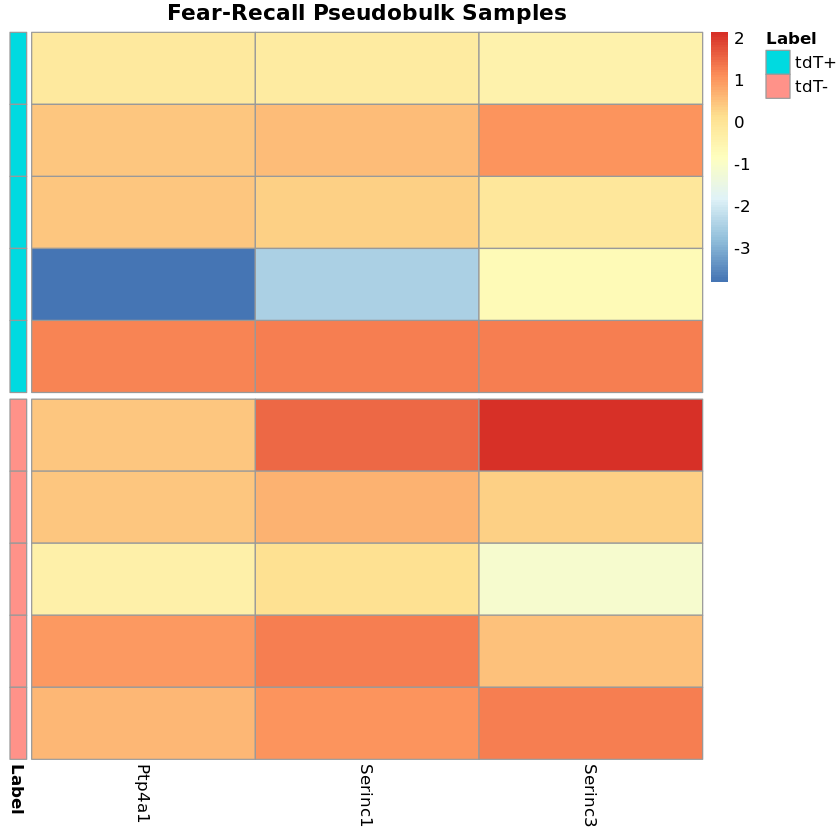

In [304]:
temp_hm.FRposvsneg <-pheatmap(FRposvsneg_dat, cluster_rows = FALSE, cluster_cols = FALSE,
                              main = "Fear-Recall Pseudobulk Samples",
                              show_rownames = FALSE, annotation_row = my_sample_row.FRposvsneg,
                              gaps_row = 5, cex.col = 12, font.main = 4, font.col = 2)

In [305]:
save_pheatmap(temp_hm.FRposvsneg, filename='ChenMarkersPseudobulkheatmap_FRsamplesonly.png', width = 600, height=600)

png 
  2

#### Keeping the homecage samples destroys all DEGs at these thresholds

I also redid the analysis keeping in the HC mice I removed as they seemed to possibly be outliers.  Doing this results in no upregulated DEGs in the logCPM transform but voom transform yeild two genes *Serinc5* and *Erap1*, which if plotted do not show a distinct pattern either.

In [110]:
# make a heat map of the best genes on a t test of just the top genes from one FRpost vs FRneg, then see 
# if the cells the classifier for this find look like this

# also take one of their DEGs  and just start plotting the gene expression


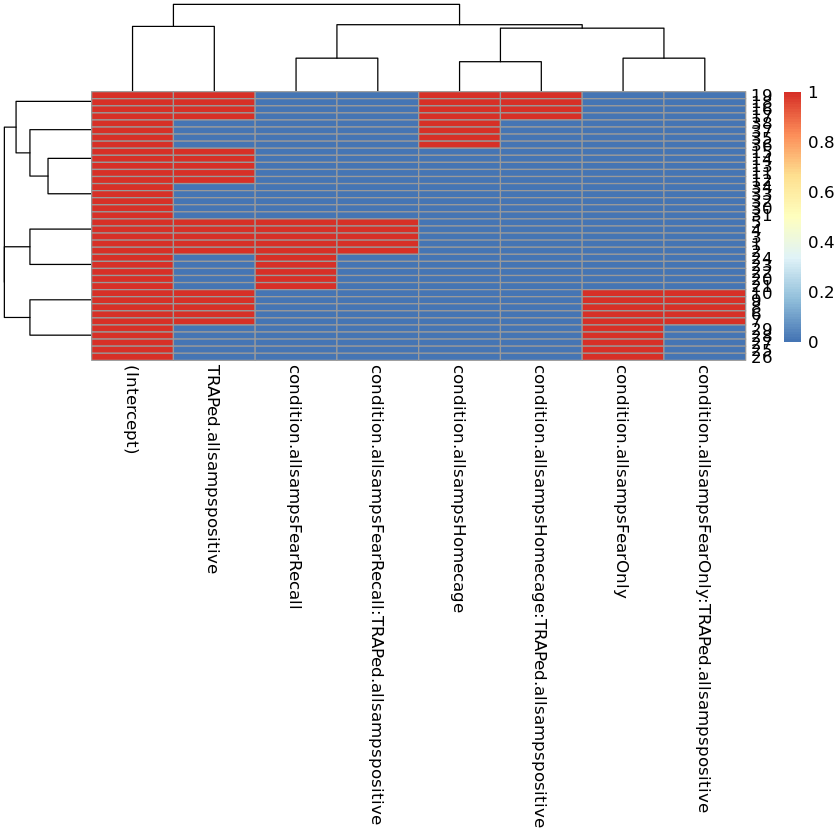

In [111]:
# prepareing factors
condition.allsamps <- predictors_bulk_glut_allsamps$condition
condition.allsamps <- gsub(pattern = '-', replacement = '', x = condition.allsamps)
condition.allsamps <- as.factor(condition.allsamps)
TRAPed.allsamps <- predictors_bulk_glut_allsamps$TRAPed
TRAPed.allsamps <- gsub(pattern = '-', replacement = '', x = TRAPed.allsamps)
TRAPed.allsamps <- as.factor(TRAPed.allsamps)


# making design matrix
mm_noreps.interactions_allsamps <- model.matrix(~condition.allsamps*TRAPed.allsamps)
pheatmap(mm_noreps.interactions_allsamps)

In [112]:
dim(mm_noreps.interactions_allsamps)

[1] 38  8

In [113]:
#logcpm
logCPM.allsamps <- cpm(bulk_glut_allsamps, log=TRUE,  prior.count=1)
fit.cpm.allsamps <- lmFit(logCPM.allsamps, mm_noreps.interactions_allsamps)
fit.cpm.FRvsALL.allsamps <- contrasts.fit(fit.cpm.allsamps, c(-1/7,-1/7,-1/7,1,-1/7,-1/7,-1/7,-1/7))
top.cpm.FRvsALL.allsamps <- topTable(eBayes(fit.cpm.FRvsALL.allsamps), adjust.method="BH", number = 11000)

[1] 0 6


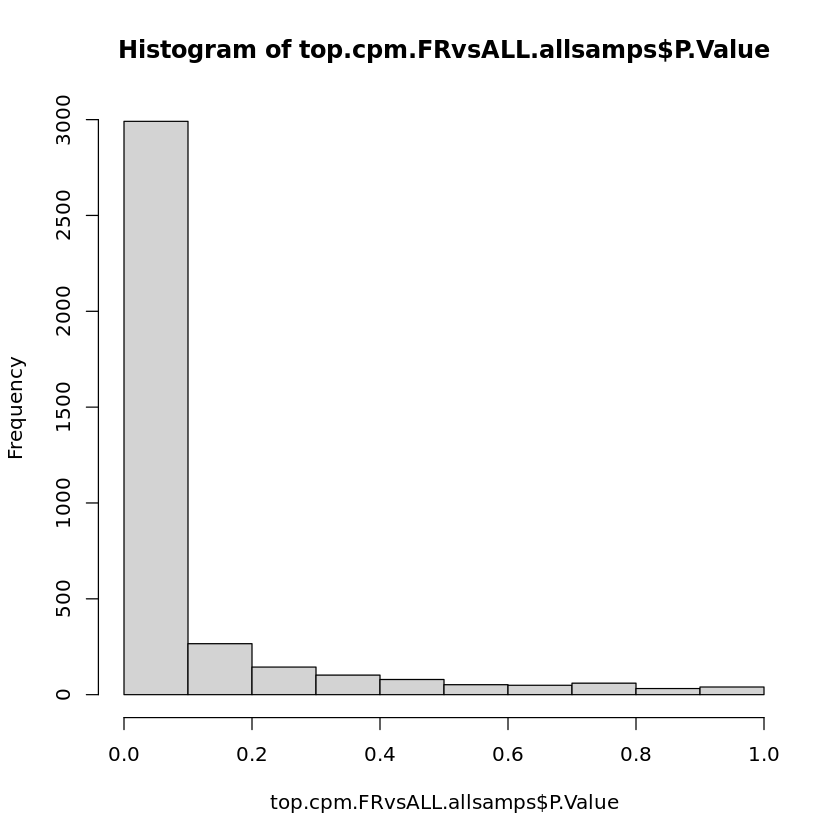

In [114]:
print(dim(top.cpm.FRvsALL.allsamps[(top.cpm.FRvsALL.allsamps$logFC>0)&(top.cpm.FRvsALL.allsamps$adj.P.Val<fdr_thresh),]))
hist(top.cpm.FRvsALL.allsamps$P.Value)

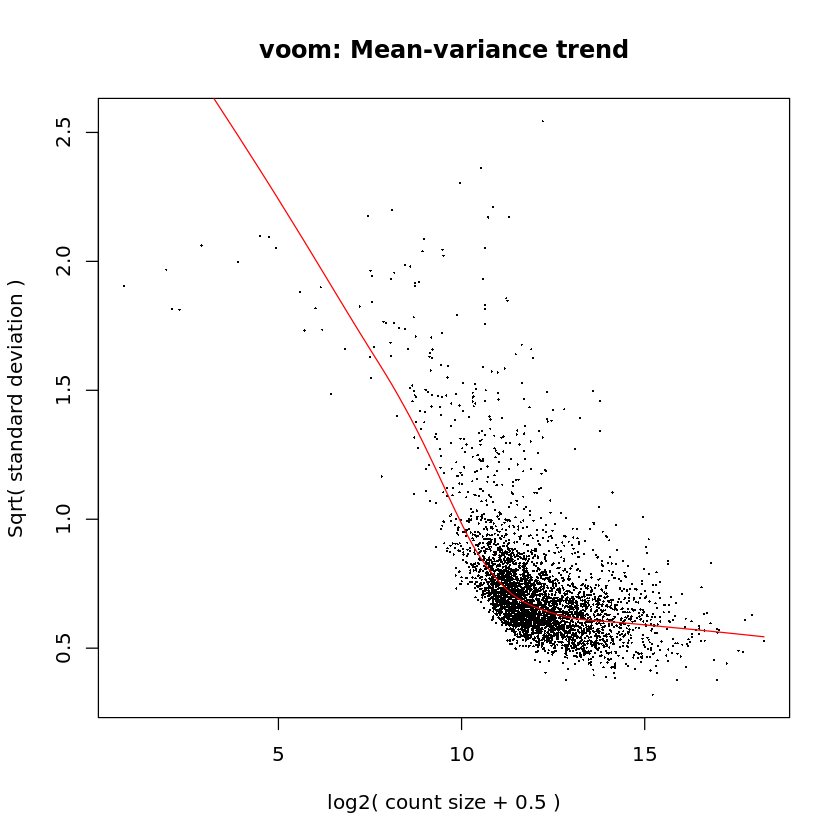

In [115]:
#voom
voom.y.bulk_glut.allsamps <- voom(bulk_glut_allsamps, mm_noreps.interactions_allsamps, plot = T)

In [116]:
fit.voom.allsamps <- lmFit(voom.y.bulk_glut.allsamps, mm_noreps.interactions_allsamps)
fit.voom.FRvsALL.allsamps <- contrasts.fit(fit.voom.allsamps, c(0,-1,1,0,0,0,0,0))
top.voom.FRvsALL.allsamps <- topTable(eBayes(fit.voom.FRvsALL.allsamps), adjust.method="BH", number = 11000)

In [117]:
head(top.voom.FRvsALL.allsamps)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Entpd6,-0.9219714,6.504844,-4.561900,5.614653e-05,0.2141990,1.0480976
Paf1,-0.8016426,6.360551,-4.167083,1.829076e-04,0.2426201,0.1945695
Zmym3,0.7695832,5.555040,4.152816,1.907890e-04,0.2426201,-0.1007643
Slc39a6,-0.9931235,5.845072,-3.920629,3.768985e-04,0.2875736,-0.4491763
Magoh,0.6883489,5.620375,4.004936,2.947374e-04,0.2811058,-0.4695371
Spryd7,-0.4810628,6.873366,-3.569375,1.030568e-03,0.4388913,-0.9872579


[1] 0 6


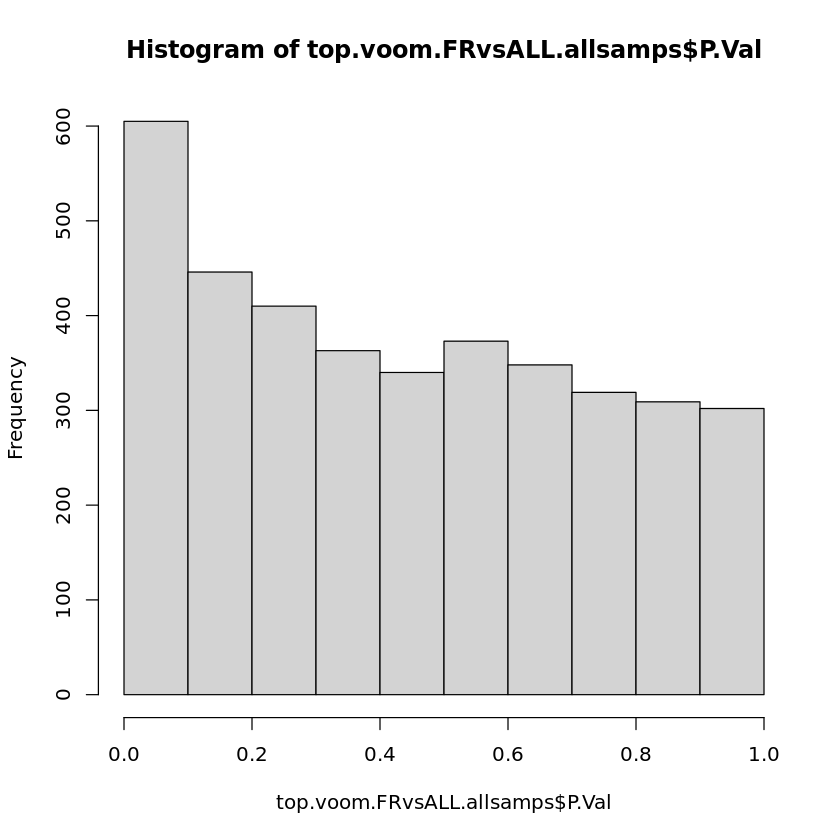

In [118]:
print(dim(top.voom.FRvsALL.allsamps[(top.voom.FRvsALL.allsamps$logFC>0)&(top.voom.FRvsALL.allsamps$adj.P.Val<fdr_thresh),]))
hist(top.voom.FRvsALL.allsamps$P.Val)

In [119]:
allsampsmarkers <- union(rownames(top.voom.FRvsALL.allsamps[(top.voom.FRvsALL.allsamps$logFC>0)&(top.voom.FRvsALL.allsamps$adj.P.Val<fdr_thresh),]),
          rownames(top.cpm.FRvsALL.allsamps[top.cpm.FRvsALL.allsamps$adj.P.Val<fdr_thresh&top.cpm.FRvsALL.allsamps$logFC>0,]) )

allsampsmarkers

character(0)

In [120]:
# paul wants degs

# make a heat map of the best genes on a t test of just the top genes from one FRpost vs FRneg, then see 
# if the cells the classifier for this find look like this

# also take one of their DEGs  and just start plotting the gene expression

In [121]:
# # plotting stuff
# excitatory.libsize <- pseudobulk.librarysizes[excitatory_pseudobulk.idx] # remove nonexcitatoy for normalization library sizes (UMI count)

# normed.pseudobulk <- pavlab.normalize(pseudobulk[,excitatory_pseudobulk.idx], UMI = excitatory.libsize ) # normalized

# dat <- scale(t(normed.pseudobulk))
# #dat <- t(normed.filtered.pseudobulk)

# my_sample_row <- data.frame(Condition = condition,
#                            Label = TRAPed)
# row.names(my_sample_row) <- rownames(dat)

# # make a heatmap
# dat <- dat[, colnames(dat) %in% allsampsmarkers]



# # plotting gene expression per sample
# temp_hm <-pheatmap(dat, cluster_rows = FALSE, cluster_cols = FALSE, main = "Remote Memory Marker Expression in Pseudobulk (All Samples Included)",
#         annotation_row = my_sample_row)

# save_pheatmap(temp_hm, filename='NoSamplesRemoved_RemoteMemoryMarkersExpressionSampleLevel_.png', width = 1200, height=600)

### Simluations

In [122]:
#filtered.pseudobulk <- pseudobulk[, excitatory_pseudobulk.idx] # remove lowly expressed genes and non excitatory samples
#filtered.pseudobulk <- filtered.pseudobulk[rownames(filtered.pseudobulk) %in% hg_to_mm$Symbol_mm,]

In [123]:
# randomw gen a matrix with a mean of 0 sd of 1 for all values
logCPM.sim  <- data.frame(matrix(rnorm(nrow(logCPM.allsamps)*ncol(logCPM.allsamps), mean=0, sd=.3), nrow=nrow(logCPM.allsamps)))
rownames(logCPM.sim) <- rownames(logCPM.allsamps) 
colnames(logCPM.sim) <- colnames(logCPM.allsamps)


# randomly chose some genes to have an upregulation to postivie and an interaction
rand.upregulated.genes <- sample(rownames(logCPM.sim), 200)
rand.interaction.genes <- sample(rand.upregulated.genes, 100) # interaction
# randomly chose some genes to be uniquely upregulated, not from other lsits
restricted.list <- rownames(logCPM.sim)[!(rownames(logCPM.sim) %in% rand.upregulated.genes )]
rand.frpos.unique.genes <- sample(restricted.list, 100)

pos.idx <- TRAPed.allsamps=='positive'
fr.idx <- condition.allsamps=='FearRecall'
frpos.interaction.idx <- fr.idx & pos.idx

In [124]:
for(i in rownames(logCPM.sim)){
    # loop over all genes check if they are in one fo the lists to be upregulated
    # if they are loop over the samples and replace them with a sample from a 
    # distribution with a higher mean
    
    # add in higher values and the random upregualted gene for postiive genes
    if(i %in% rand.upregulated.genes){
        for(j in colnames(logCPM.sim)){
            if(j %in% colnames(logCPM.sim)[pos.idx]){
            logCPM.sim[i,j] <- rnorm(1,2,0.3)}# end of nested if
            }# end this forloop
        }# end of if statement
    
    # add in higher valuesfir interaction genes
    if(i %in% rand.interaction.genes){
        for(j in colnames(logCPM.sim)){
            if(j %in% colnames(logCPM.sim)[frpos.interaction.idx]){
            logCPM.sim[i,j] <- rnorm(1,4,.3)}# end of nested if
            }# end this forloop
        }# end of first if
    # add in higher values for uniquely activated genes for the interaction
    if(i %in% rand.frpos.unique.genes){
        for(j in colnames(logCPM.sim)){
            if(j %in% colnames(logCPM.sim)[frpos.interaction.idx]){
            logCPM.sim[i,j] <- rnorm(1,4,.3)} # end of nested if
            }# end this forloop
        } # end of first if
}# end of looop over all genes

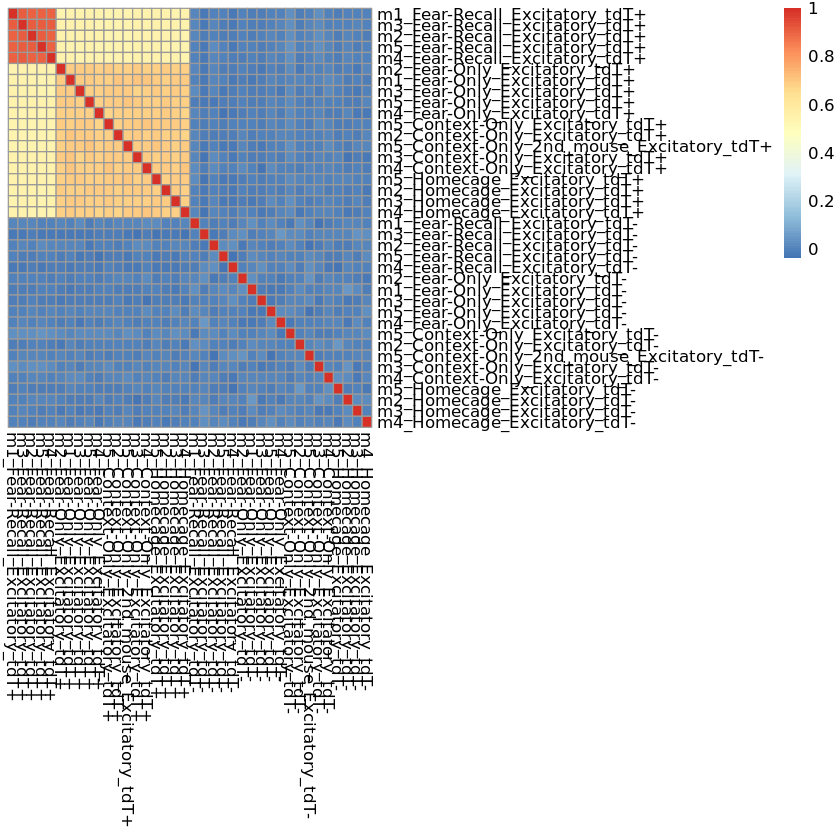

In [125]:
# produce correlation matrix before creating the DGE list
#test2 <- cor(logCPM.sim)
#test2 <- cor(normed.filtered.pseudobulk)

pheatmap(cor(logCPM.sim), cluster_cols = FALSE, cluster_rows = FALSE)

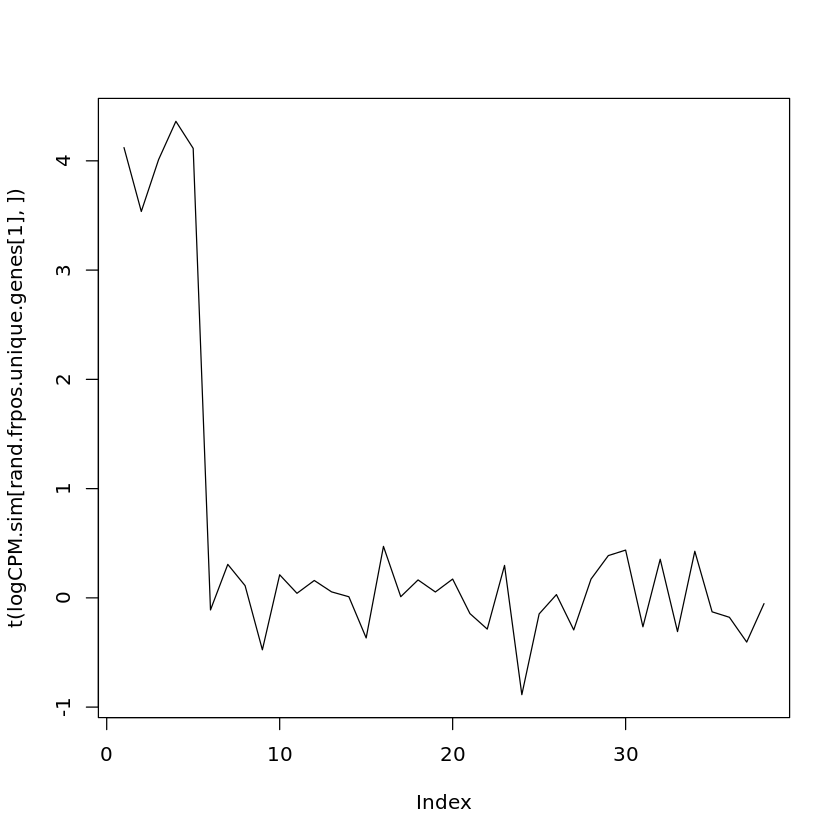

In [126]:
plot(t(logCPM.sim[rand.frpos.unique.genes[1],]), ty='l')

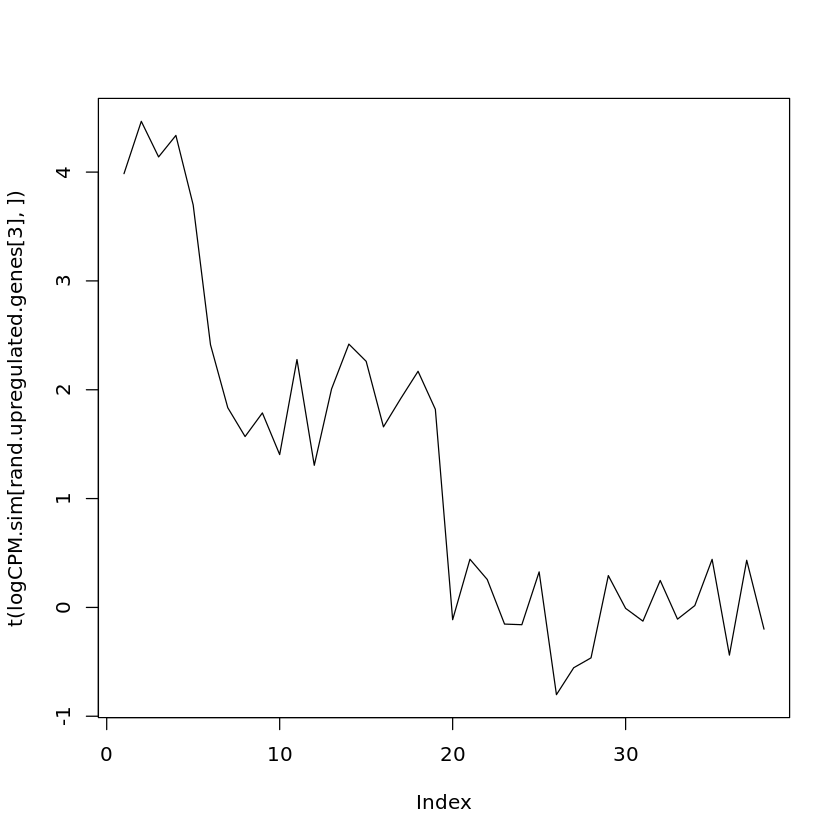

In [127]:
plot(t(logCPM.sim[rand.upregulated.genes[3],]), ty='l')

In [128]:
colnames(mm_noreps.interactions_allsamps)

[1] "(Intercept)"                                         
[2] "condition.allsampsFearOnly"                          
[3] "condition.allsampsFearRecall"                        
[4] "condition.allsampsHomecage"                          
[5] "TRAPed.allsampspositive"                             
[6] "condition.allsampsFearOnly:TRAPed.allsampspositive"  
[7] "condition.allsampsFearRecall:TRAPed.allsampspositive"
[8] "condition.allsampsHomecage:TRAPed.allsampspositive"

In [129]:
rand.frpos.unique.genes[1]

[1] "Med27"

In [130]:
logCPM.sim[rand.frpos.unique.genes[1],]

,m1_Fear-Recall_Excitatory_tdT+,m3_Fear-Recall_Excitatory_tdT+,m2_Fear-Recall_Excitatory_tdT+,m5_Fear-Recall_Excitatory_tdT+,m4_Fear-Recall_Excitatory_tdT+,m2_Fear-Only_Excitatory_tdT+,m1_Fear-Only_Excitatory_tdT+,m3_Fear-Only_Excitatory_tdT+,m5_Fear-Only_Excitatory_tdT+,m4_Fear-Only_Excitatory_tdT+,...,m4_Fear-Only_Excitatory_tdT-,m5_Context-Only_Excitatory_tdT-,m2_Context-Only_Excitatory_tdT-,m5_Context-Only_2nd_mouse_Excitatory_tdT-,m3_Context-Only_Excitatory_tdT-,m4_Context-Only_Excitatory_tdT-,m5_Homecage_Excitatory_tdT-,m2_Homecage_Excitatory_tdT-,m3_Homecage_Excitatory_tdT-,m4_Homecage_Excitatory_tdT-
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Med27,4.121197,3.536677,4.011448,4.361731,4.114187,-0.1104978,0.3063441,0.111821,-0.4752322,0.2111934,...,0.3870238,0.4372217,-0.2647543,0.3534151,-0.3086414,0.4265271,-0.1277821,-0.1778411,-0.4046542,-0.05301147


lm(formula= Mrpl10 ~ group,
   t(logCPM.sim[rand.frpos.unique.genes[1],]),
   design = mm_noreps.interactions_allsamps)

lm(formula= 'Mrpl10 ~ condition',
   logCPM.sim[rand.frpos.unique.genes[1],],
   design = mm_noreps.interactions_allsamps)

anova(logCPM.sim[rand.frpos.unique.genes[1],])

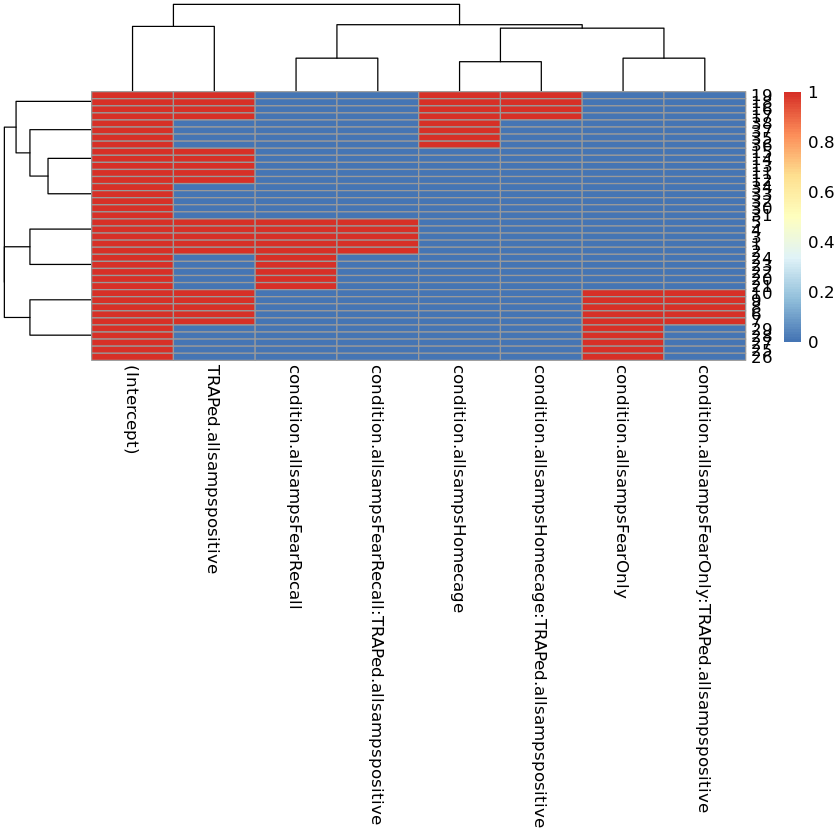

In [131]:
pheatmap(mm_noreps.interactions_allsamps)

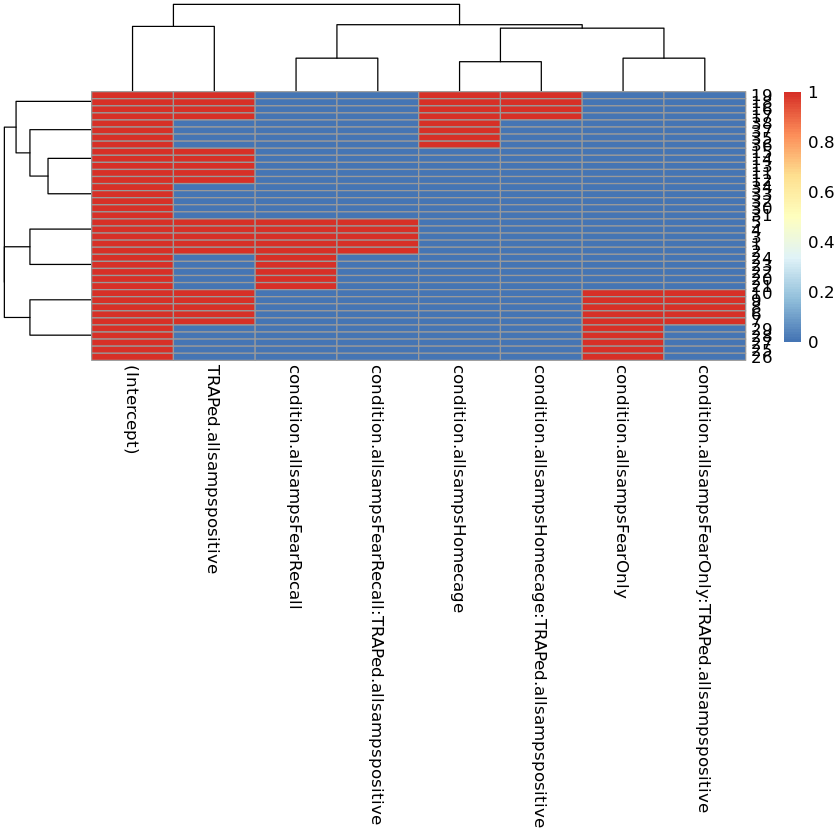

In [132]:
pheatmap(mm_noreps.interactions_allsamps)

In [133]:
#logcpm
fit.cpm.sim <- lmFit(logCPM.sim, mm_noreps.interactions_allsamps)
#fit.cpm.FRvsALL.sim <- contrasts.fit(fit.cpm.sim, c(-1/7,-1/7,-1/7,1/7,-1/7,-1/7,-1/7,-1/7))
#fit.cpm.FRvsALL.sim <- contrasts.fit(fit.cpm.sim, c(-1/7,-1/7,-1/7, 1, -1/7,-1/7,-1/7,-1/7))
fit.cpm.FRvsALL.sim <- contrasts.fit(fit.cpm.sim, c(0,0,-1, 1, 0,0,0,0))
top.cpm.FRvsALL.sim <- topTable(eBayes(fit.cpm.FRvsALL.sim), adjust.method="BH", number = 100)

In [134]:
print(dim(top.cpm.FRvsALL.sim))
head(top.cpm.FRvsALL.sim)

[1] 100   6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Kif5a,0.7901410,-0.02675573,3.929600,8.513733e-05,0.3247989,-2.920137
Pdk3,-0.7207323,0.03069953,-3.584410,3.379810e-04,0.6446988,-3.223897
Fbxo22,-0.6807292,0.10706145,-3.385463,7.108217e-04,0.8506321,-3.386289
Otub1,0.6681032,0.01586119,3.322670,8.918816e-04,0.8506321,-3.435619
Hax1,-0.6524475,0.03832503,-3.244810,1.175628e-03,0.8970042,-3.495504
Abcg1,-0.6390570,0.02682900,-3.178215,1.482241e-03,0.9129331,-3.545598


In [135]:
print(rownames(top.cpm.FRvsALL.sim)[rownames(top.cpm.FRvsALL.sim) %in% rand.frpos.unique.genes])
print(rownames(top.cpm.FRvsALL.sim)[rownames(top.cpm.FRvsALL.sim) %in% rand.interaction.genes])
print(rownames(top.cpm.FRvsALL.sim)[rownames(top.cpm.FRvsALL.sim) %in% rand.upregulated.genes])


[1] "Pld3"  "Nudt3"
[1] "Psmd5" "Cck"   "Ppm1g"
[1] "Nsmce3" "Psmd5"  "Cck"    "Exoc3"  "Ppm1g" 


In [136]:
colnames(mm_noreps.interactions_allsamps)

[1] "(Intercept)"                                         
[2] "condition.allsampsFearOnly"                          
[3] "condition.allsampsFearRecall"                        
[4] "condition.allsampsHomecage"                          
[5] "TRAPed.allsampspositive"                             
[6] "condition.allsampsFearOnly:TRAPed.allsampspositive"  
[7] "condition.allsampsFearRecall:TRAPed.allsampspositive"
[8] "condition.allsampsHomecage:TRAPed.allsampspositive"

In [137]:
abbreviate(colnames(mm_noreps.interactions_allsamps))

(Intercept) 
                                              "(In)" 
                          condition.allsampsFearOnly 
                                             "cn.FO" 
                        condition.allsampsFearRecall 
                                             "cn.FR" 
                          condition.allsampsHomecage 
                                              "cn.H" 
                             TRAPed.allsampspositive 
                                              "TRAP" 
  condition.allsampsFearOnly:TRAPed.allsampspositive 
                                             "c.FO:" 
condition.allsampsFearRecall:TRAPed.allsampspositive 
                                             "c.FR:" 
  condition.allsampsHomecage:TRAPed.allsampspositive 
                                              "c.H:"

contrasts <- makeContrasts(
  c.FR-TRAP,
  levels=colnames(mm_noreps.interactions_allsamps))
colnames(contrasts) <- abbreviate(colnames(mm_noreps.interactions_allsamps))
contrasts

rand.frpos.unique.genes[rand.frpos.unique.genes %in% rownames(top.cpm.FRvsALL.sim)[top.cpm.FRvsALL.sim$adj.P.val<0.01]]

hist(top.cpm.FRvsALL.sim$P.Val)

fit.cpm.sim <- lmFit(logCPM.sim, mm_noreps.interactions_allsamps)
fit.sim.negvspos <- contrasts.fit(fit.cpm.sim, c(-1/4,1/4,-1/4,1/4,-1/4,1/4,-1/4,1/4))
top.sim.negvspos <- topTable(eBayes(fit.sim.negvspos), adjust.method="BH")

print(dim(top.sim.negvspos))
head(top.sim.negvspos)

hist(top.sim.negvspos$P.Val)

##  T-tests

Just running t-test between - and _ samples in fear recall

In [138]:
library(scrime)

In [139]:
head(pseudobulk_meta,5)

,celltype,condition,TRAPed,replicate,n_cells,environment_exposure,fear,recall
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
m1_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m1_Fear-Recall,43,TRUE,TRUE,TRUE
m1_Fear-Recall_Inhibitory_tdT+,Inhibitory,Fear-Recall,positive,m1_Fear-Recall,75,TRUE,TRUE,TRUE
m3_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m3_Fear-Recall,222,TRUE,TRUE,TRUE
m3_Fear-Recall_Inhibitory_tdT+,Inhibitory,Fear-Recall,positive,m3_Fear-Recall,83,TRUE,TRUE,TRUE
m2_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m2_Fear-Recall,279,TRUE,TRUE,TRUE


In [140]:
# normalize scale across all
pseudobulk.lognormed <- pavlab.normalize(pseudobulk)

FR.neg.pseudobulk <- pseudobulk.lognormed[,pseudobulk_meta$condition=='Fear-Recall' & pseudobulk_meta$TRAPed=='negative' & pseudobulk_meta$celltype =='Excitatory']
FR.pos.pseudobulk <- pseudobulk.lognormed[,pseudobulk_meta$condition=='Fear-Recall' & pseudobulk_meta$TRAPed=='positive' & pseudobulk_meta$celltype =='Excitatory']

#

In [141]:
ptests <- c()
effects <- c()
stderror <- c()

for (this_gene in rownames(pseudobulk.lognormed)){
    testobj <- t.test(x = FR.pos.pseudobulk[this_gene,], y = FR.neg.pseudobulk[this_gene,],alternative ="two.sided")
    # some genes are giving effects of 0 and as a result producing stupid errors when doing filtering later
    # based on significances since they return nan's to prevent this we are fitlering them here
    if(is.na(testobj$p.value)){
        ptests <- c(ptests,1.0)
    }else{
        ptests <- c(ptests,testobj$p.value)
    }
    effects <- c(effects,as.numeric(testobj$estimate[2]-testobj$estimate[1])) # null - test
    stderror <- c(stderror,testobj$stderr)
}

In [142]:
print(ptests[1:10])
print(effects[1:10])
print(stderror[1:10])

 [1] 0.45155864 0.86487962 0.40609012 0.34993367 0.09734182 0.37440190
 [7] 0.75343098 0.33157997 0.58820487 0.63014124
 [1]  0.05415451  0.01436082 -0.09148590 -0.26531008  0.68244816  0.47510258
 [7]  0.07495994  0.30756792  0.12421519  0.10181797
 [1] 0.06746771 0.08123665 0.10118022 0.26708437 0.32850166 0.49975390
 [7] 0.22944024 0.28303610 0.21648264 0.20207492


In [143]:
multiple.t.tests.df <- data.frame(Effect = effects, StandardErr = stderror, Raw.p.value = ptests)

In [144]:
multiple.t.tests.df$Q.values_BH <- p.adjust(multiple.t.tests.df$Raw.p.value, method = "BH")

In [145]:
head(multiple.t.tests.df,5)

,Effect,StandardErr,Raw.p.value,Q.values_BH
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.05415451,0.06746771,0.45155864,0.8981445
2,0.01436082,0.08123665,0.86487962,0.9818490
3,-0.09148590,0.10118022,0.40609012,0.8981445
4,-0.26531008,0.26708437,0.34993367,0.8981445
5,0.68244816,0.32850166,0.09734182,0.8981445


In [146]:
rownames(multiple.t.tests.df)[multiple.t.tests.df$Q.values_BH<0.1]

character(0)

In [147]:
print(rownames(multiple.t.tests.df)[multiple.t.tests.df$Q.values_BH<0.1])

character(0)


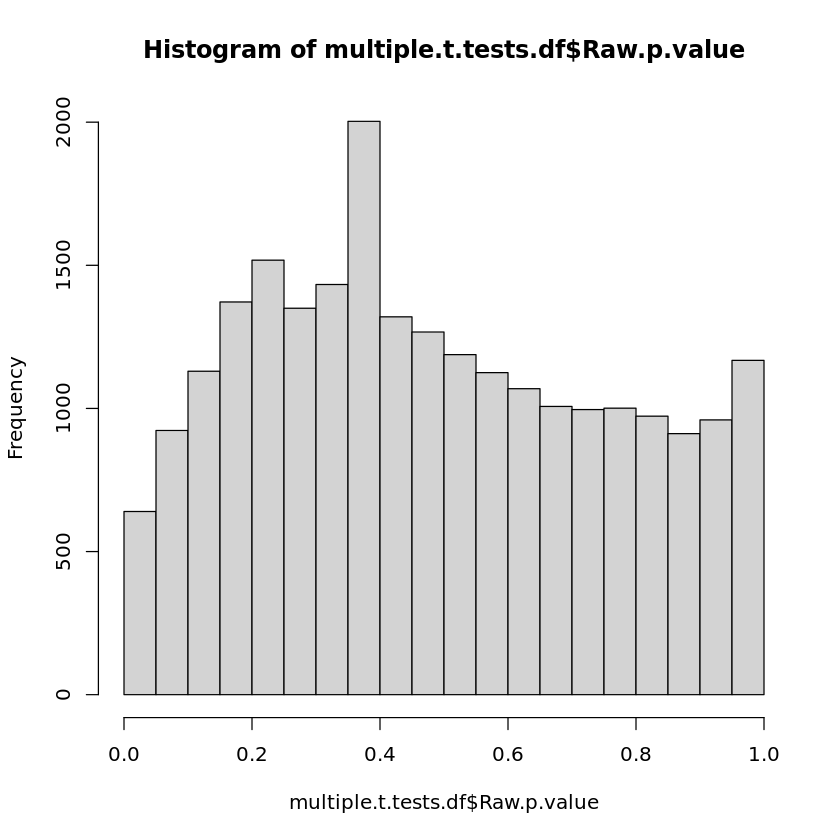

In [148]:
hist(multiple.t.tests.df$Raw.p.value)

In [149]:
# make t-test heatmaps for top

In [150]:
mean(multiple.t.tests.df$Effect)

[1] 0.02375354

Lets try filtering out bad genes again.

In [151]:
sum(rowSums(pseudobulk)>100)

[1] 20769

In [152]:
sum(chen.genefilter)

[1] 21815

In [153]:
# normalize scale across all
pseudobulk.lognormed.filt <- pseudobulk.lognormed[chen.genefilter & rowSums(pseudobulk)>100,]

FR.neg.pseudobulk.filt <- pseudobulk.lognormed.filt[,pseudobulk_meta$condition=='Fear-Recall' & pseudobulk_meta$TRAPed=='negative' & pseudobulk_meta$celltype =='Excitatory']
FR.pos.pseudobulk.filt <- pseudobulk.lognormed.filt[,pseudobulk_meta$condition=='Fear-Recall' & pseudobulk_meta$TRAPed=='positive' & pseudobulk_meta$celltype =='Excitatory']

#

In [154]:
ptests <- c()
effects <- c()
stderror <- c()

for (this_gene in rownames(pseudobulk.lognormed.filt)){
    testobj <- t.test(x = FR.pos.pseudobulk.filt[this_gene,], y = FR.neg.pseudobulk.filt[this_gene,],alternative ="two.sided")
    if(is.na(testobj$p.value)){
        ptests <- c(ptests,1.0)
    }else{
        ptests <- c(ptests,testobj$p.value)
    }
    effects <- c(effects,as.numeric(testobj$estimate[2]-testobj$estimate[1])) # null - test
    stderror <- c(stderror,testobj$stderr)
}

multiple.t.tests.df.filtered <- data.frame(Effect = effects, StandardErr = stderror, Raw.p.value = ptests)
multiple.t.tests.df.filtered$Q.values_BH <- p.adjust(multiple.t.tests.df.filtered$Raw.p.value, method = "BH")

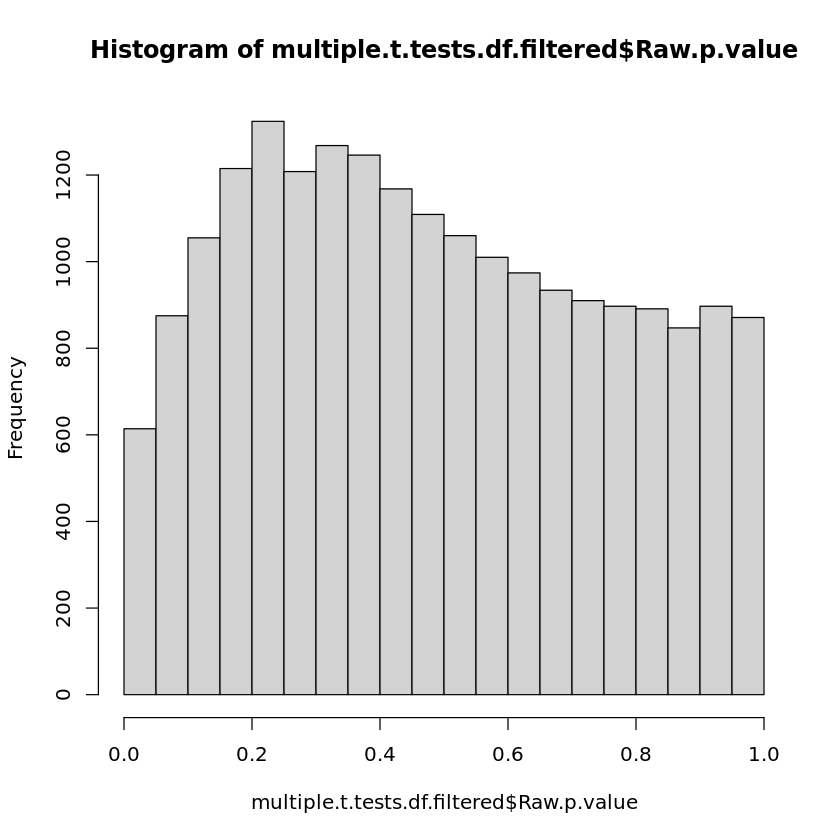

In [155]:
hist(multiple.t.tests.df.filtered$Raw.p.value)

In [156]:
print(rownames(multiple.t.tests.df.filtered)[multiple.t.tests.df.filtered$Q.values_BH<0.1])

character(0)


In [157]:
sum(chen2020_meta$condition_label=='Fear-Recall' & chen2020_meta$BroadCellTypes=='Excitatory' & as.character(chen2020_meta$engram_label)=='Td+')

[1] 0

In [158]:
table(chen2020_meta$ChenLayerMarkers)


    Calb2     Dkkl1      Lhx6      Rprm      Tesc Tnfaip8l3     Tshz2 
      576      1164       202       677       415       250       246 

In [159]:
chen2020_counts.normed <- pavlab.normalize(chen2020_counts)

chen2020_counts.normed <- chen2020_counts.normed[chen.genefilter & rowSums(pseudobulk)>100,]
rownames(chen2020_counts.normed)


[1] "00R-AC107638.2"  "0610005C13Rik"   "0610007P14Rik"   "0610009B22Rik"  
    [5] "0610009E02Rik"   "0610009L18Rik"   "0610009O20Rik"   "0610010F05Rik"  
    [9] "0610010K14Rik"   "0610012G03Rik"   "0610030E20Rik"   "0610037L13Rik"  
   [13] "0610038B21Rik"   "0610040B10Rik"   "0610040F04Rik"   "1110002E22Rik"  
   [17] "1110002L01Rik"   "1110002O04Rik"   "1110003F10Rik"   "1110004E09Rik"  
   [21] "1110004F10Rik"   "1110006O24Rik"   "1110008F13Rik"   "1110008L16Rik"  
   [25] "1110008P14Rik"   "1110012L19Rik"   "1110017D15Rik"   "1110018N20Rik"  
   [29] "1110019D14Rik"   "1110020A21Rik"   "1110032A03Rik"   "1110032F04Rik"  
   [33] "1110034G24Rik"   "1110035H17Rik"   "1110037F02Rik"   "1110038B12Rik"  
   [37] "1110038F14Rik"   "1110046J04Rik"   "1110051M20Rik"   "1110059E24Rik"  
   [41] "1110059G10Rik"   "1110065P20Rik"   "1190002N15Rik"   "1190005I06Rik"  
   [45] "1190007I07Rik"   "1300002E11Rik"   "1500002C15Rik"   "1500002F19Rik"  
   [49] "1500004A13Rik"   "1500009C09Rik"   "1500009L16Rik"   "1500011B03Rik"  
   [53] "1500011K16Rik"   "1500012K07Rik"   "1500015A07Rik"   "1500026H17Rik"  
   [57] "1500035N22Rik"   "1600002H07Rik"   "1600002K03Rik"   "1600012H06Rik"  
   [61] "1600014C10Rik"   "1600017P15Rik"   "1600020E01Rik"   "1600023N17Rik"  
   [65] "1600029O15Rik"   "1700001G11Rik"   "1700001G17Rik"   "1700001L05Rik"  
   [69] "1700001L19Rik"   "1700001O22Rik"   "1700003E16Rik"   "1700003G18Rik"  
   [73] "1700003M07Rik"   "1700007G11Rik"   "1700007K13Rik"   "1700007L15Rik"  
   [77] "1700007P06Rik"   "1700008J07Rik"   "1700008O03Rik"   "1700010I14Rik"  
   [81] "1700012D14Rik"   "1700013F07Rik"   "1700016K19Rik"   "1700016P03Rik"  
   [85] "1700017B05Rik"   "1700018L02Rik"   "1700019D03Rik"   "1700020I14Rik"  
   [89] "1700021F05Rik"   "1700021J08Rik"   "1700021N21Rik"   "1700022I11Rik"  
   [93] "1700023F06Rik"   "1700023H06Rik"   "1700025G04Rik"   "1700027J19Rik"  
   [97] "1700028B04Rik"   "1700028E10Rik"   "1700028J19Rik"   "1700028K03Rik"  
  [101] "1700028P14Rik"   "1700029I15Rik"   "1700029J07Rik"   "1700030C14Rik"  
  [105] "1700030J22Rik"   "1700030K09Rik"   "1700034H15Rik"   "1700034P13Rik"  
  [109] "1700037C18Rik"   "1700037H04Rik"   "1700040D17Rik"   "1700040L02Rik"  
  [113] "1700047K16Rik"   "1700048F04Rik"   "1700048O20Rik"   "1700052K11Rik"  
  [117] "1700055D18Rik"   "1700056N10Rik"   "1700061G19Rik"   "1700066M21Rik"  
  [121] "1700067K01Rik"   "1700080G11Rik"   "1700084E18Rik"   "1700086L19Rik"  
  [125] "1700086O06Rik"   "1700086P04Rik"   "1700088E04Rik"   "1700095J03Rik"  
  [129] "1700096K18Rik"   "1700101I11Rik"   "1700105P06Rik"   "1700109H08Rik"  
  [133] "1700109K24Rik"   "1700112D23Rik"   "1700112J16Rik"   "1700113A16Rik"  
  [137] "1700120C14Rik"   "1700123M08Rik"   "1700123O20Rik"   "1700124L16Rik"  
  [141] "1810009A15Rik"   "1810010H24Rik"   "1810013L24Rik"   "1810014B01Rik"  
  [145] "1810020O05Rik"   "1810021B22Rik"   "1810022K09Rik"   "1810024B03Rik"  
  [149] "1810026B05Rik"   "1810030O07Rik"   "1810032O08Rik"   "1810037I17Rik"  
  [153] "1810041H14Rik"   "1810041L15Rik"   "1810043G02Rik"   "1810044D09Rik"  
  [157] "1810049J17Rik"   "1810055G02Rik"   "1810058I24Rik"   "1810059H22Rik"  
  [161] "1810062O18Rik"   "2010001A14Rik"   "2010015M23Rik"   "2010107E04Rik"  
  [165] "2010107G23Rik"   "2010109A12Rik"   "2010111I01Rik"   "2010204K13Rik"  
  [169] "2010300C02Rik"   "2010315B03Rik"   "2010320M18Rik"   "2010320O07Rik"  
  [173] "2200002D01Rik"   "2210008F06Rik"   "2210013O21Rik"   "2210016F16Rik"  
  [177] "2210016L21Rik"   "2210406O10Rik"   "2210408F21Rik"   "2210408I21Rik"  
  [181] "2210418O10Rik"   "2300009A05Rik"   "2310001H17Rik"   "2310001K24Rik"  
  [185] "2310009A05Rik"   "2310009B15Rik"   "2310010J17Rik"   "2310011J03Rik"  
  [189] "2310015A10Rik"   "2310022A10Rik"   "2310022B05Rik"   "2310026I22Rik"  
  [193] "2310030G06Rik"   "2310031A07Rik"   "2310033P09Rik"   "2310034G01Rik"  
  [197] "2310035C23Rik"   "2310036O22Rik"   "2310039H08Rik"   "2310040G07Rik"  
  [2

In [160]:
dkkl1.pos <- chen2020_counts.normed [,chen2020_meta$condition_label=='Fear-Recall' & chen2020_meta$ChenLayerMarkers=='Dkkl1' & chen2020_meta$engram_label=='tdT+']
dkkl1.neg <- chen2020_counts.normed[,chen2020_meta$condition_label=='Fear-Recall' & chen2020_meta$ChenLayerMarkers=='Dkkl1' & chen2020_meta$engram_label=='tdT-']
#

In [161]:
ptests <- c()
effects <- c()
stderror <- c()

for (this_gene in rownames(pseudobulk.lognormed.filt)){
    testobj <- t.test(x = dkkl1.pos[this_gene,], y = dkkl1.neg[this_gene,],alternative ="two.sided")
    if(is.na(testobj$p.value)){
        ptests <- c(ptests,1.0)
    }else{
        ptests <- c(ptests,testobj$p.value)
    }
    effects <- c(effects,as.numeric(testobj$estimate[2]-testobj$estimate[1])) # null - test
    stderror <- c(stderror,testobj$stderr)
}

multiple.t.tests.df.filtered.dkkl1 <- data.frame(Effect = effects, StandardErr = stderror, Raw.p.value = ptests)
multiple.t.tests.df.filtered.dkkl1$Q.values_BH <- p.adjust(multiple.t.tests.df.filtered.dkkl1$Raw.p.value, method = "BH")

In [162]:
rownames(multiple.t.tests.df.filtered.dkkl1) <- rownames(chen2020_counts)[chen.genefilter & rowSums(pseudobulk)>100]

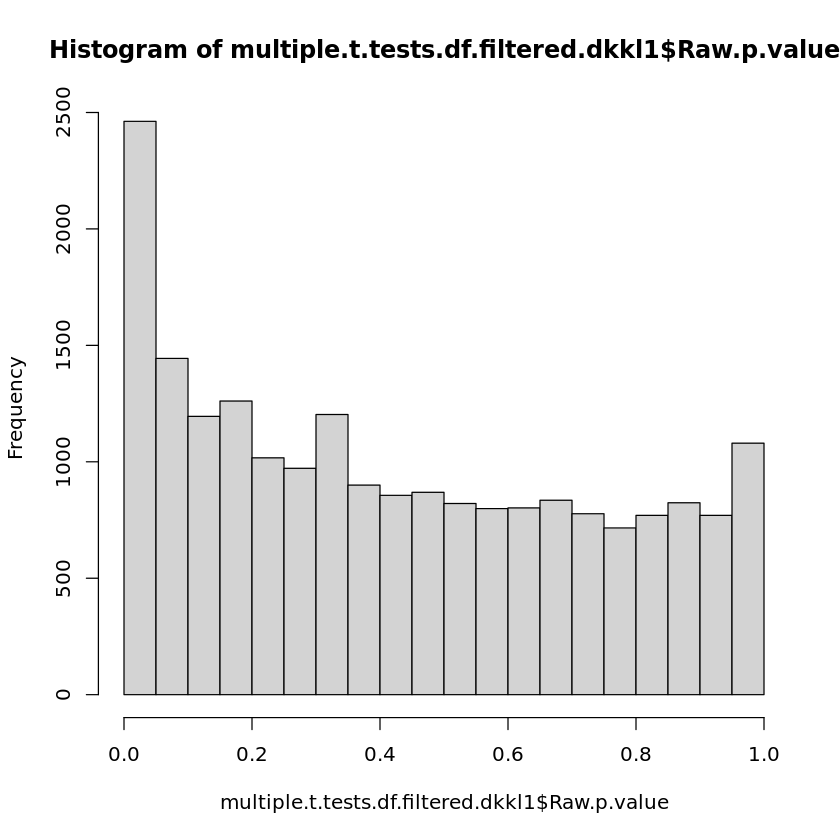

In [163]:
hist(multiple.t.tests.df.filtered.dkkl1$Raw.p.value)

In [164]:
multiple.t.tests.df.filtered.dkkl1[multiple.t.tests.df.filtered.dkkl1$Q.values_BH<0.01&multiple.t.tests.df.filtered.dkkl1$Effect>0,]

,Effect,StandardErr,Raw.p.value,Q.values_BH
,<dbl>,<dbl>,<dbl>,<dbl>
Necab3,1.472374,0.31874245,5.782996e-06,5.180491e-03
Rn18s-rs5,0.494859,0.07736132,5.781175e-10,5.888994e-06


Now we do the interaction effect, Dkkl1 FR postive vs everything else.

In [165]:
# get cells only in fear recal taht are tdT postive
dkkl1.fr.pos <- chen2020_counts.normed[,chen2020_meta$condition_label=='Fear-Recall' & chen2020_meta$ChenLayerMarkers=='Dkkl1' & chen2020_meta$engram_label=='tdT+']

# cells this cell types cellf rom all other codnitons positive or negative and negative FR cells 
dkkl1.otherconditions <- chen2020_counts.normed[,!(chen2020_meta$condition_label=='Fear-Recall' & chen2020_meta$engram_label=='tdT+') & chen2020_meta$ChenLayerMarkers=='Dkkl1']

In [166]:
ptests <- c()
effects <- c()
stderror <- c()

for (this_gene in rownames(pseudobulk.lognormed.filt)){
    testobj <- t.test(x = dkkl1.fr.pos[this_gene,], y = dkkl1.otherconditions[this_gene,],alternative ="two.sided")
    ptests <- c(ptests,testobj$p.value)
    effects <- c(effects,as.numeric(testobj$estimate[2]-testobj$estimate[1])) # null - test
    stderror <- c(stderror,testobj$stderr)
}

multiple.t.tests.df.filtered.dkkl1.interaction <- data.frame(Effect = effects, StandardErr = stderror, Raw.p.value = ptests)
multiple.t.tests.df.filtered.dkkl1.interaction$Q.values_BH <- p.adjust(multiple.t.tests.df.filtered.dkkl1$Raw.p.value, method = "BH")


#

In [167]:
multiple.t.tests.df.filtered.dkkl1.interaction$Gene <- rownames(pseudobulk.lognormed.filt)[as.numeric(rownames(multiple.t.tests.df.filtered.dkkl1.interaction))]

#

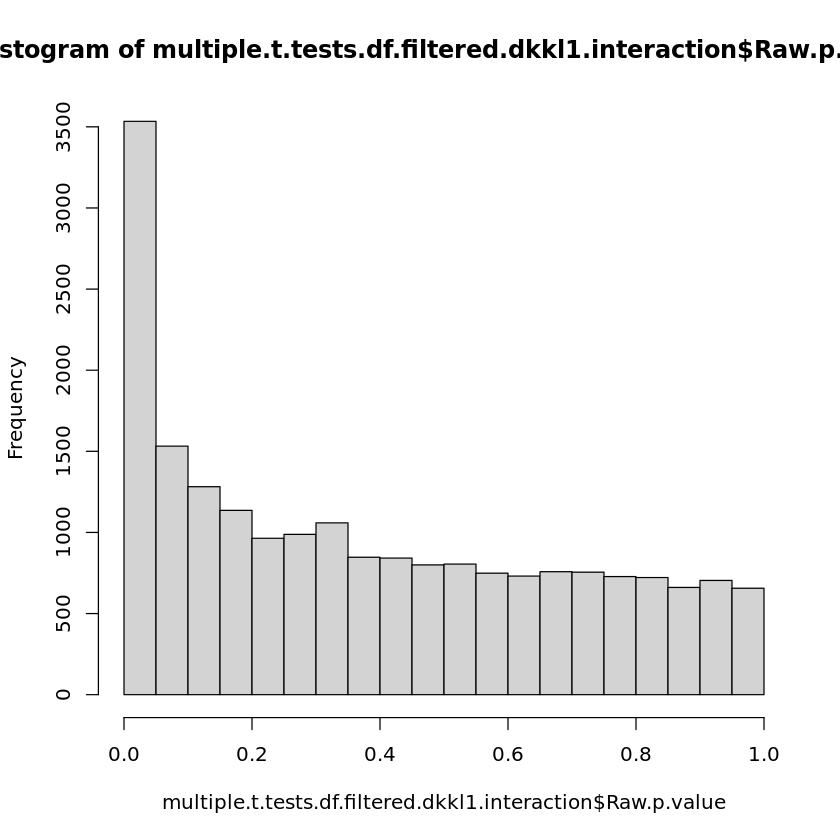

In [168]:
hist(multiple.t.tests.df.filtered.dkkl1.interaction$Raw.p.value)

In [169]:
largefc.pos.idx <- multiple.t.tests.df.filtered.dkkl1.interaction$Effect>0
largefc.pos.idx <- largefc.pos.idx & multiple.t.tests.df.filtered.dkkl1.interaction$Q.values_BH<0.1

multiple.t.tests.df.filtered.dkkl1.interaction[largefc.pos.idx,]

,Effect,StandardErr,Raw.p.value,Q.values_BH,Gene
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2287,0.6422911,0.24027139,7.694033e-03,7.354377e-02,Calb1
3231,0.2089193,0.17642115,2.367477e-01,7.391097e-02,Cplx2
4264,0.3410867,0.05808767,6.007792e-09,9.084781e-02,Elf1
4468,0.2165047,0.08249566,8.838935e-03,8.014356e-02,Evc2
6421,0.6126313,0.08169448,1.453954e-13,1.347169e-02,Gm26596
6660,0.1110647,0.07723523,1.508832e-01,8.013529e-02,Gm3375
8564,0.5041230,0.14811467,7.025201e-04,1.893861e-02,Gsg1l
9838,0.2407730,0.08729655,5.930469e-03,3.666659e-02,Lpl
10167,0.5128534,0.13358842,1.337807e-04,7.032374e-02,Matn2


In [170]:
intersect(multiple.t.tests.df.filtered.dkkl1.interaction$Gene[largefc.pos.idx], chen_remotememory_markers)

character(0)

In [171]:
multiple.t.tests.df.filtered.dkkl1.interaction[multiple.t.tests.df.filtered.dkkl1.interaction$Q.values_BH<0.01&multiple.t.tests.df.filtered.dkkl1.interaction$effects>0,]

Effect,StandardErr,Raw.p.value,Q.values_BH,Gene
<dbl>,<dbl>,<dbl>,<dbl>,<chr>


### Cell type specific Limma Analysis

I have assigned the chen dataset to comperable clusters as the Chen dataset.  

In [172]:
table(chen2020_meta$ChenLayerMarkers)


    Calb2     Dkkl1      Lhx6      Rprm      Tesc Tnfaip8l3     Tshz2 
      576      1164       202       677       415       250       246 

In [173]:
# could make this a nested apply, or aggreggate

# Create a list to store the masks
masks <- list()

# Iterate through each unique combination of source_name, broad_cell_types, and engram_label
for (i in unique(chen2020_meta$source_name)) {
  for (j in unique(chen2020_meta$ChenLayerMarkers)) {
    for (k in unique(chen2020_meta$engram_label)) {
      # Create a boolean mask for each unique combination
      mask <- chen2020_meta$source_name == i & chen2020_meta$ChenLayerMarkers == j & chen2020_meta$engram_label == k
      #print(sum(mask))
      # Name the mask after the unique combination
      name <- paste(i, j, k, sep = "_")
      #print(name)
      # Store the mask in the list
      masks[[name]] <- mask
      # Print the name of the mask
    }
  }
}

In [174]:
#we need to reorder these masks for later down the line for plotting purposes

reorder_str_vector <- function(string_vec, order_by_these_substrings){
    # string vec is a list of strings
    # order_by_these_substrings is the lsit of substrings to search for in the 
    # string_vec and to group together 
    # returns a new string vector grouped and ordered with any character strings not containing the substrings of interest removed
    # so in a list of reddog, redcat,bluedog,purplecat, greeparrot, yellowdog if you provide the substrings c('cat','dog')
    # you search would return  c('redcat','purplecat','reddog','bluedog','yellowdog')
    
    modified_string_vec <- c()
    
    for (substring in order_by_these_substrings){
        modified_string_vec <- c(modified_string_vec, string_vec[grepl(substring,string_vec, fixed = T)])
        }
    return(modified_string_vec)
    }

condition_order <- c('Fear-Recall','Fear-Only','Context-Only','Homecage')

reorderdnames <- c( reorder_str_vector(names(masks)[grepl('tdT+',names(masks), fixed = T)], condition_order),
                    reorder_str_vector(names(masks)[grepl('tdT-',names(masks), fixed = T)], condition_order) )

masks <- masks[reorderdnames]

In [175]:
genes <- rownames(chen2020_counts)

# create matrix to fill
pseudobulk.celltype <- matrix(0, nrow = length(genes), ncol = length(masks))
pseudobulk.celltype <- as.data.frame(pseudobulk.celltype)
rownames(pseudobulk.celltype) <- genes
colnames(pseudobulk.celltype) <- names(masks)

In [176]:
# pseudobulk our samples
for (sample in names(masks)) {

    #get mask to filter counts matrix cell-wise (col wise) by
    these_cols <- masks[[sample]]
    
    # we need to handle exceptions otherwise rowSums throws errors
    # it needs a 2d array which can't happen in a no cell case or a 1 cell case
    # we should consider removing these cases enttirely
    # we 
    if(sum(these_cols)==0){
        # do nothing in this case, but convert column to integer to avoid errors later
        pseudobulk.celltype[,sample] <- as.integer(pseudobulk.celltype[,sample])
        }else if(sum(these_cols)==1){
        # 
        pseudobulk.celltype[,sample] <- as.integer(chen2020_counts[, these_cols])
    }else{
    pseudobulk.celltype[,sample] <- as.integer( rowSums(chen2020_counts[, these_cols]) ) }
}

pseudobulk.celltype.librarysizes <- colSums(pseudobulk.celltype)

In [177]:
multi.sub <- function(findthis, replacewith, x.vec){
    # replaces an entry containing a string matching an entry in findthis in x.vec with a corresponding entry in replacewith
    
    # seq_along returns enumerates integers from 1 to length of input list
    # loops over list of things to find
    for(i in seq_along(findthis)){
    #masks vector where 
    x.vec[grepl(findthis[i], x.vec)] <- replacewith[i]}
    return(x.vec)
    }

# since we are finding a pattern in the pseudobulk_meta titles and replacing each entry wiht that pattern we would have to enter the vector twice
# now we make a function so we only have to enter each list once making our code a little more legible
fun <- function(my_list, dfcol){
    factors.list <- unique(dfcol)
    return( multi.sub(factors.list, factors.list, my_list) )
    }

In [178]:
pseudobulk_meta.celltype <-  data.frame(celltype =  as.factor(sapply(colnames(pseudobulk.celltype), function(x) fun(x, unique(chen2020_meta$ChenLayerMarkers) ) ) ),
                               condition = as.factor(sapply(colnames(pseudobulk.celltype), function(x) fun(x, unique(chen2020_meta$condition_label) ) ) ),
                               TRAPed = as.factor(sapply(colnames(pseudobulk.celltype), function(x) fun(x, unique(chen2020_meta$engram_label) ) ) ),
                               replicate = as.factor(sapply(colnames(pseudobulk.celltype), function(x) fun(x, unique(chen2020_meta$source_name) ) ) )
                               )

levels(pseudobulk_meta.celltype$TRAPed) <- c('positive', 'negative') # the labelled neurons get levels named 1 and 2 so this makes the dataframe more interpretable

In [179]:
n_cells <- list()
for(i in seq_along( names(masks) )){n_cells <- append(n_cells, sum(masks[[i]]))}
pseudobulk_meta.celltype$n_cells <- as.integer(n_cells) # adding cell counts to dataframe
rm(n_cells) # deleting unneeded variable

In [180]:
head(pseudobulk.celltype)

,m1_Fear-Recall_Dkkl1_tdT+,m1_Fear-Recall_Rprm_tdT+,m1_Fear-Recall_Lhx6_tdT+,m1_Fear-Recall_Tnfaip8l3_tdT+,m1_Fear-Recall_Tshz2_tdT+,m1_Fear-Recall_Tesc_tdT+,m1_Fear-Recall_Calb2_tdT+,m3_Fear-Recall_Dkkl1_tdT+,m3_Fear-Recall_Rprm_tdT+,m3_Fear-Recall_Lhx6_tdT+,...,m3_Homecage_Tshz2_tdT-,m3_Homecage_Tesc_tdT-,m3_Homecage_Calb2_tdT-,m4_Homecage_Dkkl1_tdT-,m4_Homecage_Rprm_tdT-,m4_Homecage_Lhx6_tdT-,m4_Homecage_Tnfaip8l3_tdT-,m4_Homecage_Tshz2_tdT-,m4_Homecage_Tesc_tdT-,m4_Homecage_Calb2_tdT-
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
00R-AC107638.2,0,0,15,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0610005C13Rik,0,0,0,0,0,0,0,6,18,15,...,0,0,0,0,0,0,0,0,0,0
0610007P14Rik,466,965,1468,0,24,3267,5589,5487,5008,1293,...,356,163,50,242,0,0,264,0,0,0
0610009B22Rik,144,1565,1491,0,0,1697,1831,2499,2200,1486,...,229,72,0,330,0,0,141,0,0,0
0610009E02Rik,0,1,14,0,0,18,72,16,9,10,...,0,0,0,1,0,0,0,0,0,0
0610009L18Rik,29,19,39,0,0,181,145,75,209,88,...,0,0,0,47,0,0,6,0,0,0


In [181]:
head(pseudobulk_meta.celltype)

,celltype,condition,TRAPed,replicate,n_cells
,<fct>,<fct>,<fct>,<fct>,<int>
m1_Fear-Recall_Dkkl1_tdT+,Dkkl1,Fear-Recall,positive,m1_Fear-Recall,6
m1_Fear-Recall_Rprm_tdT+,Rprm,Fear-Recall,positive,m1_Fear-Recall,9
m1_Fear-Recall_Lhx6_tdT+,Lhx6,Fear-Recall,positive,m1_Fear-Recall,22
m1_Fear-Recall_Tnfaip8l3_tdT+,Tnfaip8l3,Fear-Recall,positive,m1_Fear-Recall,0
m1_Fear-Recall_Tshz2_tdT+,Tshz2,Fear-Recall,positive,m1_Fear-Recall,1
m1_Fear-Recall_Tesc_tdT+,Tesc,Fear-Recall,positive,m1_Fear-Recall,27


In [182]:
colnames(chen2020_meta)

[1] "Run"                 "Assay.Type"          "AvgSpotLen"         
 [4] "Bases"               "BioProject"          "BioSample"          
 [7] "Bytes"               "Cell_type"           "Center.Name"        
[10] "Consent"             "DATASTORE.filetype"  "DATASTORE.provider" 
[13] "DATASTORE.region"    "Experiment"          "GEO_Accession..exp."
[16] "Instrument"          "LibraryLayout"       "LibrarySelection"   
[19] "LibrarySource"       "Organism"            "Platform"           
[22] "ReleaseDate"         "Sample.Name"         "source_name"        
[25] "SRA.Study"           "engram_label"        "condition_label"    
[28] "X"                   "seurat_cluster_num"  "ChenLayerMarkers"   
[31] "TopTwoMarkers"       "BroadCellTypes"

Below we can see the cell types and the authors of Chen et al., (2020) used to calculate DEGs.  The image on teh right is from figure 2 and the inmage on the right is from the bottom left of figure 3.  I mateched the cell types, note that these markers were hand picked from the DEG lsit to match a prior ABI dataset claiming to find layer specific markers.  The markers existed in the seurat DEG list but they were not top markers, I saved them in the chen2020_meta as the ChenLayermakers.  THe actual top ranked markers are in the top-two markers filed, I chose top two because some of the top markers were not unique.  Due to number of neurons they did not run the analysis on the Tshz2 neurons nor the Lhx6 neurons.  

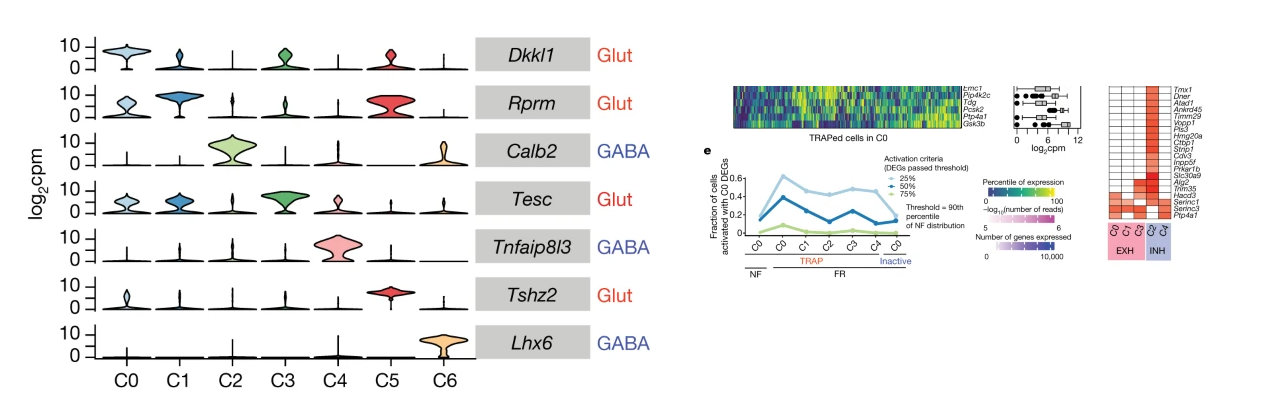

Mixed Models using nebula library, paper [here](https://www.nature.com/articles/s42003-021-02146-6) and the github reop [here](https://github.com/lhe17/nebula).  <br>
How to make a dataframe into a dgCMatrix, which nebula requires as input, [here](https://stackoverflow.com/questions/60189902/how-to-reshape-and-then-convert-a-data-frame-into-dgcmatrix/60190780?noredirect=1#comment106469434_60190780).

In [183]:
library(nebula)

In [201]:
packageVersion('nebula')

[1] '1.2.2'

In [184]:
# load the sample data from the nebula tutorial and use it as the basis for what we do
data(sample_data)
str(sample_data)

List of 4
 $ count :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:7655] 6 2 2 4 7 9 6 2 4 6 ...
  .. ..@ p       : int [1:6177] 0 1 2 3 3 3 5 5 6 7 ...
  .. ..@ Dim     : int [1:2] 10 6176
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:10] "A" "B" "C" "D" ...
  .. .. ..$ : NULL
  .. ..@ x       : num [1:7655] 1 1 2 1 1 1 2 1 2 1 ...
  .. ..@ factors : list()
 $ pred  :'data.frame':	6176 obs. of  3 variables:
  ..$ X1: num [1:6176] 0.616 1.461 1.668 -0.172 0.228 ...
  ..$ X2: num [1:6176] 0.976 0.976 0.976 0.976 0.976 ...
  ..$ cc: chr [1:6176] "control" "case" "control" "case" ...
 $ sid   : chr [1:6176] "1" "1" "1" "1" ...
 $ offset: num [1:6176] 1 1 1 1 1 1 1 1 1 1 ...


In [185]:
colnames(chen2020_meta)

[1] "Run"                 "Assay.Type"          "AvgSpotLen"         
 [4] "Bases"               "BioProject"          "BioSample"          
 [7] "Bytes"               "Cell_type"           "Center.Name"        
[10] "Consent"             "DATASTORE.filetype"  "DATASTORE.provider" 
[13] "DATASTORE.region"    "Experiment"          "GEO_Accession..exp."
[16] "Instrument"          "LibraryLayout"       "LibrarySelection"   
[19] "LibrarySource"       "Organism"            "Platform"           
[22] "ReleaseDate"         "Sample.Name"         "source_name"        
[25] "SRA.Study"           "engram_label"        "condition_label"    
[28] "X"                   "seurat_cluster_num"  "ChenLayerMarkers"   
[31] "TopTwoMarkers"       "BroadCellTypes"

In [186]:
table(chen2020_meta$ChenLayerMarkers)


    Calb2     Dkkl1      Lhx6      Rprm      Tesc Tnfaip8l3     Tshz2 
      576      1164       202       677       415       250       246 

In [187]:
# pull the dkkl1 neurons
dkkl1.idx <- chen2020_meta$ChenLayerMarkers=='Dkkl1'

dkkl1.counts.df <- chen2020_counts[,dkkl1.idx]
#dkkl1.counts.df <- data.frame(t(dkkl1.counts.df))
#rownames(dkkl1.counts.df) <- colnames(chen2020_counts)[dkkl1.idx]
#colnames(dkkl1.counts.df) <- rownames(chen2020_counts)
dim(dkkl1.counts.df)

[1] 23355  1164

In [188]:
#create lsit for filling
dkkl1_nebula <- vector(mode = "list", length = 4)
names(dkkl1_nebula ) <- c('count', 'id', 'pred', 'offset' )

In [189]:
# make prediction matrix
pred.df <- data.frame(Condition = chen2020_meta$condition_label[dkkl1.idx],
                     Label = chen2020_meta$engram_label[dkkl1.idx])
pred.df$Condition <- as.factor(pred.df$Condition)
pred.df$Label <- as.factor(pred.df$Label)

# put it in the list
#dkkl1_nebula$pred <- pred.df

# offset is the library size (umi)
# do this before gene filtering so we get the right UMI count
dkkl1_nebula$offset <- colSums(dkkl1.counts.df)
dkkl1_nebula$offset[1:5]

B1_T6_K7_S83_mouse1  D6_T3_H15_S91_mouse1 E3_T6_A10_S146_mouse1 
               570516                259323                302320 
 B7_T6_A8_S144_mouse1  B4_T8_I19_S47_mouse1 
              1116453                608682

In [190]:
# gene filtering, genes had to have at least 1 read more than 5 cells
chen.genefilter <- rowSums(chen2020_counts > 0) >= 5 # removes about 3k genes, use it later (not at cell level)
prot.coding.genes.ensmlble.df <- read.csv('/home/acampbell/PavLabEngrams/IEG_gradients/unique_stablestranscriptIDs_m39_gene_names.txt')
mouse.prot.coding.genes <- unique(prot.coding.genes.ensmlble.df$Gene.name)


# the cell filter doesn't make any difference as all teh cells provided already pass this threshold but it is included 
# for completeness, these are the criteria thye use to filter poor quality cells out
chen.cellfilter <- (colSums(chen2020_counts) > 50000) | (colSums(chen2020_counts > 0) >= 100)


# applying filter
dkkl1.counts.df <- dkkl1.counts.df[chen.genefilter,]
dkkl1.counts.df <- dkkl1.counts.df[rownames(dkkl1.counts.df) %in%  mouse.prot.coding.genes,]
dim(dkkl1.counts.df)

# adding counts as a sparese matrix 
dkkl1_nebula$count <- Matrix(as.matrix(dkkl1.counts.df),sparse=TRUE)
dim(dkkl1_nebula$count)
dkkl1_nebula$count[1:5,1:5]

[1] 14452  1164

[1] 14452  1164

5 x 5 sparse Matrix of class "dgCMatrix"
              B1_T6_K7_S83_mouse1 D6_T3_H15_S91_mouse1 E3_T6_A10_S146_mouse1
0610009B22Rik                  35                   27                    32
0610010K14Rik                   .                    .                     2
0610012G03Rik                  48                   18                    28
0610030E20Rik                   .                    .                     .
1110002E22Rik                   .                    .                     .
              B7_T6_A8_S144_mouse1 B4_T8_I19_S47_mouse1
0610009B22Rik                   76                    .
0610010K14Rik                    .                    4
0610012G03Rik                   17                   47
0610030E20Rik                    .                   24
1110002E22Rik                    .                    .

In [191]:
dkkl1_nebula$id <- chen2020_meta$source_name[dkkl1.idx]

In [192]:
str(dkkl1_nebula)

List of 4
 $ count :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:7345227] 0 2 5 7 8 9 11 12 14 16 ...
  .. ..@ p       : int [1:1165] 0 7004 15021 21855 28984 36680 42612 49651 57367 65682 ...
  .. ..@ Dim     : int [1:2] 14452 1164
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:14452] "0610009B22Rik" "0610010K14Rik" "0610012G03Rik" "0610030E20Rik" ...
  .. .. ..$ : chr [1:1164] "B1_T6_K7_S83_mouse1" "D6_T3_H15_S91_mouse1" "E3_T6_A10_S146_mouse1" "B7_T6_A8_S144_mouse1" ...
  .. ..@ x       : num [1:7345227] 35 48 103 4 27 11 29 16 9 182 ...
  .. ..@ factors : list()
 $ id    : chr [1:1164] "m5_Homecage" "m5_Homecage" "m5_Homecage" "m5_Homecage" ...
 $ pred  : NULL
 $ offset: Named num [1:1164] 570516 259323 302320 1116453 608682 ...
  ..- attr(*, "names")= chr [1:1164] "B1_T6_K7_S83_mouse1" "D6_T3_H15_S91_mouse1" "E3_T6_A10_S146_mouse1" "B7_T6_A8_S144_mouse1" ...


In [193]:
# setting the conditions as factors and ordering the levels so that Homecage and tdT- are the reference 'control' levels
pred.df$Label <- factor(pred.df$Label, levels = c("tdT-", "tdT+"))
pred.df$Condition <- factor(pred.df$Condition, levels = c("Homecage", "Context-Only", "Fear-Only", "Fear-Recall"))

In [194]:
# make the model and fit it
#pred.df$Label <- relevel(pred.df$Label,"med")
dkkl1.nebula.mm = model.matrix(~Condition*Label, data=pred.df)

# print to make sure the refernce levels are 'Homecage' and 'tdT-'
dim(dkkl1.nebula.mm)
head(dkkl1.nebula.mm)

[1] 1164    8

,(Intercept),ConditionContext-Only,ConditionFear-Only,ConditionFear-Recall,LabeltdT+,ConditionContext-Only:LabeltdT+,ConditionFear-Only:LabeltdT+,ConditionFear-Recall:LabeltdT+
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0
6,1,1,0,0,0,0,0,0


In [195]:
# group the cells by subject first with group_cell() from nebula

# Makes the meta and counts and organize them so all data from the same sources are consective to avoid this error when fitting
# the model in nebula: Error in nebula(dkkl1_nebula$count, dkkl1_nebula$sid, pred = dkkl1.nebula.df, : The cells of the same subject have to be grouped.
# from here:

dkkl1_nebula_g <- group_cell(count=dkkl1_nebula$count, 
                             id=dkkl1_nebula$id,
                             pred=dkkl1.nebula.mm,
                            dkkl1_nebula$offset)


In [196]:
str(sample_data)

List of 4
 $ count :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:7655] 6 2 2 4 7 9 6 2 4 6 ...
  .. ..@ p       : int [1:6177] 0 1 2 3 3 3 5 5 6 7 ...
  .. ..@ Dim     : int [1:2] 10 6176
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:10] "A" "B" "C" "D" ...
  .. .. ..$ : NULL
  .. ..@ x       : num [1:7655] 1 1 2 1 1 1 2 1 2 1 ...
  .. ..@ factors : list()
 $ pred  :'data.frame':	6176 obs. of  3 variables:
  ..$ X1: num [1:6176] 0.616 1.461 1.668 -0.172 0.228 ...
  ..$ X2: num [1:6176] 0.976 0.976 0.976 0.976 0.976 ...
  ..$ cc: chr [1:6176] "control" "case" "control" "case" ...
 $ sid   : chr [1:6176] "1" "1" "1" "1" ...
 $ offset: num [1:6176] 1 1 1 1 1 1 1 1 1 1 ...


In [197]:
str(dkkl1_nebula_g)

List of 4
 $ count :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:7345227] 0 2 5 7 8 9 11 12 14 16 ...
  .. ..@ p       : int [1:1165] 0 7004 15021 21855 28984 35885 42876 49418 53451 56694 ...
  .. ..@ Dim     : int [1:2] 14452 1164
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:14452] "0610009B22Rik" "0610010K14Rik" "0610012G03Rik" "0610030E20Rik" ...
  .. .. ..$ : chr [1:1164] "B1_T6_K7_S83_mouse1" "D6_T3_H15_S91_mouse1" "E3_T6_A10_S146_mouse1" "B7_T6_A8_S144_mouse1" ...
  .. ..@ x       : num [1:7345227] 35 48 103 4 27 11 29 16 9 182 ...
  .. ..@ factors : list()
 $ id    : num [1:1164] 1 1 1 1 1 1 1 1 1 1 ...
 $ pred  : num [1:1164, 1:8] 1 1 1 1 1 1 1 1 1 1 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:1164] "1" "2" "3" "4" ...
  .. ..$ : chr [1:8] "(Intercept)" "ConditionContext-Only" "ConditionFear-Only" "ConditionFear-Recall" ...
 $ offset: Named num [1:1164] 570516 259323 302320 1116453 253962 ...
  ..- attr(*, "names")= chr [

In [198]:
save(dkkl1_nebula_g, file='dkkl1_nebula_g.RData')

In [202]:
# for some reason ncore is not being used
#results.dkkl1.nebula <- nebula(dkkl1_nebula_g$count, dkkl1_nebula_g$id,
#                               pred=dkkl1_nebula_g$pred, offset=dkkl1_nebula_g$offset,
#                               output_re=TRUE, ncore=2)

results.dkkl1.nebula <- nebula(dkkl1_nebula_g$count, dkkl1_nebula_g$id,
                               pred=dkkl1_nebula_g$pred, offset=dkkl1_nebula_g$offset,
                               output_re=TRUE)

Remove  322  genes having low expression.
Analyzing  14130  genes with  19  subjects and  1164  cells.


Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"


In [203]:
summary(results.dkkl1.nebula)

               Length Class      Mode     
summary           26  data.frame list     
overdispersion     2  data.frame list     
convergence    14130  -none-     numeric  
algorithm      14130  -none-     character
covariance         0  -none-     NULL     
random_effect     19  data.frame list     

In [204]:
dkkl1.nebula.re <- results.dkkl1.nebula$summary
dim(dkkl1.nebula.re)
head(dkkl1.nebula.re)

[1] 14130    26

,logFC_(Intercept),logFC_ConditionContext-Only,logFC_ConditionFear-Only,logFC_ConditionFear-Recall,logFC_LabeltdT+,logFC_ConditionContext-Only:LabeltdT+,logFC_ConditionFear-Only:LabeltdT+,logFC_ConditionFear-Recall:LabeltdT+,se_(Intercept),se_ConditionContext-Only,...,p_(Intercept),p_ConditionContext-Only,p_ConditionFear-Only,p_ConditionFear-Recall,p_LabeltdT+,p_ConditionContext-Only:LabeltdT+,p_ConditionFear-Only:LabeltdT+,p_ConditionFear-Recall:LabeltdT+,gene_id,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,-9.528390,-0.01316455,-0.332336009,-0.10832026,0.39913902,-0.49458238,-0.201734715,-0.53379557,0.04414002,0.2137072,...,0,0.9508807,0.1530572,0.62466741,0.1440327,0.10699961,0.57163144,0.08174622,1,0610009B22Rik
2,-12.445302,-0.28380407,-0.439649892,0.08703862,-0.50671222,0.89438969,0.437591111,0.29002862,0.11106374,0.3460587,...,0,0.4121569,0.2450059,0.80855466,0.1499632,0.01952429,0.31678942,0.45321896,2,0610010K14Rik
3,-9.068552,-0.03025707,0.002309758,-0.24823968,0.23617318,-0.48428376,-0.398495831,-0.31921043,0.06167345,0.1903855,...,0,0.8737277,0.9911204,0.20734314,0.1948243,0.01570043,0.08070991,0.11258349,3,0610012G03Rik
4,-11.241963,0.31130997,0.302360520,0.28231525,0.85578811,-0.61655198,-0.276134489,-0.55197282,0.08873563,0.4537971,...,0,0.4927060,0.5389142,0.54786848,0.1424801,0.34746659,0.71701442,0.39981884,4,0610030E20Rik
5,-12.641463,0.58310680,1.019881206,1.56539659,0.94271153,-0.84841582,-1.178379185,-1.95849351,0.15474210,0.7956889,...,0,0.4636605,0.2362082,0.05671941,0.3558309,0.45982100,0.37632598,0.08728481,5,1110002E22Rik
6,-8.164010,0.01752274,0.020648485,-0.11819826,-0.06184341,-0.05424002,0.004182661,0.07447777,0.02057612,0.1041181,...,0,0.8663498,0.8550276,0.27294913,0.6444450,0.71885239,0.98094921,0.62075871,6,1110004F10Rik


In [205]:
dim(results.dkkl1.nebula$random_effect)
head(results.dkkl1.nebula$random_effect)

[1] 14130    19

,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9,random_10,random_11,random_12,random_13,random_14,random_15,random_16,random_17,random_18,random_19
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.516056e-04,-0.0066299555,1.615285e-02,5.388090e-03,3.939833e-05,-2.830354e-03,-2.060445e-02,-5.729104e-03,0.0337193378,-1.471392e-02,-4.494778e-03,6.624958e-03,-1.452233e-02,3.114253e-02,-3.347769e-03,-2.942613e-03,6.796965e-03,-2.997649e-03,1.740094e-03
2,-1.041159e-01,0.3266908696,-5.035127e-02,5.530997e-01,-1.145595e-02,-6.629266e-01,9.843262e-04,7.964479e-02,0.0482361961,2.919490e-01,-2.942165e-01,6.239034e-01,-1.061162e-02,6.058261e-03,-4.799214e-01,1.921243e-01,-1.285509e-01,1.109181e-01,-1.268474e-01
3,-2.196876e-01,-0.1240893922,-1.345470e-01,-4.989151e-03,-1.348974e-01,1.230475e-01,-2.652899e-01,-1.342172e-01,0.0887425603,-2.226654e-01,2.386687e-01,2.009294e-01,1.421444e-01,3.579177e-01,3.917458e-02,-9.696551e-02,1.824323e-01,6.798327e-02,2.051783e-02
4,1.091266e-05,0.0003815768,-7.142323e-05,6.522983e-05,3.918215e-05,1.121133e-05,4.082151e-04,5.558826e-05,0.0001319960,4.978481e-05,1.766526e-05,1.404978e-05,-1.043421e-04,-3.642507e-04,-3.084629e-05,2.184927e-05,1.125241e-04,-5.039765e-06,2.058670e-04
5,-1.977592e-05,0.0001246248,3.182815e-05,1.477302e-04,2.482232e-05,9.841848e-06,7.861912e-05,4.761104e-05,0.0002987309,-1.650195e-05,-1.102575e-04,1.176016e-04,-1.961291e-06,1.688391e-05,6.731277e-05,8.038119e-06,5.956073e-05,3.037134e-05,3.485661e-05
6,-1.419631e-04,0.0001057613,-2.695316e-04,-7.343565e-04,-1.288345e-04,1.587646e-03,-9.194908e-04,-6.054222e-04,-0.0004272382,9.214490e-04,-3.187744e-04,6.420159e-04,1.628289e-03,-2.968565e-04,-9.242304e-04,-3.596670e-05,-4.401187e-04,6.790114e-04,6.233452e-04


In [206]:
colnames(dkkl1.nebula.re)

[1] "logFC_(Intercept)"                    
 [2] "logFC_ConditionContext-Only"          
 [3] "logFC_ConditionFear-Only"             
 [4] "logFC_ConditionFear-Recall"           
 [5] "logFC_LabeltdT+"                      
 [6] "logFC_ConditionContext-Only:LabeltdT+"
 [7] "logFC_ConditionFear-Only:LabeltdT+"   
 [8] "logFC_ConditionFear-Recall:LabeltdT+" 
 [9] "se_(Intercept)"                       
[10] "se_ConditionContext-Only"             
[11] "se_ConditionFear-Only"                
[12] "se_ConditionFear-Recall"              
[13] "se_LabeltdT+"                         
[14] "se_ConditionContext-Only:LabeltdT+"   
[15] "se_ConditionFear-Only:LabeltdT+"      
[16] "se_ConditionFear-Recall:LabeltdT+"    
[17] "p_(Intercept)"                        
[18] "p_ConditionContext-Only"              
[19] "p_ConditionFear-Only"                 
[20] "p_ConditionFear-Recall"               
[21] "p_LabeltdT+"                          
[22] "p_ConditionContext-Only:LabeltdT+"    
[23] "p_ConditionFear-Only:LabeltdT+"       
[24] "p_ConditionFear-Recall:LabeltdT+"     
[25] "gene_id"                              
[26] "gene"

Could try plotting distribution of random effects and then marking the DEGs from Chen in red or something.  Maybe take the average.
Then plot individual gene expression from those replicates. Compared to genes found by the mixed effects model.

In [207]:
dkkl1.nebula.re <- na.omit(dkkl1.nebula.re)
dim(dkkl1.nebula.re)

[1] 13756    26

In [208]:
# setting the fdr for the tests
mixedmod.fdrthresh <- 0.05

In [209]:
pvals.frpos <- dkkl1.nebula.re[,'p_ConditionFear-Recall:LabeltdT+']
pvals.frpos[1:5]
min(pvals.frpos, na.rm = TRUE)
length(pvals.frpos)

[1] 0.08174622 0.45321896 0.11258349 0.39981884 0.08728481

[1] 0

[1] 13756

In [210]:
head(dkkl1.nebula.re[is.na(pvals.frpos),'gene'])

character(0)

In [211]:
Qvals.bh.frpos <- p.adjust(pvals.frpos,method="BH")
Qvals.bh.frpos[1:5]
min(Qvals.bh.frpos, na.rm = TRUE)
length(Qvals.bh.frpos)

[1] 0.8839356 1.0000000 0.9341112 1.0000000 0.8928596

[1] 0

[1] 13756

In [212]:
frpos.passed_fdr <- Qvals.bh.frpos< mixedmod.fdrthresh
length(frpos.passed_fdr)
sum(frpos.passed_fdr)

[1] 13756

[1] 15

In [213]:
dkkl1_nebula_degs.list <- dkkl1.nebula.re$gene[frpos.passed_fdr]
dkkl1_nebula_degs.list

[1] "Atp5e"   "Bola2"   "Chchd1"  "Cox16"   "Mrpl14"  "Mrpl23"  "Naa38"  
 [8] "Ndufa12" "Ndufb9"  "Nxn"     "Ocln"    "Pomt1"   "Rad51"   "Selenos"
[15] "Slc6a16"

In [214]:
dkkl1_nebula_degs.list[dkkl1_nebula_degs.list %in% dkkl1_rem_markers]

character(0)

In [215]:
dkkl1.nebula.re[dkkl1.nebula.re$gene %in% dkkl1_nebula_degs.list, c('gene','logFC_ConditionFear-Recall:LabeltdT+')]

,gene,logFC_ConditionFear-Recall:LabeltdT+
,<chr>,<dbl>
1060,Atp5e,-0.6472114
1332,Bola2,-1.1343893
2022,Chchd1,-0.9980617
2369,Cox16,-1.1795732
6432,Mrpl14,-1.3059979
6442,Mrpl23,-1.0075486
6693,Naa38,-1.0817595
6810,Ndufa12,-0.8300811
6839,Ndufb9,-0.7053307


5 genes pass threshold this is at an FDR of 0.05, 0.1, or 0.2.  Few of the DEGs found by nebula at a threshold of 0.2, 0.1, 0.05
are reported as being upregulated.  Only one, Lad1 shows a large upregulated effect.

In [216]:
# looking at the subject effect intercept
pvals.anypos <- dkkl1.nebula.re[,'p_LabeltdT+']
Qvals.bh.anypos <- p.adjust(pvals.anypos,method="BH")
anypos.passed_fdr <- Qvals.bh.anypos < mixedmod.fdrthresh
length(anypos.passed_fdr)
sum(anypos.passed_fdr)

[1] 13756

[1] 83

In [217]:
dkkl1_nebula_degs.anypos.list <- dkkl1.nebula.re$gene[anypos.passed_fdr]
dkkl1_nebula_degs.anypos.list

[1] "Ampd3"    "Ankrd28"  "Atp5e"    "Atpif1"   "Bola2"    "Calm3"   
 [7] "Ccl27a"   "Cdc42se1" "Cdk5r1"   "Chchd1"   "Chd1l"    "Cox16"   
[13] "Cox4i1"   "Cox6c"    "Cox7c"    "Dlg4"     "Dnajc15"  "Dsel"    
[19] "Eif3k"    "Elmod1"   "Elob"     "Evl"      "Fabp3"    "Fau"     
[25] "Fcf1"     "Fkbp2"    "Gm2000"   "Gng13"    "Ktn1"     "Lsm7"    
[31] "Mrpl14"   "Mrpl23"   "Mrpl52"   "Mrps21"   "Mysm1"    "Naa38"   
[37] "Ndufa12"  "Ndufa13"  "Ndufa2"   "Ndufa6"   "Ndufa7"   "Ndufa8"  
[43] "Ndufaf3"  "Ndufb9"   "Ndufc1"   "Ndufs5"   "Nedd8"    "Nxn"     
[49] "Ocln"     "Pomt1"    "Psma2"    "Ptrhd1"   "Rad51"    "Rbm45"   
[55] "Rpl18a"   "Rpl35"    "Rpl35a"   "Rpl38"    "Rpl41"    "Rplp1"   
[61] "Rps13"    "Rps18"    "Rps29"    "Rps7"     "Rps8"     "Sde2"    
[67] "Selenos"  "Serf2"    "Sgtb"     "Slc6a16"  "Smim18"   "Snrpg"   
[73] "Son"      "Spats2l"  "Sub1"     "Tma7"     "Tmem267"  "Tomm7"   
[79] "Uba52"    "Uqcr10"   "Uqcr11"   "Washc5"   "Zfp664"

In [218]:
dkkl1_nebula_degs.anypos.list[dkkl1_nebula_degs.anypos.list %in% dkkl1_rem_markers]

character(0)

In [219]:
dkkl1.nebula.re[dkkl1.nebula.re$gene %in% dkkl1_nebula_degs.anypos.list, c('gene','logFC_LabeltdT+')]

,gene,logFC_LabeltdT+
,<chr>,<dbl>
612,Ampd3,-4.6787255
663,Ankrd28,3.6960991
1060,Atp5e,0.6183615
1100,Atpif1,0.5568981
1332,Bola2,1.2945190
1494,Calm3,0.4124203
1724,Ccl27a,0.6301852
1823,Cdc42se1,1.3857165
1867,Cdk5r1,0.6225290


In general the labelled condition is showing more DEGs than the FR:tdT+ interaction.  Most of the effects are weak and not worth discussing.

## Nebula V2 with all controls as one condition

Running this Again but with a simpler model to fit better, we are getting so many fit errors because of the number of levels in the conditions.  We can reduce this by placeing all the controls (homecage, Context-only, No-Recall) into one label 'Control', as that's basically what they are.

In [220]:
# create new design matrix, it will be simpler only having 2 conditions
pred.dfv2 <- pred.df
pred.dfv2$Condition <- sapply(as.character(pred.dfv2$Condition), 
                              function(y) if (grepl("Fear-Recall", y, fixed=TRUE)) "Fear-Recall" else "Control")
pred.dfv2$Condition <- factor(pred.dfv2$Condition, levels = c("Control", "Fear-Recall"))

In [221]:
# make the model and fit it
#pred.df$Label <- relevel(pred.df$Label,"med")
dkkl1.nebula.mmv2 = model.matrix(~Condition*Label, data=pred.dfv2)

# print to make sure the refernce levels are 'Homecage' and 'tdT-'
dim(dkkl1.nebula.mmv2)
head(dkkl1.nebula.mmv2)

[1] 1164    4

,(Intercept),ConditionFear-Recall,LabeltdT+,ConditionFear-Recall:LabeltdT+
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0


In [222]:
# group the cells by subject first with group_cell() from nebula

# Makes the meta and counts and organize them so all data from the same sources are consective to avoid this error when fitting
# the model in nebula: Error in nebula(dkkl1_nebula$count, dkkl1_nebula$sid, pred = dkkl1.nebula.df, : The cells of the same subject have to be grouped.
# from here:

dkkl1_nebula_g_v2 <- group_cell(count=dkkl1_nebula$count, 
                                id=dkkl1_nebula$id,
                                pred=dkkl1.nebula.mmv2,
                                offset = dkkl1_nebula$offset)

In [226]:
# ncore is now for some reason producing an unused argument error

#results.dkkl1.nebula_V2 <- nebula(dkkl1_nebula_g_v2$count, dkkl1_nebula_g_v2$id,
#                               pred=dkkl1_nebula_g_v2$pred, offset=dkkl1_nebula_g_v2$offset,
#                               output_re=TRUE,  covariance=TRUE,
#                                  ncore=2)
results.dkkl1.nebula_V2 <- nebula(dkkl1_nebula_g_v2$count, dkkl1_nebula_g_v2$id,
                               pred=dkkl1_nebula_g_v2$pred, offset=dkkl1_nebula_g_v2$offset,
                               output_re=TRUE,  covariance=TRUE)

Remove  322  genes having low expression.
Analyzing  14130  genes with  19  subjects and  1164  cells.


Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"
Warning message in sqrt(re_all[, i]):
"NaNs produced"


In [227]:
dkkl1.nebula.re_V2 <- results.dkkl1.nebula_V2$summary
dim(dkkl1.nebula.re_V2)
head(dkkl1.nebula.re_V2)

[1] 14130    14

,logFC_(Intercept),logFC_ConditionFear-Recall,logFC_LabeltdT+,logFC_ConditionFear-Recall:LabeltdT+,se_(Intercept),se_ConditionFear-Recall,se_LabeltdT+,se_ConditionFear-Recall:LabeltdT+,p_(Intercept),p_ConditionFear-Recall,p_LabeltdT+,p_ConditionFear-Recall:LabeltdT+,gene_id,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,-9.540718,-0.03073016,0.06261161,-0.21077467,0.05340680,0.15437177,0.10969508,0.17809902,0,0.84221118,0.56814970,0.23662333,1,0610009B22Rik
2,-12.444669,0.35716970,0.18595228,-0.40615046,0.11854361,0.27813476,0.12255468,0.20233683,0,0.19908576,0.12919083,0.04471786,2,0610010K14Rik
3,-9.060694,-0.24977449,-0.16795896,0.08506332,0.06112673,0.14365612,0.06680632,0.10857140,0,0.08208806,0.01193306,0.43334636,3,0610012G03Rik
4,-11.236791,0.01751851,0.40559753,-0.10178135,0.08881121,0.29535122,0.23209549,0.37863161,0,0.95270188,0.08054268,0.78807308,4,0610030E20Rik
5,-12.623911,0.89117470,0.06891316,-1.08473216,0.15511258,0.51394268,0.40588367,0.66012267,0,0.08291874,0.86517884,0.10033573,5,1110002E22Rik
6,-8.163918,-0.13388978,-0.09704439,0.10968012,0.02058498,0.06791681,0.05327589,0.08685249,0,0.04868054,0.06852417,0.20664949,6,1110004F10Rik


In [228]:
# remove geens that fail to converge for any parameter
dkkl1.nebula.re_V2 <- na.omit(dkkl1.nebula.re_V2)
dim(dkkl1.nebula.re_V2)

[1] 14015    14

In [229]:
# Now we must account for overdisperssion in subject and cell level overdispersion parameters

In [230]:
overdispersed.subject <-results.dkkl1.nebula_V2$summary$gene[results.dkkl1.nebula_V2$overdispersion$Subject>1]
length(overdispersed.subject)
overdispersed.subject

[1] 84

[1] "Ankrd1"        "Bach1"         "Dchs2"         "Dock11"       
 [5] "Egfl6"         "Erbb4"         "Fgl1"          "Fzd4"         
 [9] "Gab1"          "Glipr2"        "Il1r1"         "Itgb1bp2"     
[13] "Krt9"          "Nox4"          "Nupr1"         "Plekhf1"      
[17] "Prox1"         "Ret"           "Sfrp2"         "Slc32a1"      
[21] "Sox2"          "Tac1"          "Tns3"          "Trh"          
[25] "Trip13"        "Zfp217"        "1520401A03Rik" "4921536K21Rik"
[29] "4931429L15Rik" "A930018P22Rik" "Alpl"          "Axdnd1"       
[33] "Bgn"           "Cc2d2b"        "Ccdc146"       "Ccdc8"        
[37] "Cxcl16"        "Dnah8"         "Dusp13"        "Edar"         
[41] "Efcab9"        "F13a1"         "Fa2h"          "Fmo1"         
[45] "Fpr1"          "Gfy"           "Gjc3"          "Gm3629"       
[49] "Gtse1"         "Hs3st3a1"      "Klf14"         "Klhdc7b"      
[53] "Kmo"           "Mal"           "Map3k19"       "Mc1r"         
[57] "Mfsd2b"        "Mup3"          "Olig2"         "Pappa2"       
[61] "Pole2"         "Prss41"        "Pyroxd2"       "Rab37"        
[65] "Rbpms"         "Ribc1"         "Rs1"           "Slc16a5"      
[69] "Slc9b1"        "Syt2"          "Thsd1"         "Timp1"        
[73] "Tll1"          "Tmem253"       "Tmem51"        "Trf"          
[77] "Uaca"          "Vpreb3"        "Clec3b"        "Clic3"        
[81] "Hao1"          "Oxct2a"        "Pdia2"         "Trat1"

In [231]:
overdispersed.cell <- results.dkkl1.nebula_V2$summary$gene[results.dkkl1.nebula_V2$overdispersion$Cell>100]
length(overdispersed.cell)
overdispersed.cell

[1] 2441

[1] "1700010I14Rik" "1810020O05Rik" "2010109A12Rik" "2410137M14Rik"
   [5] "2610318N02Rik" "4921507P07Rik" "4930524B15Rik" "4930590J08Rik"
   [9] "4933405L10Rik" "6430550D23Rik" "9930012K11Rik" "A830031A19Rik"
  [13] "A930003A15Rik" "AA986860"      "AW551984"      "Abca1"        
  [17] "Abca17"        "Abca6"         "Abcb4"         "Abtb2"        
  [21] "Acad12"        "Acbd7"         "Accs"          "Ackr4"        
  [25] "Acot11"        "Acr"           "Acsbg1"        "Actn3"        
  [29] "Acvrl1"        "Adam12"        "Adam21"        "Adam4"        
  [33] "Adamts15"      "Adamts16"      "Adamts4"       "Adarb2"       
  [37] "Adgra2"        "Adgrg2"        "Adgrv1"        "Adhfe1"       
  [41] "Adra2b"        "Adrb2"         "Aebp1"         "Agt"          
  [45] "Agtr1a"        "Agtr2"         "Agtrap"        "Ahnak"        
  [49] "Ahnak2"        "Aifm2"         "Aim2"          "Akain1"       
  [53] "Alas2"         "Aldh1l2"       "Aldh3a1"       "Alk"          
  [57] "Allc"          "Alox8"         "Alpk1"         "Alpk3"        
  [61] "Amdhd1"        "Amhr2"         "Amigo3"        "Angpt1"       
  [65] "Angptl1"       "Angptl2"       "Ankdd1a"       "Ankrd1"       
  [69] "Ankrd55"       "Ankrd63"       "Anks4b"        "Ano5"         
  [73] "Ano7"          "Antxr2"        "Anxa2"         "Anxa9"        
  [77] "Aox3"          "Aox4"          "Ap5b1"         "Apbb1ip"      
  [81] "Apobec3"       "Apod"          "Apoh"          "Aqp4"         
  [85] "Aqp5"          "Areg"          "Arhgap11a"     "Arhgap18"     
  [89] "Arhgap24"      "Arhgap36"      "Arhgap4"       "Arhgap40"     
  [93] "Arhgap6"       "Arhgdib"       "Arhgef10"      "Arhgef6"      
  [97] "Arid3c"        "Arpc1b"        "Arsg"          "Arsi"         
 [101] "As3mt"         "Asah2"         "Asb16"         "Asb18"        
 [105] "Asb5"          "Ascl4"         "Asf1b"         "Asic4"        
 [109] "Aspdh"         "Aspg"          "Asprv1"        "Atf3"         
 [113] "Atoh8"         "Atp10a"        "Atp10d"        "Atp12a"       
 [117] "Atp4a"         "Aurka"         "B3gnt5"        "B3gnt7"       
 [121] "B3gnt9"        "BC034090"      "BC035947"      "Bach1"        
 [125] "Bag3"          "Baiap2l1"      "Baiap3"        "Bcam"         
 [129] "Bcl2l11"       "Bcl3"          "Bfsp1"         "Birc3"        
 [133] "Bmp7"          "Bmpr1b"        "Bpifb1"        "Brca1"        
 [137] "Bspry"         "Btbd11"        "Btc"           "Bub1b"        
 [141] "Bves"          "C1ql1"         "C1qtnf2"       "C1qtnf6"      
 [145] "C1s1"          "C2"            "C3ar1"         "C7"           
 [149] "Cachd1"        "Cacna2d4"      "Cacng5"        "Calb2"        
 [153] "Cald1"         "Cand2"         "Capn6"         "Capsl"        
 [157] "Car8"          "Card10"        "Carhsp1"       "Cartpt"       
 [161] "Casc1"         "Catip"         "Catsperd"      "Catsperg1"    
 [165] "Catsperg2"     "Cbs"           "Cbx2"          "Cby3"         
 [169] "Ccdc105"       "Ccdc110"       "Ccdc162"       "Ccdc18"       
 [173] "Ccdc187"       "Ccdc40"        "Ccdc81"        "Ccdc89"       
 [177] "Ccdc96"        "Ccer2"         "Ccna1"         "Ccnb2"        
 [181] "Cd4"           "Cdc20"         "Cdc25c"        "Cdc45"        
 [185] "Cdca3"         "Cdca7"         "Cdh15"         "Cdh23"        
 [189] "Cdh24"         "Cdhr1"         "Cdhr3"         "Cdnf"         
 [193] "Cebpd"         "Cecr2"         "Cenpa"         "Cenpe"        
 [197] "Cenpj"         "Cenpn"         "Cep128"        "Cep72"        
 [201] "Cer1"          "Ces5a"         "Cfap161"       "Cfap221"      
 [205] "Cfap43"        "Cfap57"        "Cgnl1"         "Ch25h"        
 [209] "Chaf1b"        "Chek2"         "Chia1"         "Chrm5"        
 [213] "Chrna3"        "Chrna5"        "Chrna7"        "Chrnb1"       
 [217] "Chst7"         "Chst9"         "Chtf18"        "Cideb"        
 [221] "Cilp2"         "Clca3a1"       "Cldn1"         "Cldn10"       
 [225] "Cldn23"        "Cle

In [232]:
# remove the overdisperssed genes
dkkl1.nebula.re_V2 <- dkkl1.nebula.re_V2[!(dkkl1.nebula.re_V2$gene %in% overdispersed.cell),]
dkkl1.nebula.re_V2 <- dkkl1.nebula.re_V2[!(dkkl1.nebula.re_V2$gene %in% overdispersed.subject),]

# check size
dim(dkkl1.nebula.re_V2)

[1] 11687    14

Check for Fear-Recall specific effects.

In [233]:
pvals.frposV2 <- dkkl1.nebula.re_V2[,'p_ConditionFear-Recall:LabeltdT+']
pvals.frposV2[1:5]
min(pvals.frposV2, na.rm = TRUE)
length(pvals.frposV2)

[1] 0.23662333 0.04471786 0.43334636 0.78807308 0.10033573

[1] 1.815872e-11

[1] 11687

In [234]:
Qvals.bh.frposV2 <- p.adjust(pvals.frposV2,method="BH")
Qvals.bh.frposV2[1:5]
min(Qvals.bh.frposV2, na.rm = TRUE)
length(Qvals.bh.frposV2)

[1] 0.8479444 0.5155961 0.9288704 0.9936877 0.6922851

[1] 2.122209e-07

[1] 11687

In [235]:
frpos.passed_fdrV2 <- Qvals.bh.frposV2 < mixedmod.fdrthresh
length(frpos.passed_fdrV2)
sum(frpos.passed_fdrV2)

[1] 11687

[1] 108

In [236]:
dkkl1_nebula_degs.listV2 <- dkkl1.nebula.re_V2$gene[frpos.passed_fdrV2]
dkkl1_nebula_degs.listV2

[1] "4931428F04Rik" "Abcg1"         "Acsl4"         "Actb"         
  [5] "Actr2"         "Akap5"         "Ap1b1"         "Apba2"        
  [9] "App"           "Atg9a"         "Atp1a3"        "B3galt1"      
 [13] "Bzw1"          "Camk2n1"       "Canx"          "Caprin1"      
 [17] "Cbx3"          "Ccng1"         "Cdc42se2"      "Chmp4c"       
 [21] "Cit"           "Clasp2"        "Cnot7"         "Cox16"        
 [25] "Csnk2a1"       "Cul2"          "Ddhd2"         "Dnm1l"        
 [29] "Dpysl2"        "Emc1"          "Etv5"          "Fbxw7"        
 [33] "Frat1"         "Fry"           "Fscn1"         "Gadl1"        
 [37] "Gda"           "Gm11808"       "Gm12184"       "Gm9844"       
 [41] "Gnb1"          "Gnl3l"         "Golga7b"       "Gpm6a"        
 [45] "Gpm6b"         "Gprasp2"       "Gsk3b"         "Inpp4a"       
 [49] "Jak3"          "Jup"           "Klf13"         "Lrp11"        
 [53] "Lrrc8a"        "Lzts1"         "Marcks"        "Micu3"        
 [57] "Mrpl14"        "Napg"          "Ndrg4"         "Nudt3"        
 [61] "Ocel1"         "Paf1"          "Paip1"         "Pdha1"        
 [65] "Plekhb2"       "Ppm1b"         "Ppm1h"         "Ppp1r16b"     
 [69] "Ppp3r1"        "Prepl"         "Prkar1a"       "Psap"         
 [73] "Ptma"          "Ptp4a2"        "Rab11a"        "Reep5"        
 [77] "Rnf14"         "Rps25"         "Rtn3"          "Scand1"       
 [81] "Scn2b"         "Serpini1"      "Set"           "Sfxn5"        
 [85] "Sh3gl2"        "Skil"          "Sod1"          "Ssr1"         
 [89] "St13"          "Strn"          "Strn4"         "Stxbp1"       
 [93] "Syn1"          "Syp"           "Syt16"         "Taok1"        
 [97] "Tm9sf2"        "Tmem68"        "Tomm20"        "Trim35"       
[101] "Ubqln1"        "Usp5"          "Vip"           "Vps35"        
[105] "Vstm2a"        "Wapl"          "Wdr47"         "Zscan26"

In [237]:
DEG.frpsV2 <- dkkl1.nebula.re_V2[dkkl1.nebula.re_V2$gene %in% dkkl1_nebula_degs.listV2,
                   c('gene','p_ConditionFear-Recall:LabeltdT+','logFC_ConditionFear-Recall:LabeltdT+')]

DEG.frpsV2$'q_ConditionFear-Recall:LabeltdT+' <- Qvals.bh.frposV2[frpos.passed_fdrV2]

colnames(DEG.frpsV2)

[1] "gene"                                
[2] "p_ConditionFear-Recall:LabeltdT+"    
[3] "logFC_ConditionFear-Recall:LabeltdT+"

We now filter down for this list crossing a minimum FDR of 0.05 (which is more lenient than the original authors FDR) and we restrict it to a fold change of 1 in either direction.  In total this leaves us with 5 genes specific to the condition.None of the authors original DEGs for this cell type are in the DEG list at all (even without the FC threshold, so simply based on significance).

In [238]:
DEG.frpsV2[(DEG.frpsV2$'logFC_ConditionFear-Recall:LabeltdT+' > 1) | (DEG.frpsV2$'logFC_ConditionFear-Recall:LabeltdT+' < -1),]

,gene,p_ConditionFear-Recall:LabeltdT+,logFC_ConditionFear-Recall:LabeltdT+
,<chr>,<dbl>,<dbl>
112,4931428F04Rik,2.456777e-04,1.250409
2063,Chmp4c,9.058489e-05,-3.510286
5266,Jak3,6.595100e-05,3.594015
7280,Ocel1,2.854298e-04,1.189920
11865,Vip,3.401327e-06,-5.666256


In [239]:
pvals.anyposV2 <- dkkl1.nebula.re_V2[,'p_LabeltdT+']
Qvals.bh.anyposV2 <- p.adjust(pvals.anyposV2,method="BH")
anyposV2.passed_fdrV2 <- Qvals.bh.anyposV2 < mixedmod.fdrthresh
anyposV2_nebula_degs.listV2 <- dkkl1.nebula.re_V2$gene[anyposV2.passed_fdrV2]
length(anyposV2.passed_fdrV2)

[1] 11687

In [240]:
DEG.anyposV2 <- dkkl1.nebula.re_V2[dkkl1.nebula.re_V2$gene %in% anyposV2_nebula_degs.listV2,
                   c('gene','p_ConditionFear-Recall:LabeltdT+','logFC_ConditionFear-Recall:LabeltdT+')]
colnames(DEG.anyposV2)

[1] "gene"                                
[2] "p_ConditionFear-Recall:LabeltdT+"    
[3] "logFC_ConditionFear-Recall:LabeltdT+"

In [241]:
dim(DEG.anyposV2)
head(DEG.anyposV2)

[1] 1144    3

,gene,p_ConditionFear-Recall:LabeltdT+,logFC_ConditionFear-Recall:LabeltdT+
,<chr>,<dbl>,<dbl>
20,1700001L19Rik,0.08391439,-0.33319556
37,1700037H04Rik,0.52344118,0.10051659
49,1810037I17Rik,0.08861029,-0.15766965
61,2310009B15Rik,0.16065404,-0.37579621
66,2310033P09Rik,0.86614928,0.03333583
71,2410002F23Rik,0.23764276,0.17939857


In [242]:
DEG.anyposV2[(DEG.anyposV2$'logFC_ConditionFear-Recall:LabeltdT+' > 1) | (DEG.anyposV2$'logFC_ConditionFear-Recall:LabeltdT+' < -1),]

,gene,p_ConditionFear-Recall:LabeltdT+,logFC_ConditionFear-Recall:LabeltdT+
,<chr>,<dbl>,<dbl>
698,Ano8,1.015537e-03,1.350451
1146,B3gnt2,1.283778e-02,1.145021
1179,BC049715,1.219477e-01,1.015506
1994,Cfap44,2.720777e-02,2.144019
2098,Chsy3,1.930117e-02,1.332527
2592,Cxcl14,1.415203e-03,-2.600684
2900,Dlec1,1.252386e-01,1.550779
3773,Fbxo5,5.259386e-03,3.573653
4098,Gbe1,1.611927e-03,1.540115


Overall the effect of the cell labelling results in many DEGs but those specific to the fear recall condition are limited.  

In [243]:
# recall our model matrix with a total of 4 factors...
dim(dkkl1.nebula.mmv2)
head(dkkl1.nebula.mmv2)

[1] 1164    4

,(Intercept),ConditionFear-Recall,LabeltdT+,ConditionFear-Recall:LabeltdT+
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0


In [244]:
# gives us a 4 by 4 covarience matrix
cov= matrix(NA,4,4)
cov[lower.tri(cov,diag=T)] = as.numeric(results.dkkl1.nebula_V2$covariance[1,])
cov[upper.tri(cov)] = t(cov)[upper.tri(cov)]
cov

2.852286e-03,0.0006891613,5.433294e-05,6.554498e-05
6.891613e-04,0.0238306445,5.545125e-03,-1.884304e-02
5.433294e-05,0.0055451247,1.203301e-02,-1.203301e-02
6.554498e-05,-0.0188430396,-1.203301e-02,3.171926e-02


In [245]:
dim(dkkl1.nebula.re_V2)

[1] 11687    14

No chen markers are in the over disperessed genes.

In [246]:
sum(chen_remotememory_markers %in% c(overdispersed.cell, overdispersed.subject))
chen_remotememory_markers[chen_remotememory_markers %in% overdispersed.cell]
chen_remotememory_markers[chen_remotememory_markers %in% overdispersed.subject]

[1] 0

character(0)

character(0)

In [270]:
## the genes to test
#only the genes that didn't have na's produced when fitting everything
genes = dkkl1.nebula.re_V2$gene_id

## build the contrast vector
contrast = c(0,-1/2,-1/2,1)
## testing the hypothesis
effects <- c()
pvals <- c()

for(gene_i in genes){

    # create covarience matrix for that gene
    cov= matrix(NA,4,4)
    cov[lower.tri(cov,diag=T)] = as.numeric(results.dkkl1.nebula_V2$covariance[gene_i,])
    cov[upper.tri(cov)] = t(cov)[upper.tri(cov)]
    
    # 
    eff <- sum(contrast*results.dkkl1.nebula_V2$summary[gene_i,1:4])  
    effects <- c( effects, eff)
    p <- pchisq(eff^2/(t(contrast)%*%cov%*%contrast),1,lower.tail=FALSE)
    pvals <- c(pvals , p)
}

FRpos.contrast <- data.frame(gene = dkkl1.nebula.re_V2$gene,
                             contrast_p = pvals,
                             contrast_effect = effects)

FRpos.contrast <- na.omit(FRpos.contrast)
FRpos.contrast$contrast_qval <- p.adjust(FRpos.contrast$contrast_p,  method = 'BH')
dim(FRpos.contrast)
head(FRpos.contrast)

[1] 11678     4

,gene,contrast_p,contrast_effect,contrast_qval
,<chr>,<dbl>,<dbl>,<dbl>
1,0610009B22Rik,0.40566353,-0.2267154,0.9056545
2,0610010K14Rik,0.03709097,-0.6777114,0.4260934
3,0610012G03Rik,0.09009836,0.2939300,0.6143344
4,0610030E20Rik,0.58677411,-0.3133394,0.9754206
5,1110002E22Rik,0.11956096,-1.5647761,0.6743060
6,1110004F10Rik,0.08859693,0.2251472,0.6101182


In [271]:
test <- FRpos.contrast$gene[FRpos.contrast$contrast_qval < 0.01]
length(test)

[1] 97

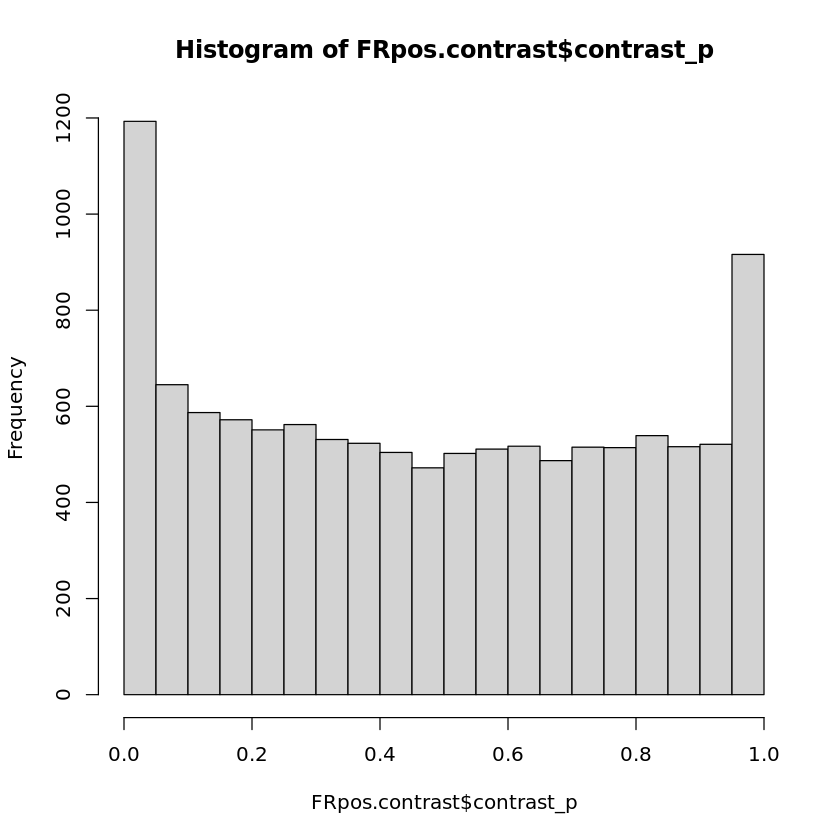

In [272]:
hist(FRpos.contrast$contrast_p)

In [260]:
test <- FRpos.contrast$gene[(FRpos.contrast$contrast_qval < 0.05) & (FRpos.contrast$contrast_effect > 1.5)]
length(test)

[1] 37

In [273]:
FRpos.contrast$gene[(FRpos.contrast$contrast_qval < 0.05) & (FRpos.contrast$contrast_effect > 1.5)]

[1] "4931428F04Rik" "Atp11c"        "Bex3"          "Ccnd2"        
 [5] "Cd320"         "Golgb1"        "Nup35"         "Stx16"        
 [9] "Syt3"          "Ttll1"         "Txnrd2"

In [274]:
test[test %in% dkkl1_rem_markers]

character(0)

In [277]:
FRpos.contrast[(FRpos.contrast$contrast_qval < 0.05) & (FRpos.contrast$contrast_effect > 1.5),]

,gene,contrast_p,contrast_effect,contrast_qval
,<chr>,<dbl>,<dbl>,<dbl>
104,4931428F04Rik,1.923846e-04,1.935568,0.017329811
921,Atp11c,1.321610e-04,1.588087,0.013538384
1146,Bex3,7.554668e-04,8.720899,0.044254131
1553,Ccnd2,1.434546e-05,1.511410,0.002839428
1600,Cd320,4.040559e-04,2.657968,0.029360242
3952,Golgb1,8.991983e-04,6.794651,0.049790619
6523,Nup35,2.636501e-04,1.823428,0.021088399
9493,Stx16,5.344296e-04,7.251578,0.036285287
9599,Syt3,6.698068e-04,3.506474,0.041386264


**------------------------JUNK CODE BELOW---------------**

In [264]:
controlcontrasts <- c(fit_FRvsNR = c(0,0,0,0,0,-1,1,0),
  fit_FRvsHC = c(0,0,0,0,0,0,1,-1),
  fit_FRvsNF = c(0,0,0,0,-1,0,1,0) )

In [265]:
# Last, the remaining DEGs must pass a permutation test in which the training labels are shuffled and a distribution of log2FC 
# is computed based on these labels. The true observed logFC must be above the 95th percentile of the distribution of 
# the shuffled distribution. After placing these constraints, 99 genes remain from the original list of 1,291.

First Attempt at gettin an FR unique list, gives us 100 DEGs which don't appear in the lsit of all 

In [266]:
FR_unique <- top_FR_posvsneg[!(rownames(top_FR_posvsneg) %in% rownames(top_posvsneg)),]
dim(FR_unique)
head(FR_unique)

ERROR: Error in eval(expr, envir, enclos): object 'top_FR_posvsneg' not found


In [ ]:
# normalization methods, we wont even use these

# paul prefers a log base that's easy to do headmath with so no eulers numebr
pseudocount_log2p1_transform <- function(x, scale_factor = 10^4, UMI.provided = NULL){
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x+1)/counts
  x <- x/scale_factor
  return(log2(x))
}

pavlab.normalize <- function(df, UMI = NULL){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
#
   df[] <- Map(pseudocount_log2p1_transform, df, UMI.provided = UMI)
  
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}

In [ ]:
# usused factors (predictors)
replicate <- predictors_bulk_glut$replicate
replicate <- gsub(pattern = '-', replacement = '', x = replicate)
replicate <- as.factor(replicate)
environment_exposure <- predictors_bulk_glut$environment_exposure
environment_exposure <- gsub(pattern = '-', replacement = '', x = environment_exposure)
environment_exposure <- as.factor(environment_exposure)
fear <- predictors_bulk_glut$fear
fear <- gsub(pattern = '-', replacement = '', x = fear)
fear <- as.factor(fear)
recall <- predictors_bulk_glut$recall
recall <- gsub(pattern = '-', replacement = '', x = recall)
recall <- as.factor(recall)

In [ ]:
gene_filter <-function(df_toptable){
    # DEG lsit from a topTable function, takes df of any size
    return(df_toptable[ abs(df_toptable$logFC)>0.3 & df_toptable$adj.P.Val<fdr_thresh,])
    }

In [ ]:
library(devtools)